# Imports & Functions

In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.stats import shapiro, f_oneway, kruskal, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
import pickle
import os


# -------------------------
# 0) Data helpers
# -------------------------
def get_table(
    data_dict: dict,
    year: str,
    table: str,
) -> pd.DataFrame:
    """Fetch a sheet/table from data_dict and return a copy."""
    return data_dict[year][table].copy()


def filter_surface_landuse_region(
    df: pd.DataFrame,
    *,
    phuid: int = 1,
    phsampleuid: int = 1,
    survey_id: int | None = None,
    regions: list[str] | None = None,
    phuid_col: str = "PHUID",
    sample_col: str = "PHSampleUID",
    survey_col: str = "SurveyID",
    region_col: str = "Location",
) -> pd.DataFrame:
    """
    Standard filter for your workflow:
    - surface: PHUID==1
    - target sample: PHSampleUID==1
    - land use: SurveyID==X (optional)
    - regions in [..] (optional)
    """
    out = df.copy()
    out = out[(out[phuid_col] == phuid) & (out[sample_col] == phsampleuid)]
    if survey_id is not None:
        out = out[out[survey_col] == survey_id]
    if regions is not None:
        out = out[out[region_col].isin(regions)]
    return out


def to_numeric_clean(df: pd.DataFrame, col: str) -> pd.Series:
    """Coerce to numeric and drop NaNs."""
    return pd.to_numeric(df[col], errors="coerce").dropna()

def compute_soil_texture_ratio(
    df_physical: pd.DataFrame,
    *,
    regions: list[str],
    region_col: str = "Location",
    clay_col: str | None = None,
    silt_col: str | None = None,
    sand_col: str | None = None,
    # 如果暂时只能用倒数列（与你现有数据兼容）
    clay_iloc: int = -5,
    silt_iloc: int = -4,
    sand_iloc: int = -3,
    round_digits: int = 1,
) -> pd.DataFrame:
    """
    计算各区域 Soil Texture（clay / sand / silt）百分比
    """
    out = {}

    for r in regions:
        sub = df_physical[df_physical[region_col] == r]

        if clay_col and silt_col and sand_col:
            clay = pd.to_numeric(sub[clay_col], errors="coerce").sum()
            silt = pd.to_numeric(sub[silt_col], errors="coerce").sum()
            sand = pd.to_numeric(sub[sand_col], errors="coerce").sum()
        else:
            clay = pd.to_numeric(sub.iloc[:, clay_iloc], errors="coerce").sum()
            silt = pd.to_numeric(sub.iloc[:, silt_iloc], errors="coerce").sum()
            sand = pd.to_numeric(sub.iloc[:, sand_iloc], errors="coerce").sum()

        total = clay + silt + sand

        out[r] = {
            "clay": clay / total * 100 if total != 0 else np.nan,
            "sand": sand / total * 100 if total != 0 else np.nan,
            "silt": silt / total * 100 if total != 0 else np.nan,
        }

    return pd.DataFrame.from_dict(out, orient="index").round(round_digits)

def plot_soil_texture_grouped_bar(
    ratio_df: pd.DataFrame,
    *,
    regions_order: list[str],
    textures=("clay", "sand", "silt"),
    palette: dict,
    figsize=(12, 5),
    dpi=150,
    bar_w=0.22,
    gap=0.30,
    y_max=105,
    value_fmt="{:.1f}%",
    label_offset=2.0,
    xlabel="Location",
    ylabel="Average Percentage (%)",
    legend_title="Soil Texture",
    fig_bottom=0.28,
):
    """
    Soil texture 分组柱状图（矩形）
    """
    tex_cfg = palette["textures"]
    axis_c = palette.get("axis_text_color", "#6B6B6B")
    value_c = palette.get("value_color", "#6B6B6B")
    grid_alpha = palette.get("grid_alpha", 0.35)

    df = ratio_df.reindex(regions_order)
    values = df[list(textures)].to_numpy()

    x = np.arange(len(regions_order))
    offsets = np.array([-gap, 0.0, gap])

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for j, tex in enumerate(textures):
        cfg = tex_cfg[tex]
        ax.bar(
            x + offsets[j],
            values[:, j],
            width=bar_w,
            color=cfg["face"],
            edgecolor=cfg["edge"],
            hatch=cfg.get("hatch"),
            linewidth=0.0,
            alpha=0.95,
        )

        for i, v in enumerate(values[:, j]):
            if np.isfinite(v):
                ax.text(
                    x[i] + offsets[j],
                    v + label_offset,
                    value_fmt.format(v),
                    ha="center",
                    va="bottom",
                    fontsize=12,
                    color=value_c,
                )

    ax.set_xlim(-0.6, len(regions_order) - 1 + 0.6)
    ax.set_ylim(0, y_max)
    ax.set_xticks(x)
    ax.set_xticklabels(regions_order, fontsize=12, color=axis_c)
    ax.tick_params(axis="x", pad=16)

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12, fontweight="bold", color="#4B4B4B")

    ax.yaxis.grid(True, alpha=grid_alpha)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    handles = [
        Patch(
            facecolor=tex_cfg[t]["face"],
            edgecolor=tex_cfg[t]["edge"],
            hatch=tex_cfg[t].get("hatch"),
            label=tex_cfg[t]["label"],
        )
        for t in textures
    ]

    fig.subplots_adjust(bottom=fig_bottom)
    fig.text(0.07, 0.06, legend_title, fontsize=12, fontweight="bold")

    fig.legend(
        handles=handles,
        loc="lower left",
        bbox_to_anchor=(0.18, 0.035),
        ncol=len(handles),
        frameon=False,
        fontsize=12,
    )

    plt.show()

def summary_bulk_density_by_region(
    df_physical: pd.DataFrame,
    *,
    regions: list[str],
    region_col: str = "Location",
    bulk_col: str = "BULKDENS",
    round_digits: int = 2,
) -> pd.DataFrame:
    """
    计算各区域 Bulk Density 均值
    """
    out = {}
    for r in regions:
        sub = df_physical[df_physical[region_col] == r]
        x = pd.to_numeric(sub[bulk_col], errors="coerce").dropna()
        out[r] = {"Bulk Density (g/cm³)": x.mean() if len(x) else np.nan}

    return pd.DataFrame.from_dict(out, orient="index").round(round_digits)

def plot_bulk_density_bar(
    df_region: pd.DataFrame,
    *,
    regions: list[str],
    value_col: str,
    palette: dict,
    ylabel: str = "Bulk Density (g/cm³)",
    figsize=(12, 3.4),
    dpi=150,
    hatch="..",
    value_fmt="{:.2f}",
):
    vals = df_region.reindex(regions)[value_col].to_numpy(dtype=float)
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    bars = ax.bar(
        x,
        vals,
        width=0.28,
        color=palette["base"],
        edgecolor=palette["edge"],
        hatch=hatch,
        linewidth=0.0,
        alpha=0.95,
    )

    for rect, v in zip(bars, vals):
        if np.isfinite(v):
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                v * 0.55,
                value_fmt.format(v),
                ha="center",
                va="center",
                fontsize=13,
                color=palette.get("value_text", "white"),
            )

    ax.set_xticks(x)
    ax.set_xticklabels(regions, fontsize=12, color="#7A7A7A")
    ax.set_ylabel(ylabel, fontsize=12)

    ax.yaxis.grid(True, alpha=0.35)
    ax.set_axisbelow(True)

    ax.tick_params(axis="y", labelleft=False, length=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.show()
# -------------------------
# 1) Descriptive stats table
# -------------------------
def summary_by_region(
    df: pd.DataFrame,
    *,
    value_col: str,
    regions: list[str],
    landuse_name: str = "Industrial",
    region_col: str = "Location",
    round_digits: int = 2,
) -> pd.DataFrame:
    """
    Return table indexed by (LandUse, Region):
    Mean±SE, Median, Min, Max, n
    """
    rows = []
    for region in regions:
        sub = df[df[region_col] == region]
        x = to_numeric_clean(sub, value_col)

        n = int(x.size)
        mean = float(x.mean()) if n else np.nan
        median = float(x.median()) if n else np.nan
        min_val = float(x.min()) if n else np.nan
        max_val = float(x.max()) if n else np.nan
        se = float(x.std(ddof=1) / np.sqrt(n)) if n > 1 else np.nan

        rows.append({
            "LandUse": landuse_name,
            "Region": region,
            "Mean ± se": f"{mean:.{round_digits}f} ± {se:.{round_digits}f}" if np.isfinite(mean) else "",
            "Median": round(median, round_digits) if np.isfinite(median) else np.nan,
            "Min": round(min_val, round_digits) if np.isfinite(min_val) else np.nan,
            "Max": round(max_val, round_digits) if np.isfinite(max_val) else np.nan,
            "n": n,
        })

    out = (
        pd.DataFrame(rows)
        .set_index(["LandUse", "Region"])
        .loc[:, ["Mean ± se", "Median", "Min", "Max", "n"]]
    )
    return out


# -------------------------
# 2) Regional difference test + letters
# -------------------------
def regional_samples(
    df: pd.DataFrame,
    *,
    value_col: str,
    regions: list[str],
    region_col: str = "Location",
) -> dict[str, np.ndarray]:
    """Return {region: np.array(values)}."""
    tmp = df.copy()
    tmp[value_col] = pd.to_numeric(tmp[value_col], errors="coerce")
    return {r: tmp.loc[tmp[region_col] == r, value_col].dropna().to_numpy() for r in regions}


def shapiro_normality(samples: dict[str, np.ndarray], alpha: float = 0.05) -> pd.DataFrame:
    """Shapiro test per region (len<3 returns NaN, Normal? False)."""
    rows = []
    for r, x in samples.items():
        if len(x) < 3:
            rows.append({"Region": r, "n": len(x), "W": np.nan, "p": np.nan, "Normal?": False})
        else:
            W, p = shapiro(x)
            rows.append({"Region": r, "n": len(x), "W": W, "p": p, "Normal?": (p >= alpha)})
    return pd.DataFrame(rows).set_index("Region")


def overall_test(samples: dict[str, np.ndarray], regions: list[str], alpha: float = 0.05) -> pd.DataFrame:
    """
    Decide ANOVA vs Kruskal based on Shapiro normality across all regions.
    Return a one-row table with test name, statistic, p.
    """
    df_norm = shapiro_normality(samples, alpha=alpha)
    all_normal = bool(df_norm["Normal?"].all())
    x_list = [samples[r] for r in regions]

    if all_normal:
        stat, p = f_oneway(*x_list)
        return pd.DataFrame([{"Test": "One-way ANOVA", "Statistic": stat, "p_value": p}])
    else:
        stat, p = kruskal(*x_list)
        return pd.DataFrame([{"Test": "Kruskal–Wallis", "Statistic": stat, "p_value": p}])


def posthoc_tests(
    samples: dict[str, np.ndarray],
    regions: list[str],
    alpha: float = 0.05,
) -> tuple[pd.DataFrame, dict[frozenset, bool], bool]:
    """
    If all normal -> Welch t-tests (LSD-style, no correction)
    Else -> Mann-Whitney + Holm correction
    Return:
      - df_posthoc
      - sig_dict: frozenset({r1,r2}) -> True if significantly different
      - all_normal
    """
    df_norm = shapiro_normality(samples, alpha=alpha)
    all_normal = bool(df_norm["Normal?"].all())

    post_rows = []
    sig_dict: dict[frozenset, bool] = {}

    if all_normal:
        for r1, r2 in combinations(regions, 2):
            x1, x2 = samples[r1], samples[r2]
            t_stat, p_pair = ttest_ind(x1, x2, equal_var=False, nan_policy="omit")
            sig = bool(p_pair < alpha)
            sig_dict[frozenset([r1, r2])] = sig
            post_rows.append({
                "Comparison": f"{r1} vs {r2}",
                "Test": "Welch t-test (LSD-style)",
                "Statistic": t_stat,
                "p_value": p_pair,
                "Significant": sig,
            })
        df_post = pd.DataFrame(post_rows).sort_values("p_value")
    else:
        raw_p = []
        pair_keys = []
        for r1, r2 in combinations(regions, 2):
            x1, x2 = samples[r1], samples[r2]
            p_pair = mannwhitneyu(x1, x2, alternative="two-sided").pvalue
            raw_p.append(p_pair)
            pair_keys.append((r1, r2))
            post_rows.append({"Comparison": f"{r1} vs {r2}", "Test": "Mann–Whitney U", "p_raw": p_pair})

        reject, p_adj, _, _ = multipletests(raw_p, alpha=alpha, method="holm")
        for i, (r1, r2) in enumerate(pair_keys):
            sig = bool(reject[i])
            sig_dict[frozenset([r1, r2])] = sig
            post_rows[i]["p_adj_holm"] = p_adj[i]
            post_rows[i]["Significant"] = sig

        df_post = pd.DataFrame(post_rows).sort_values("p_adj_holm")

    return df_post, sig_dict, all_normal


def assign_letters_from_sig(
    summary_df: pd.DataFrame,
    sig_dict: dict[frozenset, bool],
    *,
    landuse_name: str,
    regions: list[str],
) -> dict[str, str]:
    """
    Letter grouping:
    - same letter => NOT significantly different
    - different letters => significantly different
    Letters assigned from high mean to low mean.
    """
    def extract_mean(mean_se_str: str) -> float:
        try:
            return float(mean_se_str.split("±")[0].strip())
        except Exception:
            return np.nan

    tmp = summary_df.reset_index().copy()
    tmp = tmp[tmp["LandUse"] == landuse_name].copy()
    tmp["MeanValue"] = tmp["Mean ± se"].apply(extract_mean)
    tmp = tmp[tmp["Region"].isin(regions)].sort_values("MeanValue", ascending=False)

    letters: dict[str, str] = {}
    used_letters: list[str] = []

    for region in tmp["Region"].tolist():
        assigned = False
        for letter in used_letters:
            compatible = True
            for r_assigned, l_assigned in letters.items():
                if l_assigned == letter:
                    if sig_dict.get(frozenset([region, r_assigned]), False):
                        compatible = False
                        break
            if compatible:
                letters[region] = letter
                assigned = True
                break
        if not assigned:
            new_letter = chr(ord("a") + len(used_letters))
            used_letters.append(new_letter)
            letters[region] = new_letter

    return letters


def append_letters_to_summary(
    summary_df: pd.DataFrame,
    letters: dict[str, str],
    *,
    landuse_name: str,
    regions: list[str],
) -> pd.DataFrame:
    """Append letters after Mean±se for the given landuse/regions."""
    out = summary_df.copy()
    for region in regions:
        idx = (landuse_name, region)
        if idx in out.index:
            s = out.loc[idx, "Mean ± se"]
            out.loc[idx, "Mean ± se"] = f"{s} {letters.get(region, '')}".rstrip()
    return out


# -------------------------
# 3) Class bins (pH / EC) table
# -------------------------
def class_distribution_by_region(
    df: pd.DataFrame,
    *,
    value_col: str,
    bins: list[tuple[float, float, str]],
    regions: list[str],
    region_col: str = "Location",
    right_inclusive: bool = True,
    round_digits: int = 1,
) -> pd.DataFrame:
    """
    Return MultiIndex table: (Region, Class) -> Percentage, Count
    """
    tmp = df.copy()
    tmp[value_col] = pd.to_numeric(tmp[value_col], errors="coerce")

    rows = []
    for region in regions:
        sub = tmp[tmp[region_col] == region]
        x = sub[value_col].dropna()
        total_n = int(x.shape[0])

        for low, high, label in bins:
            if np.isinf(low):
                mask = x < high if right_inclusive else x <= high
            elif np.isinf(high):
                mask = x > low if right_inclusive else x >= low
            else:
                if right_inclusive:
                    mask = (x >= low) & (x <= high)
                else:
                    mask = (x >= low) & (x < high)

            count = int(mask.sum())
            percent = (count / total_n * 100.0) if total_n > 0 else np.nan

            rows.append({
                "Region": region,
                "Class": label,
                "Percentage (%)": round(float(percent), round_digits) if np.isfinite(percent) else np.nan,
                "Count": count,
            })

    out = pd.DataFrame(rows).set_index(["Region", "Class"])
    return out


# -------------------------
# 4) Plot: horizontal stacked percent bars
# -------------------------
def plot_stacked_percent_barh(
    pct_table: pd.DataFrame,
    *,
    regions_order: list[str],
    class_order: list[str],
    colors: dict[str, str] | None = None,
    label_min: float = 3.0,
    figsize=(12, 3.6),
    dpi: int = 150,
    legend_ncol: int = 4,
    legend_loc: str = "lower center",
    legend_bbox=(0.5, 0.02),
):
    """
    pct_table: MultiIndex (Region, Class) with "Percentage (%)"
    """
    pct_wide = (
        pct_table["Percentage (%)"]
        .unstack("Class")
        .fillna(0.0)
        .reindex(regions_order)
    )

    # ensure all classes exist
    for c in class_order:
        if c not in pct_wide.columns:
            pct_wide[c] = 0.0
    pct_wide = pct_wide[class_order]

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    y = np.arange(pct_wide.shape[0])
    left = np.zeros(pct_wide.shape[0])

    for cls in class_order:
        vals = pct_wide[cls].to_numpy(dtype=float)
        ax.barh(
            y, vals, left=left, height=0.55,
            color=(colors[cls] if colors else None),
            edgecolor="none",
        )
        for i, v in enumerate(vals):
            if v >= label_min:
                ax.text(left[i] + v / 2, y[i], f"{v:.1f}%", ha="center", va="center", fontsize=11, color="white")
        left += vals

    ax.set_yticks(y)
    ax.set_yticklabels(pct_wide.index, fontsize=12, color="#4B4B4B")
    ax.set_xlim(0, 100)
    ax.xaxis.grid(True, linestyle="-", linewidth=0.7, alpha=0.35)
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", labelbottom=False, length=0)

    for sp in ["top", "right", "bottom", "left"]:
        ax.spines[sp].set_visible(False)

    handles = [Patch(facecolor=(colors[c] if colors else "gray"), label=c) for c in class_order]
    fig.subplots_adjust(bottom=0.28)
    fig.legend(
        handles=handles,
        loc=legend_loc,
        bbox_to_anchor=legend_bbox,
        ncol=legend_ncol,
        frameon=False,
        fontsize=10,
        handlelength=1.2,
        handleheight=1.2,
        columnspacing=1.6,
    )
    plt.show()
    return fig, ax


# -------------------------
# 5) Plot: box + jitter + mean marker
# -------------------------
def plot_box_jitter_mean(
    df: pd.DataFrame,
    *,
    value_col: str,
    regions_order: list[str],
    region_col: str = "Location",
    exclude_below: float | None = None,
    ylabel: str = "Value",
    figsize=(7.2, 4.8),
    dpi: int = 150,
    rng_seed: int = 42,
    facecolor: str = "#C79A78",
):
    """
    Boxplot per region with all points + mean marker.
    """
    data_by_region = []
    for region in regions_order:
        sub = df[df[region_col] == region].copy()
        x = pd.to_numeric(sub[value_col], errors="coerce").dropna()
        if exclude_below is not None:
            x = x[x >= exclude_below]
        data_by_region.append(x.to_numpy())

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.boxplot(
        data_by_region,
        widths=0.30,
        patch_artist=True,
        showfliers=True,
        flierprops=dict(marker="+", markersize=6, markerfacecolor="none",
                        markeredgecolor="red", markeredgewidth=1.0, linestyle="none"),
        boxprops=dict(facecolor=facecolor, edgecolor="#333333", linewidth=1.0, alpha=0.85),
        medianprops=dict(color="#333333", linewidth=1.2),
        whiskerprops=dict(color="#333333", linewidth=1.0),
        capprops=dict(color="#333333", linewidth=1.0),
    )

    rng = np.random.default_rng(rng_seed)
    for i, arr in enumerate(data_by_region, start=1):
        if arr.size == 0:
            continue
        jitter = rng.normal(0.0, 0.02, size=arr.size)
        ax.scatter(np.full(arr.size, i) + jitter, arr, s=2, c="black", linewidths=0, zorder=2)

    means = [np.mean(arr) if arr.size else np.nan for arr in data_by_region]
    xpos = np.arange(1, len(regions_order) + 1)
    ax.scatter(xpos, means, marker="^", s=80, c="#2C2C2C", linewidths=0, zorder=4)

    ax.set_xticks(xpos)
    ax.set_xticklabels(regions_order, fontsize=11, color="#7A7A7A")
    ax.set_ylabel(ylabel, fontsize=12, color="#7A7A7A")
    for tick in ax.get_yticklabels():
        tick.set_color("#7A7A7A")

    ax.grid(axis="y", linestyle="-", alpha=0.35)
    ax.set_axisbelow(True)
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)
    ax.tick_params(axis="both", which="both", length=0)

    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_mean_bar_single_year(
    summary_df,
    *,
    regions: list[str],
    landuse_name: str,
    palette: dict,
    ylabel: str,
    value_from: str = "Mean ± se",
    figsize=(12, 3.4),
    dpi: int = 150,
    show_values: bool = True,
    value_fmt: str = "{:.2f}",
    value_ypos_ratio: float = 0.55,   # 数字在柱内的相对位置
    legend_label: str = "Surface",
    legend: bool = True,
):
    """
    summary_df: MultiIndex (LandUse, Region) 表，至少包含 value_from 列（例如 'Mean ± se'）
    逻辑：从 'Mean ± se' 提取均值，画三地区柱形图，柱内标注数值
    """
    def extract_mean(x):
        # 支持 "7.12 ± 0.10 a" 或 "7.12 ± 0.10"
        if not isinstance(x, str):
            return np.nan
        left = x.split("±")[0].strip()  # "7.12" 或 "7.12 a"(不会发生，但防一下)
        # 如果后面带字母，把非数值剔除
        try:
            return float(left.split()[0])
        except Exception:
            return np.nan

    # 取均值数组
    means = []
    for r in regions:
        idx = (landuse_name, r)
        if idx not in summary_df.index:
            means.append(np.nan)
            continue
        means.append(extract_mean(summary_df.loc[idx, value_from]))

    means = np.array(means, dtype=float)

    # palette
    bar_face = palette.get("base", "#C79A78")
    bar_edge = palette.get("edge", bar_face)
    grid_c   = palette.get("grid", None)
    text_c   = palette.get("value_text", "white")  # 可选：柱内文字颜色

    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    bars = ax.bar(
        x,
        means,
        width=0.28,
        color=bar_face,
        edgecolor=bar_edge,
        linewidth=0.0,
        alpha=0.95
    )

    # 柱内白色数值
    if show_values:
        for rect, v in zip(bars, means):
            if np.isnan(v):
                continue

            # --- 3 significant digits, keep trailing zeros (e.g., 0.70) ---
            if v == 0:
                s = "0.00"
            else:
                digits = int(math.floor(math.log10(abs(v)))) + 1
                decimals_sig = max(0, 3 - digits)
                decimals = min(decimals_sig, 2)
                s = f"{v:.{decimals}f}"

            ax.text(
                rect.get_x() + rect.get_width() / 2,
                v * value_ypos_ratio,
                s,
                ha="center",
                va="center",
                fontsize=13,
                color=text_c
            )

    # x 轴
    ax.set_xticks(x)
    ax.set_xticklabels(regions, fontsize=12, color="#7A7A7A")
    ax.tick_params(axis="x", pad=10)

    # y 轴（隐藏刻度数字，保留网格）
    ax.set_ylabel(ylabel, fontsize=12, color="#7A7A7A")
    ax.tick_params(axis="y", labelleft=False, length=0)

    # y 上限留白
    if np.isfinite(means).any():
        ax.set_ylim(0, np.nanmax(means) * 1.15)

    # 网格
    ax.yaxis.grid(True, linestyle="-", linewidth=0.8, alpha=0.35)
    if grid_c is not None:
        # 如果你想强制网格颜色，可以打开下面两行（默认不强制）
        for line in ax.get_ygridlines():
            line.set_color(grid_c)
    ax.set_axisbelow(True)

    # 去掉多余边框
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)
    ax.tick_params(axis="both", which="both", length=0)

    # legend（可选）
    if legend:
        fig.subplots_adjust(bottom=0.25)
        handle = Patch(
            facecolor=bar_face,
            edgecolor=bar_edge,
            hatch="..",
            label=legend_label,
            alpha=0.95
        )
        ax.legend(handles=[handle], frameon=False, loc="lower left", bbox_to_anchor=(0.02, -0.35))

    plt.tight_layout()
    plt.show()
    return fig, ax
# -------------------------
# 6) Multi-year analysis (per region) + stars on adjacent significant years
# -------------------------
def build_long_year_region(
    data_dict: dict,
    *,
    years: list[str],
    table: str,
    value_col: str,
    survey_id: int,
    regions: list[str],
    region_col: str = "Location",
    phuid: int = 1,
    phsampleuid: int = 1,
) -> pd.DataFrame:
    """
    Combine multiple years into a long dataframe with columns:
    Region, Value, YearLabel, YearNum
    """
    recs = []
    for year in years:
        df = get_table(data_dict, year, table)
        df = filter_surface_landuse_region(
            df, phuid=phuid, phsampleuid=phsampleuid, survey_id=survey_id, regions=regions, region_col=region_col
        )
        df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
        recs.append(
            df[[region_col, value_col]]
            .rename(columns={region_col: "Region", value_col: "Value"})
            .assign(YearLabel=year)
        )

    out = pd.concat(recs, ignore_index=True)
    out["YearNum"] = out["YearLabel"].str.extract(r"(\d{4})").astype(int)
    out = out.dropna(subset=["Region", "Value", "YearNum"]).copy()
    return out


def year_anova_posthoc_by_region(
    long_df: pd.DataFrame,
    *,
    alpha: float = 0.05,
) -> tuple[dict[str, pd.DataFrame], dict[str, pd.DataFrame]]:
    """
    For each region:
    - ANOVA of Value ~ C(YearNum)
    - Posthoc pairwise Welch t-tests + Holm correction
    Return:
      anova_by_region, posthoc_by_region
    """
    anova_by_region = {}
    posthoc_by_region = {}

    for region, sub in long_df.groupby("Region"):
        model = smf.ols("Value ~ C(YearNum)", data=sub).fit()
        anova_by_region[region] = sm.stats.anova_lm(model, typ=2)

        years_sorted = sorted(sub["YearNum"].unique())
        pairs = list(combinations(years_sorted, 2))

        comps, raw_pvals = [], []
        for y1, y2 in pairs:
            x1 = sub.loc[sub["YearNum"] == y1, "Value"].dropna().to_numpy()
            x2 = sub.loc[sub["YearNum"] == y2, "Value"].dropna().to_numpy()
            t_res = sm.stats.ttest_ind(x1, x2, usevar="unequal")  # Welch
            raw_pvals.append(float(t_res[1]))
            comps.append(f"{y1} vs {y2}")

        reject, p_holm, _, _ = multipletests(raw_pvals, alpha=alpha, method="holm")
        posthoc_by_region[region] = (
            pd.DataFrame({"Comparison": comps, "p_raw": raw_pvals, "p_holm": p_holm, "Significant": reject})
            .sort_values("p_holm")
        )

    return anova_by_region, posthoc_by_region


def adjacent_sig_years_from_posthoc(
    long_df: pd.DataFrame,
    posthoc_by_region: dict[str, pd.DataFrame],
) -> dict[str, set[int]]:
    """
    Star rule (your logic):
    - only consider adjacent years (y_i, y_{i+1})
    - if significant, put star on the later year y_{i+1}
    """
    out = {}
    for region, df_post in posthoc_by_region.items():
        years_sorted = sorted(long_df.loc[long_df["Region"] == region, "YearNum"].unique())
        adjacent_pairs = {(years_sorted[i], years_sorted[i+1]) for i in range(len(years_sorted)-1)}

        years_to_star = set()
        for _, row in df_post.iterrows():
            if not bool(row["Significant"]):
                continue
            y1, y2 = map(int, row["Comparison"].split(" vs "))
            if (y1, y2) in adjacent_pairs:
                years_to_star.add(y2)

        out[region] = years_to_star
    return out


def plot_grouped_bars_years(
    mean_by_region_year: pd.DataFrame,
    *,
    regions_order: list[str],
    year_col: str = "YearNum",
    value_col: str = "MeanValue",
    star_years: dict[str, set[int]] | None = None,
    ylabel: str = "Value",
    base_color: str = "#9A5C2E",
    bar_w: float = 0.10,
    gap_in_group: float = 0.05,
    group_gap: float = 1.5,
    figsize=(10, 4.6),
):
    """
    mean_by_region_year must have: Region, YearNum, MeanValue
    star_years: {Region: set(YearNum)} -> add '*' on that year label
    """
    years_sorted = sorted(mean_by_region_year[year_col].unique())
    values = np.full((len(regions_order), len(years_sorted)), np.nan)
    stars = np.zeros_like(values, dtype=bool)

    for ri, region in enumerate(regions_order):
        sub = mean_by_region_year[mean_by_region_year["Region"] == region]
        for yi, y in enumerate(years_sorted):
            v = sub.loc[sub[year_col] == y, value_col]
            if not v.empty:
                values[ri, yi] = float(v.iloc[0])
            if star_years is not None:
                stars[ri, yi] = (y in star_years.get(region, set()))

    group_x = np.arange(len(regions_order)) * group_gap
    group_width = len(years_sorted) * bar_w + (len(years_sorted) - 1) * gap_in_group
    start_offsets = -group_width / 2 + bar_w / 2
    alphas = np.linspace(1.0, 0.35, len(years_sorted))

    fig, ax = plt.subplots(figsize=figsize)

    for yi, y in enumerate(years_sorted):
        x = group_x + start_offsets + yi * (bar_w + gap_in_group)
        ax.bar(x, values[:, yi], width=bar_w, color=base_color, alpha=float(alphas[yi]),
               edgecolor="none", label=str(y))

        for ri, (xx, h) in enumerate(zip(x, values[:, yi])):
            if np.isnan(h):
                continue
            if h == 0:
                s = "0.00"
            else:
                digits = int(math.floor(math.log10(abs(h)))) + 1
                decimals = max(0, 3 - digits)
                decimals = min(decimals, 2)
                s = f"{h:.{decimals}f}"

            label = s + ("*" if stars[ri, yi] else "")
            ax.text(xx, h + np.nanmax(values)*0.01, label, ha="center", va="bottom", fontsize=9, color="#7A7A7A")

    ax.set_xticks(group_x)
    ax.set_xticklabels(regions_order, fontsize=12, c="#7A7A7A")
    ax.set_ylabel(ylabel, color="#7A7A7A")
    for tick in ax.get_yticklabels():
        tick.set_color("#7A7A7A")

    ax.set_ylim(0, np.nanmax(values)*1.2)
    ax.grid(axis="y", alpha=0.35)
    for sp in ["top", "right", "left"]:
        ax.spines[sp].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)
    ax.tick_params(axis="both", which="both", length=0)

    handles = [Patch(facecolor=base_color, alpha=float(alphas[yi]), label=str(years_sorted[yi]))
               for yi in range(len(years_sorted))]
    legend = ax.legend(handles=handles, frameon=False, ncol=len(years_sorted),
                       loc="lower left", bbox_to_anchor=(0.0, -0.18))
    plt.setp(legend.get_texts(), color="#7A7A7A")

    plt.tight_layout()
    plt.show()
    return fig, ax


# GIS Function

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib.colors import to_hex

from matplotlib.patches import Patch

def get_extreme_point(
    df: pd.DataFrame,
    *,
    value_col: str,
    mode: str = "max",            # "max" or "min"
    region_col: str = "Location",
    site_col: str = "SiteUID",
    lon_col: str = "Longitude",
    lat_col: str = "Latitude",
) -> pd.Series:
    """
    从已过滤好的 DataFrame 中提取极值点信息（不画图）

    Returns: pd.Series
      - Region
      - SiteUID
      - Longitude
      - Latitude
      - Value
    """

    if mode not in {"max", "min"}:
        raise ValueError("mode must be 'max' or 'min'")

    x = pd.to_numeric(df[value_col], errors="coerce")
    df2 = df.assign(_value_=x).dropna(
        subset=[ "_value_", lon_col, lat_col ]
    )

    if df2.empty:
        raise ValueError("No valid records after numeric & coordinate filtering.")

    if mode == "max":
        row = df2.loc[df2["_value_"].idxmax()]
    else:
        row = df2.loc[df2["_value_"].idxmin()]

    return pd.Series({
        "Region": row.get(region_col),
        "SiteUID": row.get(site_col),
        "Longitude": row.get(lon_col),
        "Latitude": row.get(lat_col),
        "Value": row["_value_"],
    })


# Settings

In [4]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

PROJECT_ROOT = '../'
data_path = os.path.join(PROJECT_ROOT, 'data_hmq/data_dict.pkl')
with open(data_path, "rb") as f:
    data_dict = pickle.load(f)

land_use_id, land_use_name = 8, 'Residential'
regions = ["Abu Dhabi", "Al Ain", "Al Dhafra"]
year = "Soil quality data 2025"

OUT_DIR = r"../Result_hmq/Ch08_Figures"
os.makedirs(OUT_DIR, exist_ok=True)

# 1.3 pH

#### 数据读取

In [5]:
col_name = "satph"
element_name = "pH"
df = get_table(data_dict, year, "PHChemical")
df = filter_surface_landuse_region(df, survey_id=land_use_id, regions=regions)
df

,SurveyID,SiteUID,SiteObsUID,PedonUID,PHUID,PHSampleUID,PHSubSampleUID,PHChemicalUID,Longitude,Latitude,...,satph,satec,TotalOrganicCarbon,TotalKjeldahlNitrogen_TKN,Boron \n(sat paste),Calcium \n(sat paste),Magnesium \n(sat paste),Sodium \n(sat paste),Potassium \n(sat paste),SAR
0,8,10004161220,3,2,1,1,1,1,54.374728,24.455875,...,7.8,27.600,1.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,10004121138,3,2,1,1,1,1,54.363589,24.456906,...,8.2,2.970,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,10004222728,3,2,1,1,1,1,54.360639,24.460648,...,8.2,0.984,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,10004222572,3,2,1,1,1,1,54.364432,24.461803,...,8.2,1.800,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,10004120958,8,2,1,1,1,1,54.358618,24.450317,...,7.7,21.700,1.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,8,1002326233,3,2,1,1,1,1,53.703403,23.666218,...,7.7,4.050,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,8,100135135,3,2,1,1,1,1,53.711574,23.659154,...,8.0,41.100,0.342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,8,1002311888,8,2,1,1,1,1,53.719452,23.625507,...,7.4,6.780,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,8,1002361285,3,2,1,1,1,1,53.796831,23.131239,...,7.6,3.980,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 极值点坐标

In [6]:
extreme_ph = get_extreme_point(
    df,
    value_col=col_name,
    mode="max",   # pH 取最小
)

extreme_ph

Region         Abu Dhabi
SiteUID      10004275185
Longitude      54.459845
Latitude       24.429532
Value               10.2
dtype: object

#### 描述性统计

In [7]:
df_surface = summary_by_region(df, value_col=col_name, regions=regions, landuse_name=land_use_name)
display(df_surface)

Mean ± se  Median  Min   Max   n
LandUse     Region                                       
Residential Abu Dhabi  7.91 ± 0.05     8.0  6.4  10.2  97
            Al Ain     8.00 ± 0.03     8.0  7.5   8.3  32
            Al Dhafra  7.76 ± 0.07     7.8  7.1   8.2  21

#### 显著性检验

In [8]:
samples = regional_samples(df, value_col=col_name, regions=regions)
df_post, sig_dict, all_normal = posthoc_tests(samples, regions)
display(df_post)

letters = assign_letters_from_sig(df_surface.reset_index(), sig_dict, landuse_name=land_use_name, regions=regions)
df_ph_surface_labeled = append_letters_to_summary(df_surface, letters, landuse_name=land_use_name, regions=regions)
display(df_ph_surface_labeled)

,Comparison,Test,p_raw,p_adj_holm,Significant
2,Al Ain vs Al Dhafra,Mann–Whitney U,0.004260,0.012779,True
1,Abu Dhabi vs Al Dhafra,Mann–Whitney U,0.036566,0.073132,False
0,Abu Dhabi vs Al Ain,Mann–Whitney U,0.468407,0.468407,False


Mean ± se  Median  Min   Max   n
LandUse     Region                                         
Residential Abu Dhabi  7.91 ± 0.05 a     8.0  6.4  10.2  97
            Al Ain     8.00 ± 0.03 a     8.0  7.5   8.3  32
            Al Dhafra  7.76 ± 0.07 b     7.8  7.1   8.2  21

#### 分级表 + 堆叠图

Percentage (%)  Count
Region    Class                                               
Abu Dhabi Strongly Acidic (<5.6)                    0.0      0
          Moderately Acidic (5.6–6.0)               0.0      0
          Slightly Acidic (6.1–6.5)                 1.0      1
          Neutral (6.6–7.3)                         8.2      8
          Slightly Alkaline (7.4–7.8)              25.8     25
          Moderately Alkaline (7.9–8.4)            61.9     60
          Strongly Alkaline (8.5–9.0)               2.1      2
          Extremely Alkaline (>9.0)                 1.0      1
Al Ain    Strongly Acidic (<5.6)                    0.0      0
          Moderately Acidic (5.6–6.0)               0.0      0
          Slightly Acidic (6.1–6.5)                 0.0      0
          Neutral (6.6–7.3)                         0.0      0
          Slightly Alkaline (7.4–7.8)              15.6      5
          Moderately Alkaline (7.9–8.4)            84.4     27
          Strongly Alkaline (8.5–9.0)               0.0      0
          Extremely Alkaline (>9.0)                 0.0      0
Al Dhafra Strongly Acidic (<5.6)                    0.0      0
          Moderately Acidic (5.6–6.0)               0.0      0
          Slightly Acidic (6.1–6.5)                 0.0      0
          Neutral (6.6–7.3)                         4.8      1
          Slightly Alkaline (7.4–7.8)              57.1     12
          Moderately Alkaline (7.9–8.4)            38.1      8
          Strongly Alkaline (8.5–9.0)               0.0      0
          Extremely Alkaline (>9.0)                 0.0      0

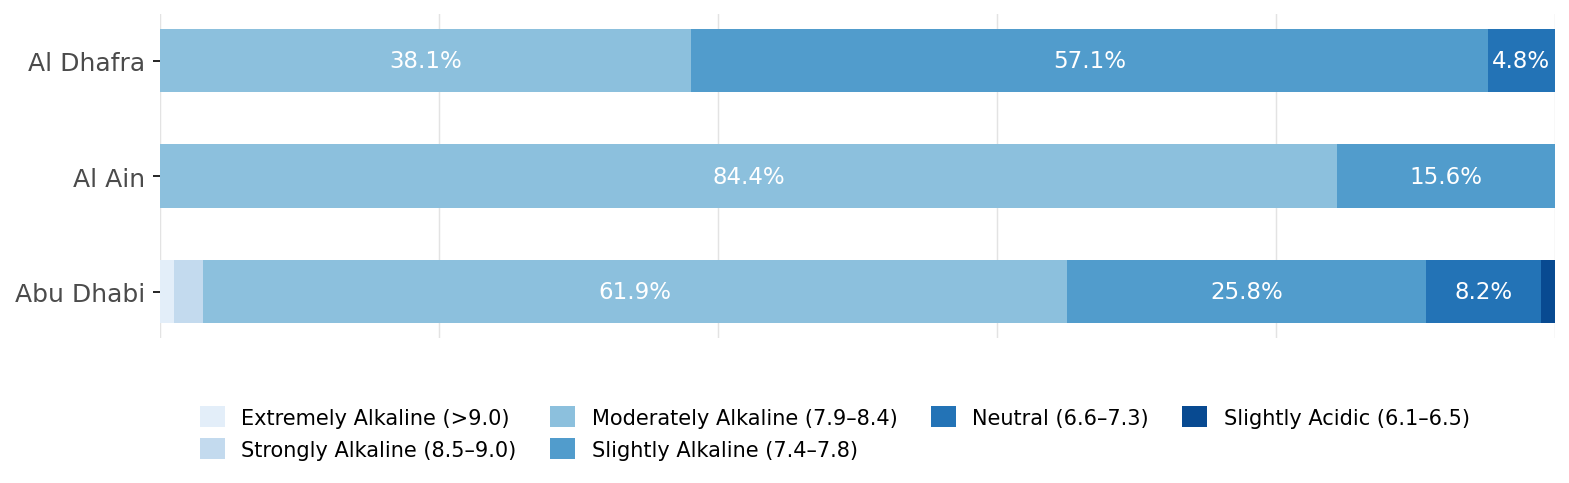

In [9]:
bins = [
    (-float("inf"), 5.6,  "Strongly Acidic (<5.6)"),
    (5.6, 6.0,       "Moderately Acidic (5.6–6.0)"),
    (6.1, 6.5,       "Slightly Acidic (6.1–6.5)"),
    (6.6, 7.3,       "Neutral (6.6–7.3)"),
    (7.4, 7.8,       "Slightly Alkaline (7.4–7.8)"),
    (7.9, 8.4,       "Moderately Alkaline (7.9–8.4)"),
    (8.5, 9.0,       "Strongly Alkaline (8.5–9.0)"),
    (9.0, float("inf"), "Extremely Alkaline (>9.0)"),
]

df_ph_class = class_distribution_by_region(df, value_col=col_name, bins=bins, regions=regions)
display(df_ph_class)
class_order = [
    "Extremely Alkaline (>9.0)",
    "Strongly Alkaline (8.5–9.0)",
    "Moderately Alkaline (7.9–8.4)",
    "Slightly Alkaline (7.4–7.8)",
    "Neutral (6.6–7.3)",
    "Slightly Acidic (6.1–6.5)",
]

cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
n = len(class_order)
values = np.linspace(0.1, 0.9, n)  # 避开两端极端色
hex_colors = [to_hex(cmap(v)) for v in values]
colors = dict(zip(class_order, hex_colors))

fig, ax = plot_stacked_percent_barh(
    df_ph_class,
    regions_order=regions,
    class_order=class_order,
    colors=colors,
    label_min=3.0,
    legend_ncol=4
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_stacked_percent_barh.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_stacked_percent_barh.svg"), bbox_inches="tight", pad_inches=0.1)

#### 箱线图 + 散点 + 均值

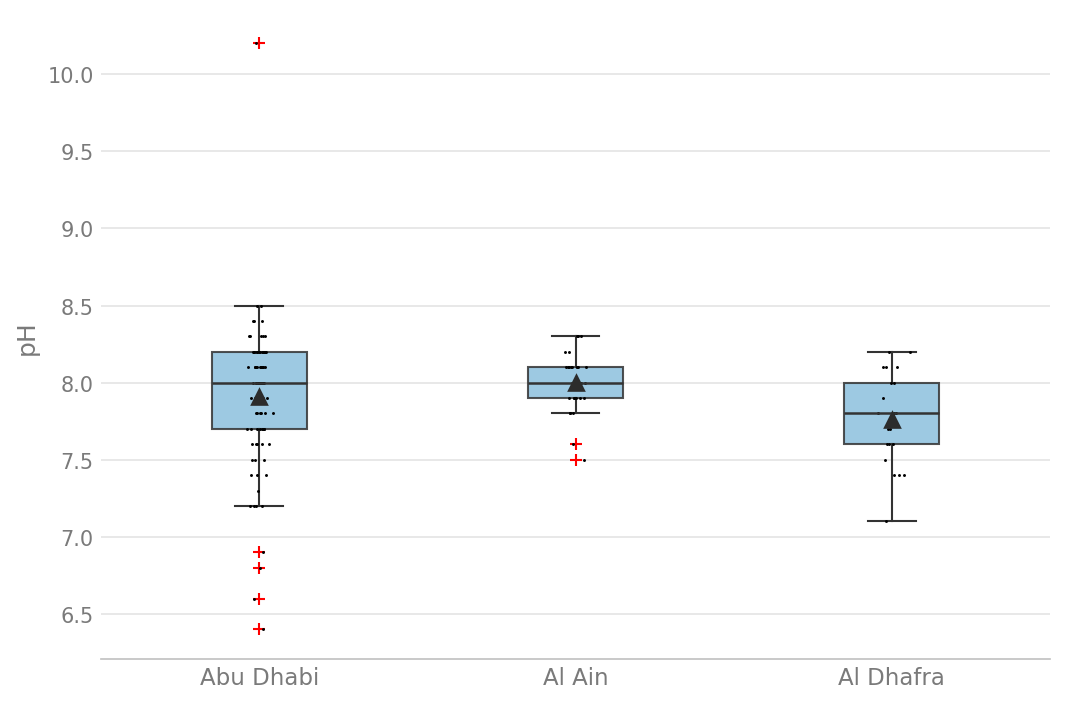

In [10]:
fig, ax = plot_box_jitter_mean(
    df, value_col=col_name,
    regions_order=regions,
    ylabel=element_name,
    exclude_below=None,
    facecolor=hex_colors[2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_box_jitter_mean.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_box_jitter_mean.svg"), bbox_inches="tight", pad_inches=0.1)

#### 单年均值柱形图

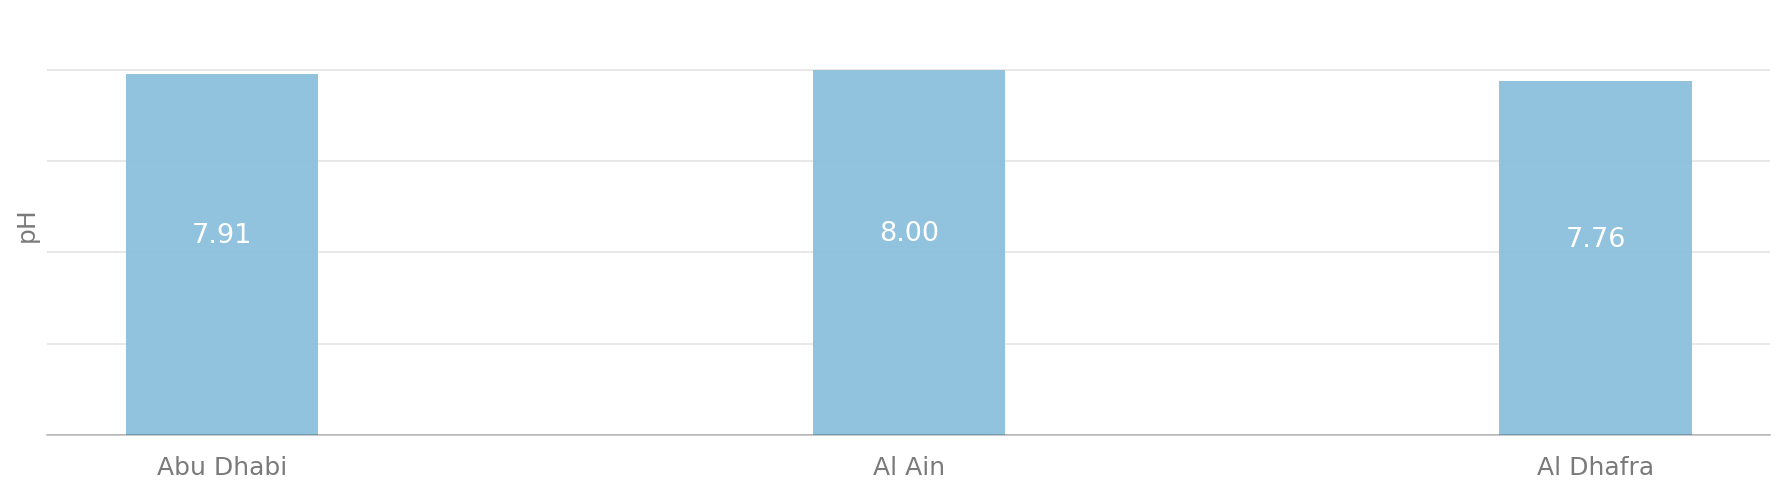

In [11]:
PH_PALETTE = {
    "base": hex_colors[2],
    "edge": "#C79A78",
    "mean": "#2C2C2C",
    "scatter": "#000000",
    "value_text": "white",
}

fig, ax = plot_mean_bar_single_year(
    df_surface,                       # 你前面算出来的 summary 表
    regions=regions,
    landuse_name=land_use_name,
    palette=PH_PALETTE,
    ylabel=element_name,
    legend_label="Surface",
    legend=False,
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_mean_bar_single_year.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_mean_bar_single_year.svg"), bbox_inches="tight", pad_inches=0.1)

#### 2020–2025 年度趋势

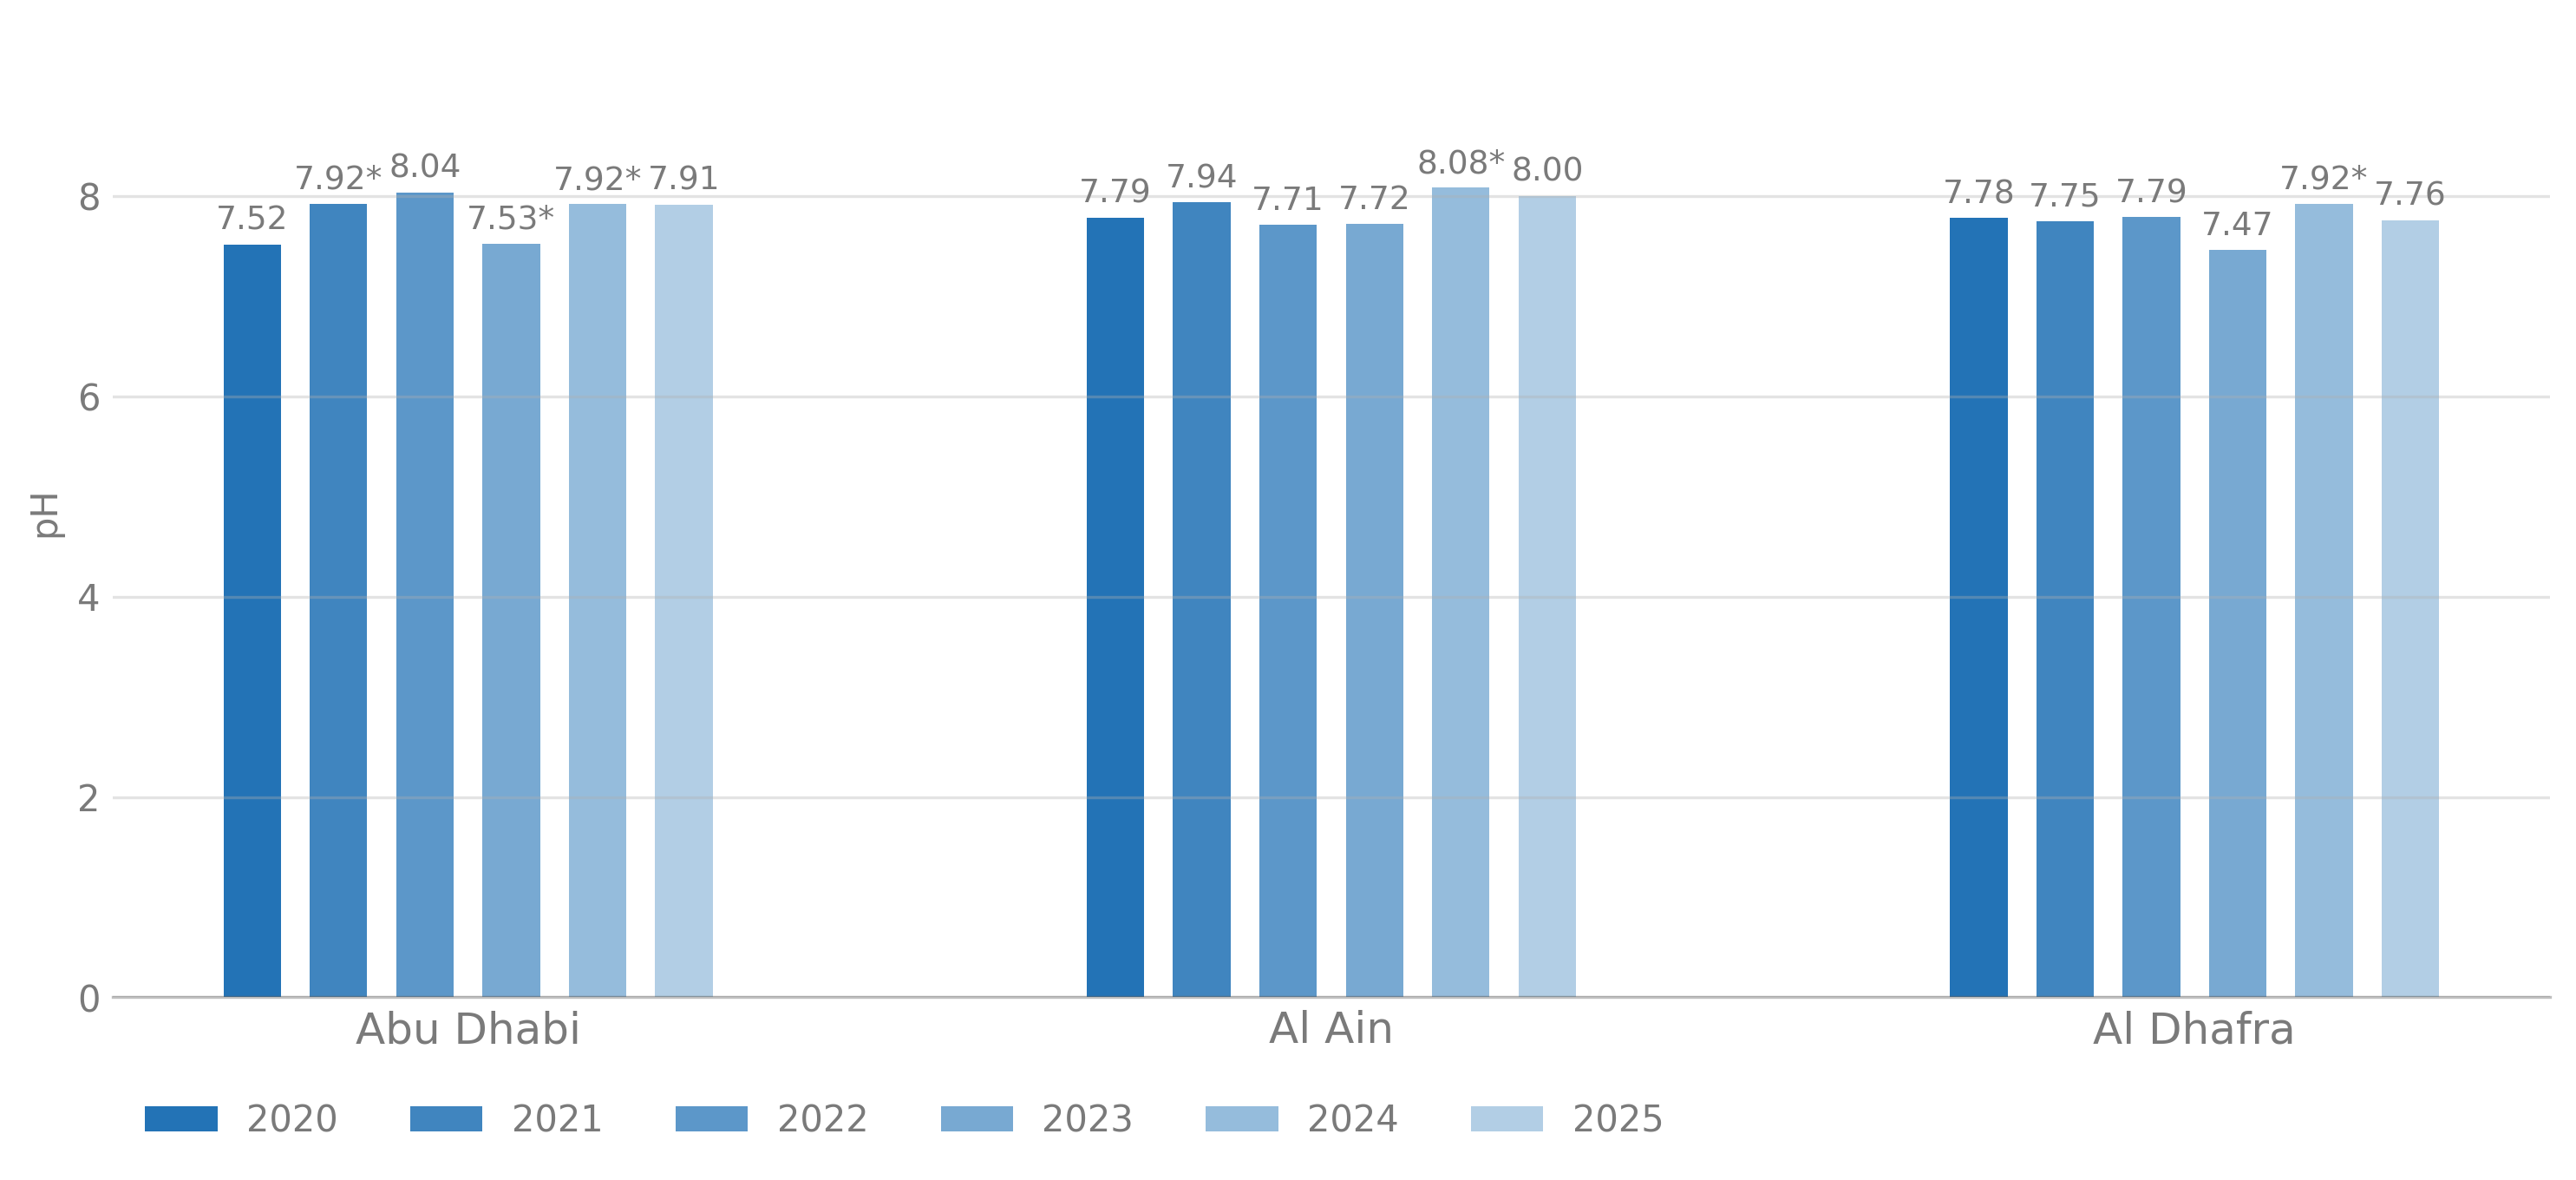

In [12]:
years = [f"Soil quality data {y}" for y in range(2020, 2026)]

ph_long = build_long_year_region(
    data_dict,
    years=years,
    table="PHChemical",
    value_col=col_name,
    survey_id=land_use_id,
    regions=regions,
)

anova_by_region, posthoc_by_region = year_anova_posthoc_by_region(ph_long)
adj_star = adjacent_sig_years_from_posthoc(ph_long, posthoc_by_region)

mean_by_region_year = (
    ph_long.groupby(["Region", "YearNum"], as_index=False)["Value"]
           .mean()
           .rename(columns={"Value": "MeanValue"})
)

fig, ax = plot_grouped_bars_years(
    mean_by_region_year,
    regions_order=regions,
    star_years=adj_star,
    ylabel=element_name,
    base_color=hex_colors[-2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_grouped_bars_years.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_grouped_bars_years.svg"), bbox_inches="tight", pad_inches=0.1)

# 1.4 Electrical Conductivity (ECe)

#### 数据读取

In [13]:
col_name = "satec"
element_name = "ECe"
df = get_table(data_dict, year, "PHChemical")
df = filter_surface_landuse_region(df, survey_id=land_use_id, regions=regions)
df

,SurveyID,SiteUID,SiteObsUID,PedonUID,PHUID,PHSampleUID,PHSubSampleUID,PHChemicalUID,Longitude,Latitude,...,satph,satec,TotalOrganicCarbon,TotalKjeldahlNitrogen_TKN,Boron \n(sat paste),Calcium \n(sat paste),Magnesium \n(sat paste),Sodium \n(sat paste),Potassium \n(sat paste),SAR
0,8,10004161220,3,2,1,1,1,1,54.374728,24.455875,...,7.8,27.600,1.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,10004121138,3,2,1,1,1,1,54.363589,24.456906,...,8.2,2.970,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,10004222728,3,2,1,1,1,1,54.360639,24.460648,...,8.2,0.984,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,10004222572,3,2,1,1,1,1,54.364432,24.461803,...,8.2,1.800,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,10004120958,8,2,1,1,1,1,54.358618,24.450317,...,7.7,21.700,1.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,8,1002326233,3,2,1,1,1,1,53.703403,23.666218,...,7.7,4.050,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,8,100135135,3,2,1,1,1,1,53.711574,23.659154,...,8.0,41.100,0.342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,8,1002311888,8,2,1,1,1,1,53.719452,23.625507,...,7.4,6.780,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,8,1002361285,3,2,1,1,1,1,53.796831,23.131239,...,7.6,3.980,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 极值点坐标

In [14]:
extreme_ph = get_extreme_point(
    df,
    value_col=col_name,
    mode="max",  # pH 取最小
)

extreme_ph

Region         Abu Dhabi
SiteUID      10004003232
Longitude      54.404153
Latitude       24.427788
Value              211.0
dtype: object

#### 描述性统计

In [15]:
df_surface = summary_by_region(df, value_col=col_name, regions=regions, landuse_name=land_use_name)
display(df_surface)

Mean ± se  Median   Min    Max   n
LandUse     Region                                          
Residential Abu Dhabi  23.48 ± 4.83    5.09  0.47  211.0  97
            Al Ain     10.26 ± 2.61    4.56  0.94   64.3  32
            Al Dhafra   9.46 ± 3.23    2.78  0.40   58.2  21

#### 显著性检验

In [16]:
samples = regional_samples(df, value_col=col_name, regions=regions)
df_post, sig_dict, all_normal = posthoc_tests(samples, regions)
display(df_post)

letters = assign_letters_from_sig(df_surface.reset_index(), sig_dict, landuse_name=land_use_name, regions=regions)
df_ph_surface_labeled = append_letters_to_summary(df_surface, letters, landuse_name=land_use_name, regions=regions)
display(df_ph_surface_labeled)

,Comparison,Test,p_raw,p_adj_holm,Significant
1,Abu Dhabi vs Al Dhafra,Mann–Whitney U,0.126808,0.380424,False
2,Al Ain vs Al Dhafra,Mann–Whitney U,0.237181,0.474363,False
0,Abu Dhabi vs Al Ain,Mann–Whitney U,0.528786,0.528786,False


Mean ± se  Median   Min    Max   n
LandUse     Region                                            
Residential Abu Dhabi  23.48 ± 4.83 a    5.09  0.47  211.0  97
            Al Ain     10.26 ± 2.61 a    4.56  0.94   64.3  32
            Al Dhafra   9.46 ± 3.23 a    2.78  0.40   58.2  21

#### 分级表 + 堆叠图

Percentage (%)  Count
Region    Class                                                 
Abu Dhabi Non-Saline (<2 dS/m)                       26.8     26
          Very Slightly Saline (2–4 dS/m)            18.6     18
          Slightly Saline (4–8 dS/m)                 10.3     10
          Moderately Saline (8–16 dS/m)              14.4     14
          Very Strongly Saline (>16 dS/m)            29.9     29
Al Ain    Non-Saline (<2 dS/m)                       15.6      5
          Very Slightly Saline (2–4 dS/m)            25.0      8
          Slightly Saline (4–8 dS/m)                 31.2     10
          Moderately Saline (8–16 dS/m)               6.2      2
          Very Strongly Saline (>16 dS/m)            21.9      7
Al Dhafra Non-Saline (<2 dS/m)                       38.1      8
          Very Slightly Saline (2–4 dS/m)            19.0      4
          Slightly Saline (4–8 dS/m)                 14.3      3
          Moderately Saline (8–16 dS/m)               9.5      2
          Very Strongly Saline (>16 dS/m)            19.0      4

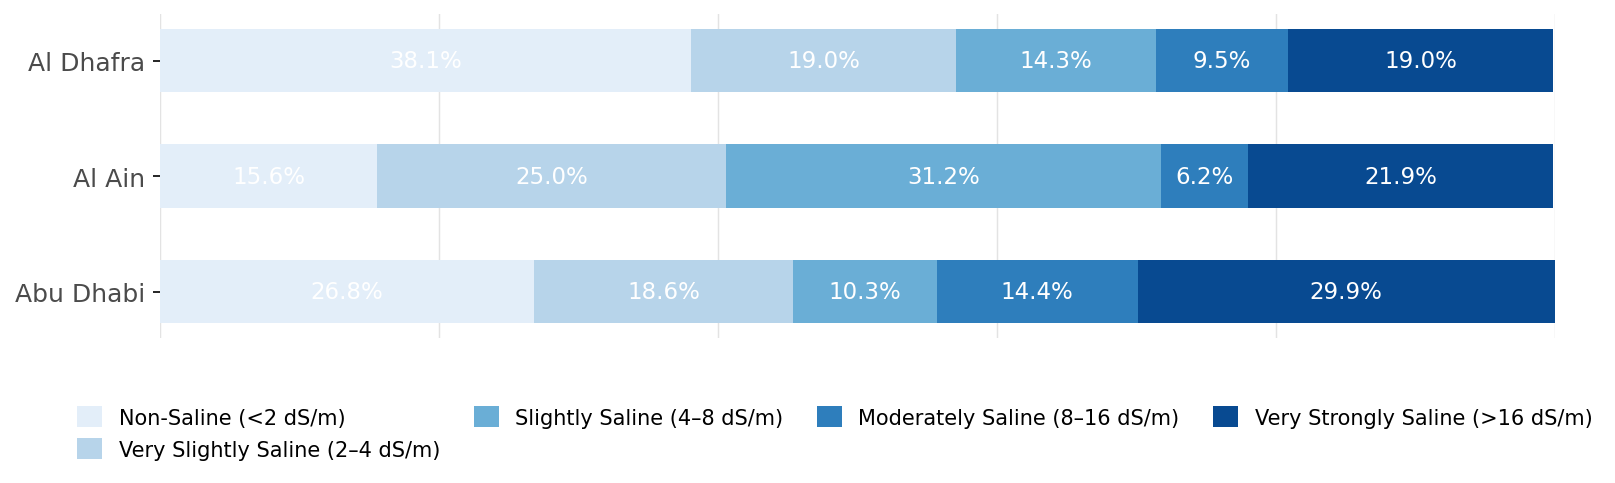

In [17]:
bins = [
    (-float("inf"), 2.0,    "Non-Saline (<2 dS/m)"),
    (2.0, 4.0,             "Very Slightly Saline (2–4 dS/m)"),
    (4.0, 8.0,             "Slightly Saline (4–8 dS/m)"),
    (8.0, 16.0,            "Moderately Saline (8–16 dS/m)"),
    (16.0, float("inf"),   "Very Strongly Saline (>16 dS/m)"),
]

df_ph_class = class_distribution_by_region(df, value_col=col_name, bins=bins, regions=regions, right_inclusive= False)
display(df_ph_class)
class_order = [
    "Non-Saline (<2 dS/m)",
    "Very Slightly Saline (2–4 dS/m)",
    "Slightly Saline (4–8 dS/m)",
    "Moderately Saline (8–16 dS/m)",
    "Very Strongly Saline (>16 dS/m)",
]

cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
n = len(class_order)
values = np.linspace(0.1, 0.9, n)  # 避开两端极端色
hex_colors = [to_hex(cmap(v)) for v in values]
colors = dict(zip(class_order, hex_colors))

fig, ax = plot_stacked_percent_barh(
    df_ph_class,
    regions_order=regions,
    class_order=class_order,
    colors=colors,
    label_min=3.0,
    legend_ncol=4
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_stacked_percent_barh.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_stacked_percent_barh.svg"), bbox_inches="tight", pad_inches=0.1)

#### 箱线图 + 散点 + 均值

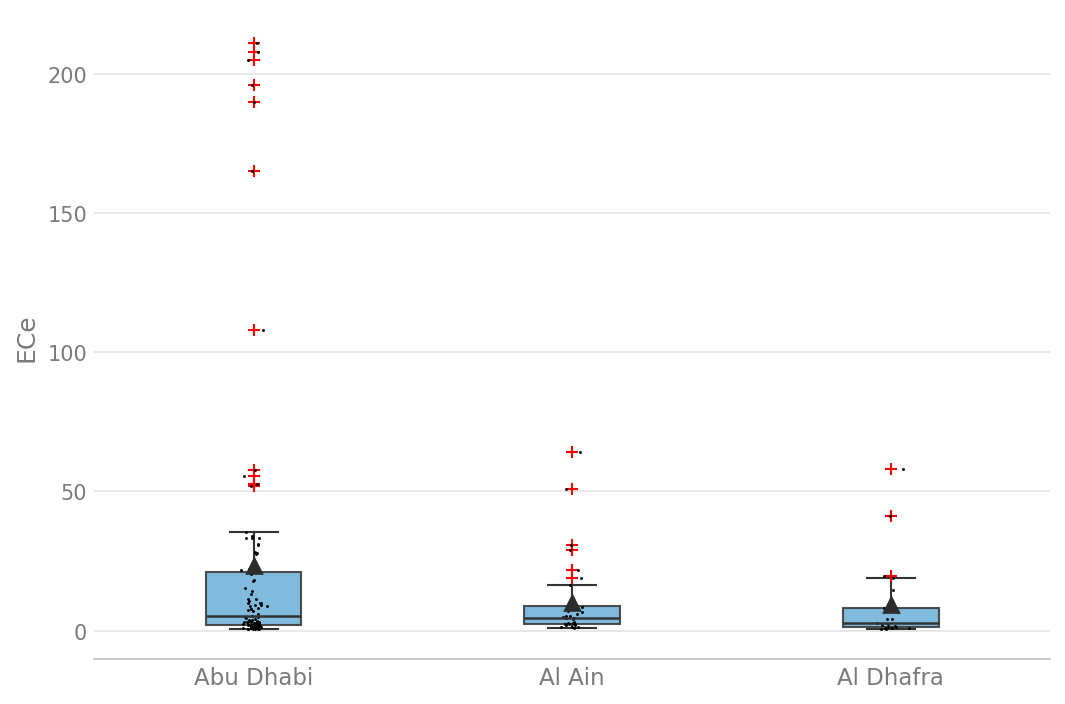

In [18]:
fig, ax = plot_box_jitter_mean(
    df, value_col=col_name,
    regions_order=regions,
    ylabel=element_name,
    exclude_below=None,
    facecolor=hex_colors[2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_box_jitter_mean.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_box_jitter_mean.svg"), bbox_inches="tight", pad_inches=0.1)

#### 单年均值柱形图

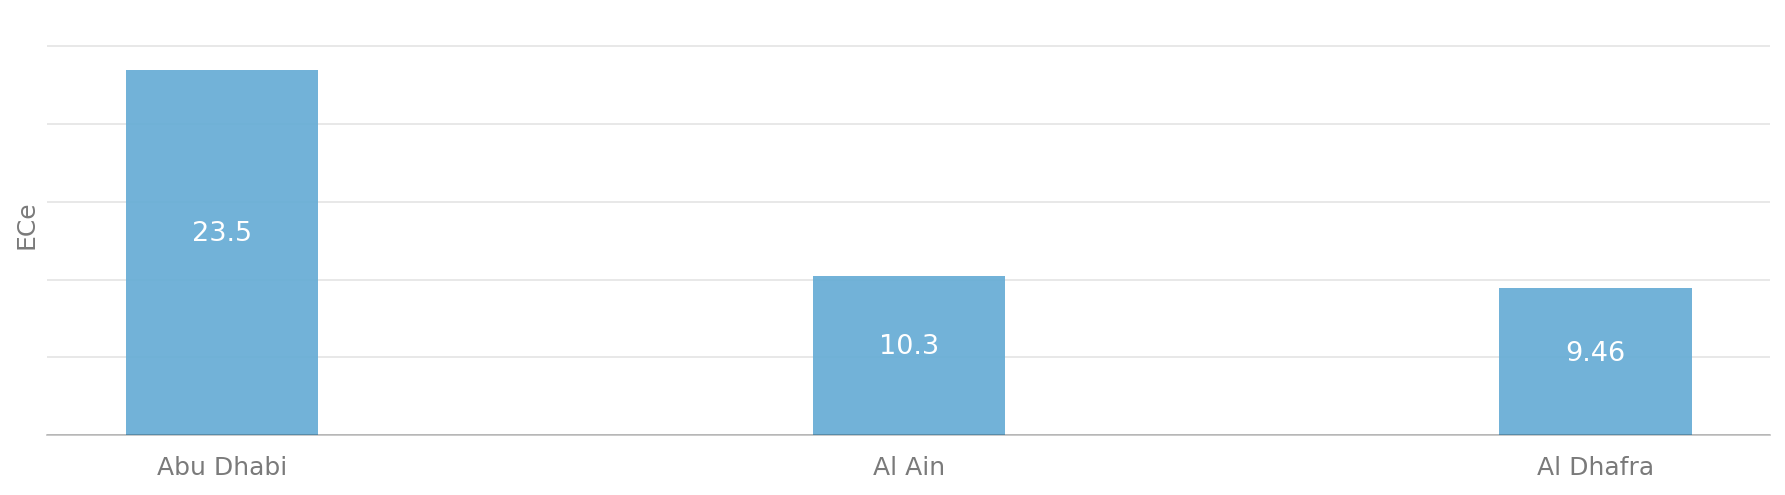

In [19]:
PH_PALETTE = {
    "base": hex_colors[2],
    "edge": "#C79A78",
    "mean": "#2C2C2C",
    "scatter": "#000000",
    "value_text": "white",
}

fig, ax = plot_mean_bar_single_year(
    df_surface,                       # 你前面算出来的 summary 表
    regions=regions,
    landuse_name=land_use_name,
    palette=PH_PALETTE,
    ylabel=element_name,
    legend=False,
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_mean_bar_single_year.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_mean_bar_single_year.svg"), bbox_inches="tight", pad_inches=0.1)

#### 2020–2025 年度趋势

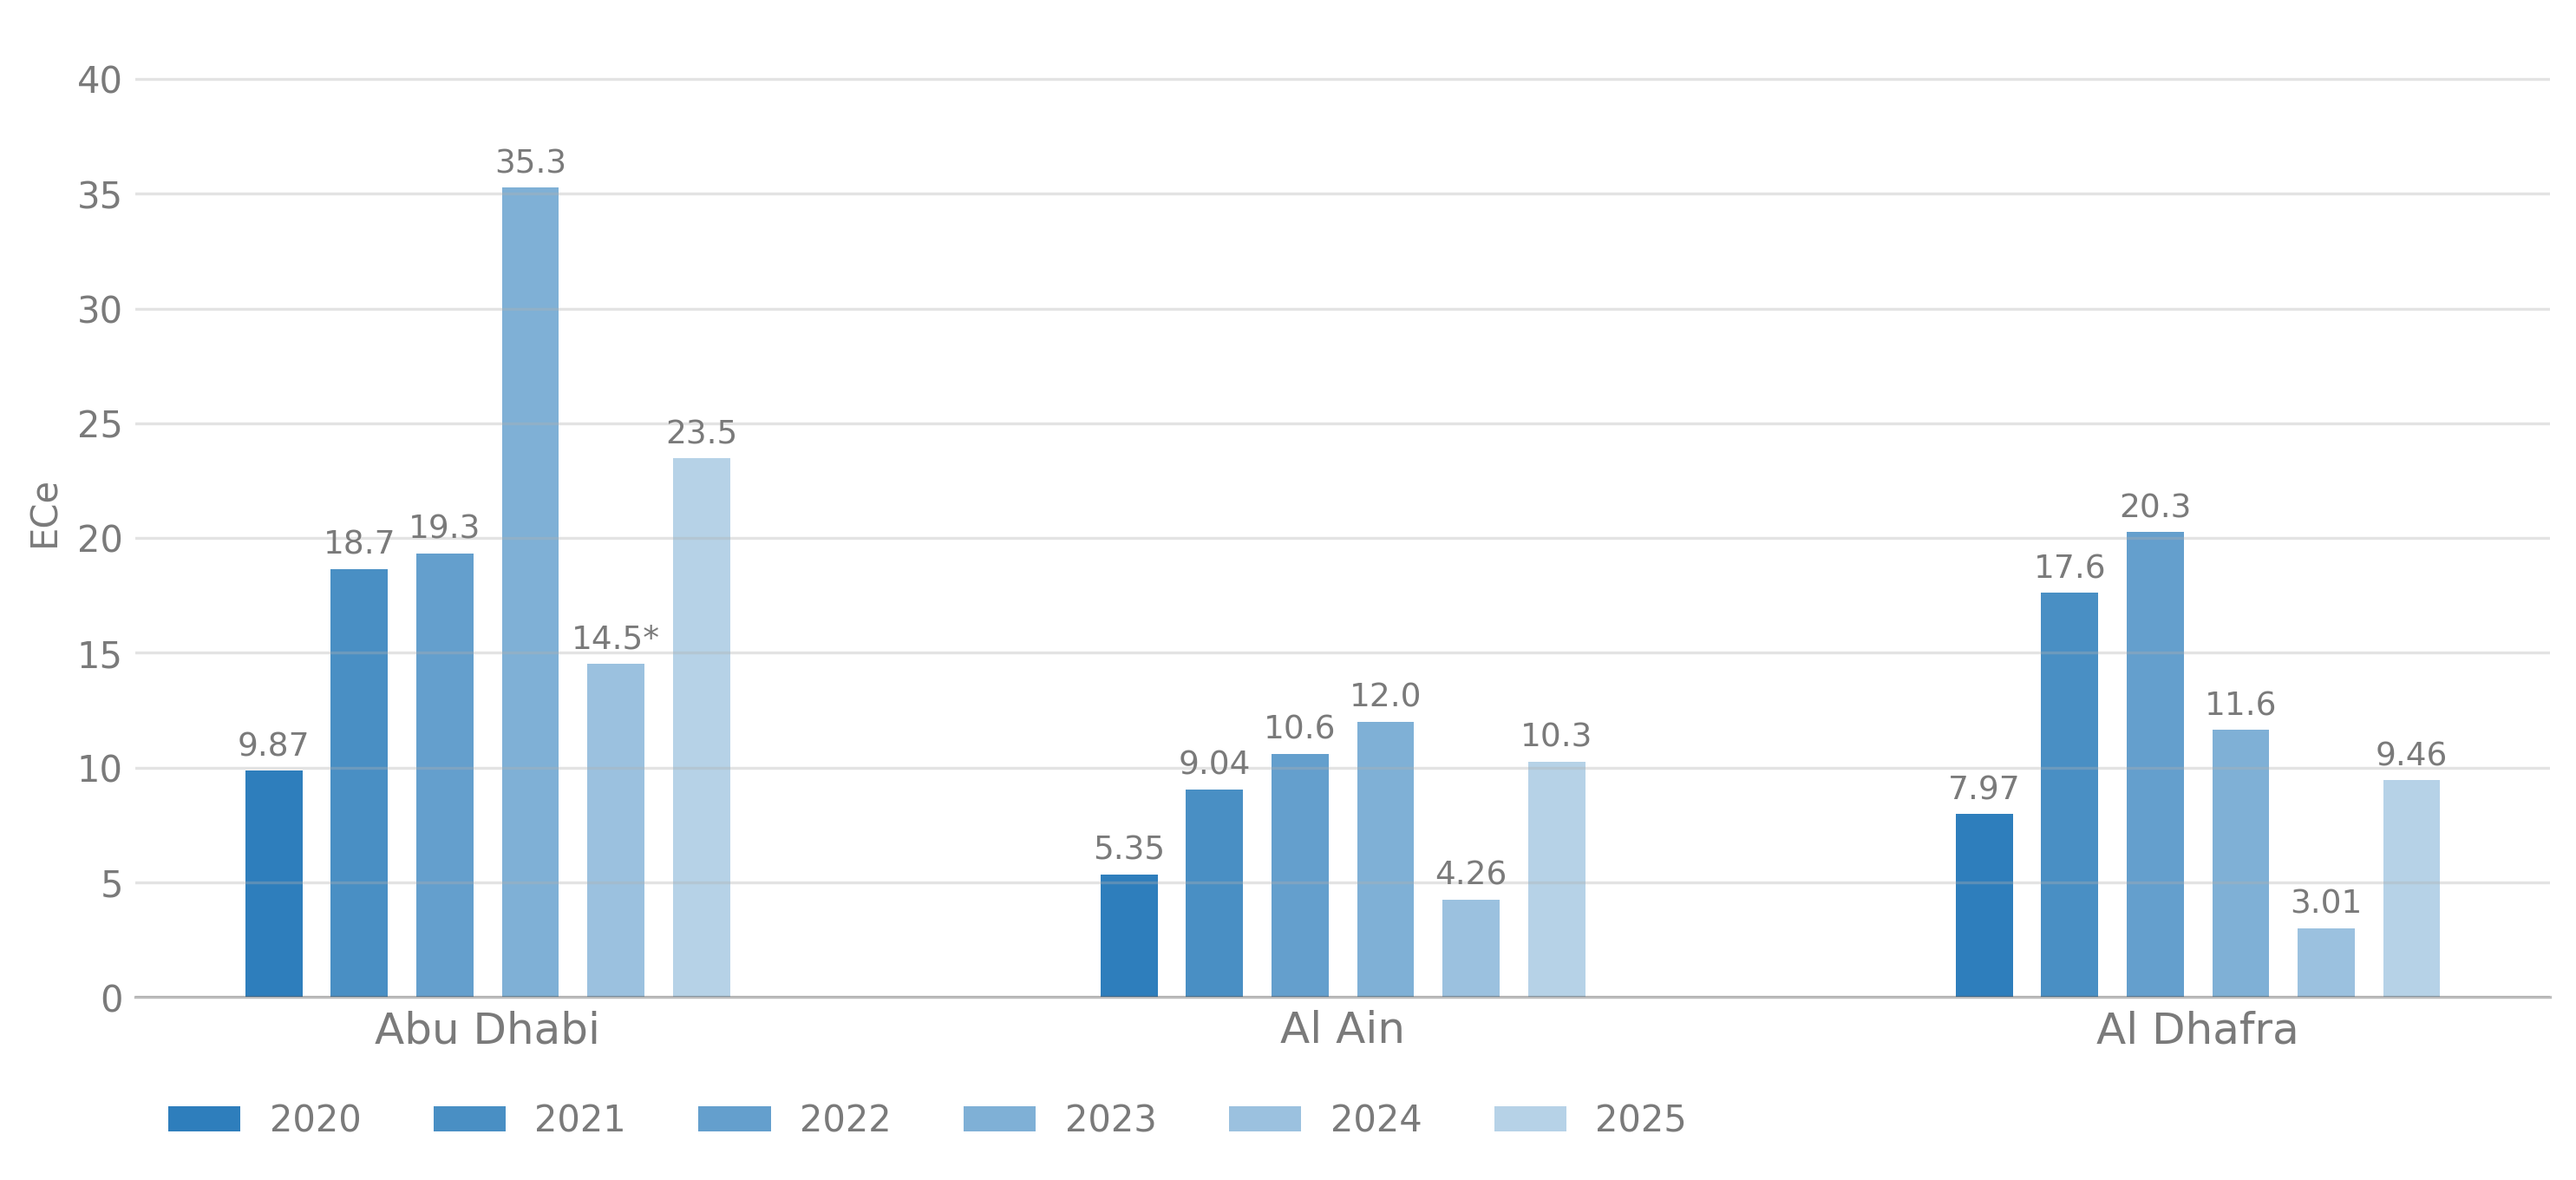

In [20]:
years = [f"Soil quality data {y}" for y in range(2020, 2026)]

ph_long = build_long_year_region(
    data_dict,
    years=years,
    table="PHChemical",
    value_col=col_name,
    survey_id=land_use_id,
    regions=regions,
)

anova_by_region, posthoc_by_region = year_anova_posthoc_by_region(ph_long)
adj_star = adjacent_sig_years_from_posthoc(ph_long, posthoc_by_region)

mean_by_region_year = (
    ph_long.groupby(["Region", "YearNum"], as_index=False)["Value"]
           .mean()
           .rename(columns={"Value": "MeanValue"})
)

fig, ax = plot_grouped_bars_years(
    mean_by_region_year,
    regions_order=regions,
    star_years=adj_star,
    ylabel=element_name,
    base_color=hex_colors[-2]
)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_grouped_bars_years.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_grouped_bars_years.svg"), bbox_inches="tight", pad_inches=0.1)

# 2 Inorganic Parameters - Heavy Metals

In [21]:
from pathlib import Path
def classify_low_med_high(
    x: pd.Series,
    *,
    abl: float,
    ssl: float,
) -> pd.Series:
    """
    Return category labels in {"Low","Medium","High"} (Medium may not appear if abl>=ssl).
    NaN stays NaN.
    """
    x = pd.to_numeric(x, errors="coerce")

    cat = pd.Series(index=x.index, dtype="object")

    if abl >= ssl:
        cat.loc[x <= abl] = "Low"
        cat.loc[x >  abl] = "High"
    else:
        cat.loc[x <= abl] = "Low"
        cat.loc[(x > abl) & (x <= ssl)] = "Medium"
        cat.loc[x > ssl] = "High"

    return cat
def threshold_class_pct_by_region(
    df: pd.DataFrame,
    *,
    value_col: str,
    abl: float,
    ssl: float,
    regions: list[str],
    region_col: str = "Location",
    site_id_col: str | None = None,   # 例如 "SiteUID"，用于按站点去重
    include_emirate: bool = True,
    round_digits: int = 0,
) -> pd.DataFrame:
    """
    Return DataFrame: index=Region (plus Emirate), columns=["High","Medium","Low"] (missing filled with 0)
    Values are percentages summing to 100 per row (within rounding error).
    """
    base = df.copy()

    # 分类
    base["_cat_"] = classify_low_med_high(base[value_col], abl=abl, ssl=ssl)

    rows = []

    def _region_block(sub: pd.DataFrame, region_name: str):
        if site_id_col:
            # 站点口径：每个站点只算一次（如同一站点多个样品，可按“最大类别”原则）
            # 最大类别：High > Medium > Low
            rank = {"Low": 0, "Medium": 1, "High": 2}
            tmp = sub[[site_id_col, "_cat_"]].dropna()
            if tmp.empty:
                counts = {"High": 0, "Medium": 0, "Low": 0}
            else:
                tmp["_rank_"] = tmp["_cat_"].map(rank)
                # 每站点取最大 rank
                site_rank = tmp.groupby(site_id_col)["_rank_"].max()
                site_cat = site_rank.map({v: k for k, v in rank.items()})
                counts = site_cat.value_counts().to_dict()
        else:
            # 样品口径：按记录数统计
            tmp = sub["_cat_"].dropna()
            counts = tmp.value_counts().to_dict()

        n = sum(counts.get(k, 0) for k in ["High", "Medium", "Low"])
        if n == 0:
            pct = {"High": 0.0, "Medium": 0.0, "Low": 0.0}
        else:
            pct = {k: counts.get(k, 0) / n * 100 for k in ["High", "Medium", "Low"]}

        rows.append({"Region": region_name, **pct})

    # 分地区
    for r in regions:
        sub = base[base[region_col] == r]
        _region_block(sub, r)

    # Emirate（总体）
    if include_emirate:
        _region_block(base[base[region_col].isin(regions)], "Emirate")

    out = pd.DataFrame(rows).set_index("Region")

    # 对齐列：若 abl>=ssl，则 Medium 会全 0，但我们仍保留列，便于画图一致
    for c in ["High", "Medium", "Low"]:
        if c not in out.columns:
            out[c] = 0.0
    out = out[["High", "Medium", "Low"]]

    # 取整/保留小数
    out = out.round(round_digits)
    return out
def plot_threshold_stack_pct(
    pct_df: pd.DataFrame,
    *,
    order: list[str],
    palette: dict,
    ylabel: str = "Percentage of sites (%)",
    figsize=(6.2, 4.2),
    dpi=150,
    label_min: float = 1.0,
    show_legend: bool = True,
    legend_loc: str = "lower left",
):
    """
    100% 堆叠矩形柱（Low / Medium / High）
    轴样式与 plot_mean_bar_single_year 保持一致
    """

    df = pct_df.reindex(order).fillna(0.0)

    colors = {
        "Low": palette.get("Low", "#AFC7CE"),
        "Medium": palette.get("Medium", "#5F9EA0"),
        "High": palette.get("High", "#2F5D62"),
    }
    text_c = palette.get("text", "white")
    grid_alpha = palette.get("grid_alpha", 0.35)

    x = np.arange(len(order))
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    bottom = np.zeros(len(order), dtype=float)

    # =========================
    # 堆叠柱：Low -> Medium -> High
    # =========================
    for cls in ["Low", "Medium", "High"]:
        vals = df[cls].to_numpy(dtype=float)

        ax.bar(
            x,
            vals,
            bottom=bottom,
            width=0.45,
            color=colors[cls],
            edgecolor="none",
            alpha=1.0,
        )

        # 段内百分比
        for i, v in enumerate(vals):
            if v >= label_min:
                ax.text(
                    x[i],
                    bottom[i] + v / 2,
                    f"{v:.0f}%",
                    ha="center",
                    va="center",
                    fontsize=10,
                    color=text_c,
                )

        bottom += vals

    # =========================
    # 坐标轴样式（完全对齐 plot_mean_bar_single_year）
    # =========================
    ax.set_xticks(x)
    ax.set_xticklabels(order, fontsize=10, color="#7A7A7A")

    ax.set_ylim(0, 100)
    ax.set_ylabel(ylabel, fontsize=11, color="#7A7A7A")

    # 网格
    ax.yaxis.grid(True, linestyle="-", linewidth=0.8, alpha=grid_alpha)
    ax.set_axisbelow(True)

    # —— 关键三点 —— #
    ax.spines["left"].set_visible(False)     # 左轴删掉
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_alpha(0.25)      # 底轴透明度 0.25

    ax.tick_params(                           # 所有刻度去掉
        axis="both",
        which="both",
        length=0,
        labelleft=False,
    )

    # =========================
    # Legend
    # =========================
    if show_legend:
        # fig.subplots_adjust(bottom=0.25)
        handles = [
            Patch(facecolor=colors["High"], label="High"),
            Patch(facecolor=colors["Medium"], label="Medium"),
            Patch(facecolor=colors["Low"], label="Low"),
        ]
        ax.legend(
            handles=handles,
            frameon=False,
            loc="lower left",
            bbox_to_anchor=(0.02, -0.20),
            ncol=3,
        )

    plt.tight_layout()
    plt.show()
    return fig, ax
def load_qc_processed_data(
    *,
    qc_dir: str | Path,
    year: int,
    sheet_name: str = "Processed_Data",
    phuid: int = 1,
    phsampleuid: int = 1,
) -> pd.DataFrame:
    """
    读取单年 QC 文件的 Processed_Data，并做最基本的 Surface 样品筛选。
    文件名默认：Soil quality data QC {year}.xlsx
    """
    qc_dir = Path(qc_dir)
    fp = qc_dir / f"Soil quality data QC {year}.xlsx"

    df = pd.read_excel(fp, sheet_name=sheet_name)

    # Surface + 目标样品（与你现有逻辑一致）
    if "PHUID" in df.columns:
        df = df[df["PHUID"] == phuid]
    if "PHSampleUID" in df.columns:
        df = df[df["PHSampleUID"] == phsampleuid]

    return df
def build_long_year_region_from_qc(
    *,
    qc_dir: str | Path,
    years: list[int],
    value_col: str,
    survey_id: int,
    regions: list[str],
    region_col: str = "Location",
    sheet_name: str = "Processed_Data",
    landuse_col: str = "SurveyID",
    phuid: int = 1,
    phsampleuid: int = 1,
) -> pd.DataFrame:
    """
    从 2020–2025 的 QC 文件批量读取元素列，拼成长表：
    columns: ["YearNum","Region","Value"]
    """
    records = []

    for y in years:
        df = load_qc_processed_data(
            qc_dir=qc_dir,
            year=y,
            sheet_name=sheet_name,
            phuid=phuid,
            phsampleuid=phsampleuid,
        )

        # land use + region 过滤（等价于你原来的 filter_surface_landuse_region）
        df = df[df[landuse_col] == survey_id]
        df = df[df[region_col].isin(regions)]

        if value_col not in df.columns:
            continue

        # 取值列
        x = pd.to_numeric(df[value_col], errors="coerce")
        out = pd.DataFrame({
            "YearNum": y,
            "Region": df[region_col].astype(str),
            "Value": x,
        }).dropna(subset=["Value"])

        records.append(out)

    if not records:
        return pd.DataFrame(columns=["YearNum", "Region", "Value"])

    return pd.concat(records, ignore_index=True)


In [22]:
cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
n = 3
values = np.linspace(0.3, 0.7, n)  # 避开两端极端色
hex_colors = [to_hex(cmap(v)) for v in values]

Arsenic


Mean ± se  Median   Min   Max   n
LandUse     Region                                          
Residential Abu Dhabi  1.53 ± 0.04 b    1.40  0.96  2.89  97
            Al Ain     1.67 ± 0.05 a    1.65  1.23  2.30  32
            Al Dhafra  1.55 ± 0.06 a    1.50  1.05  2.18  21

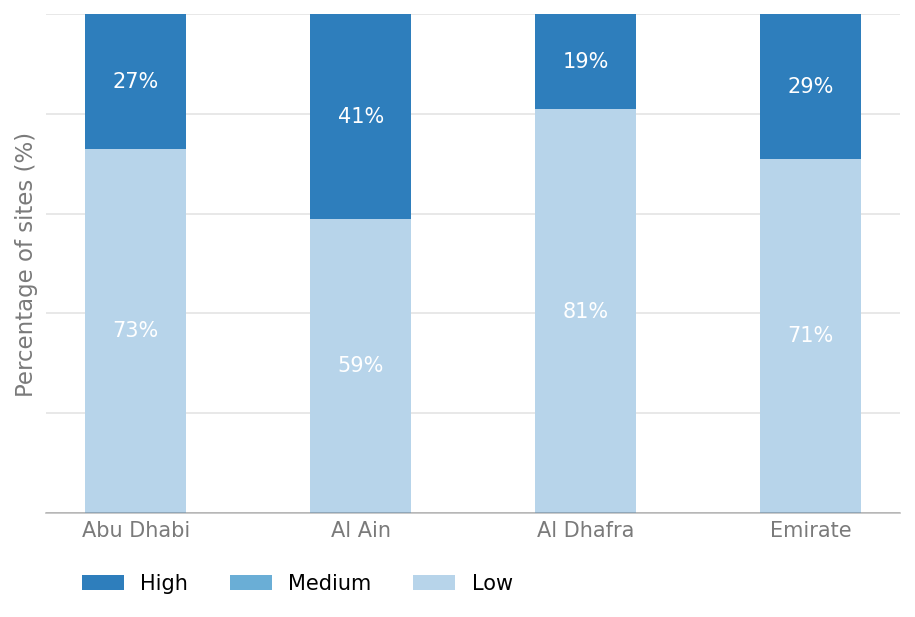

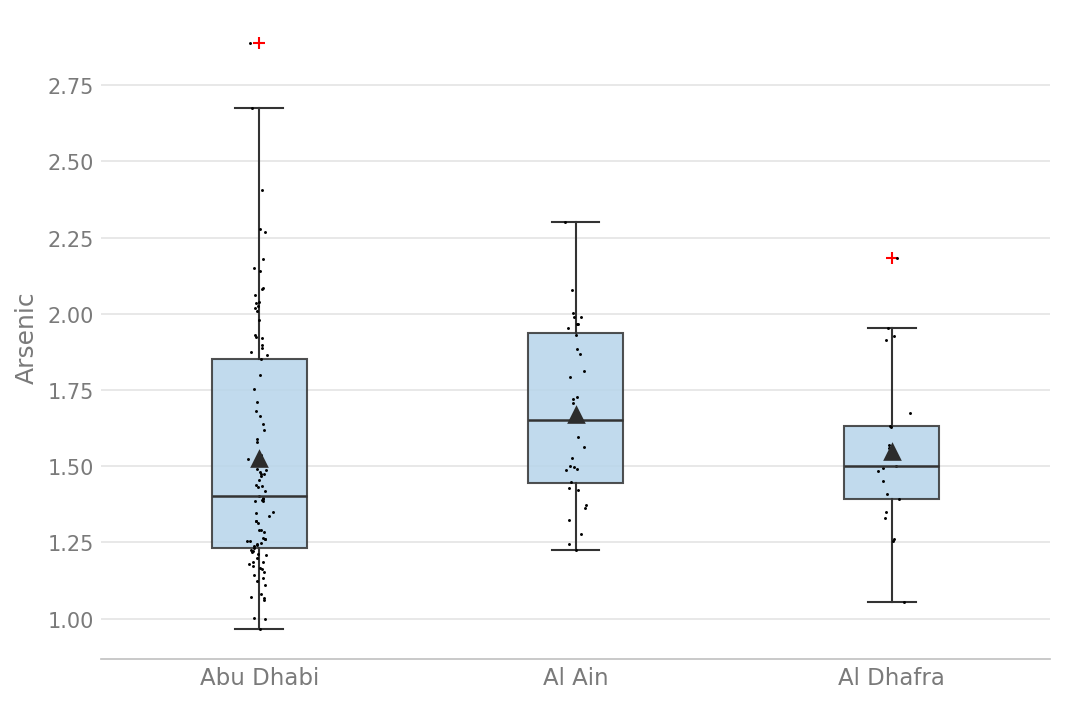

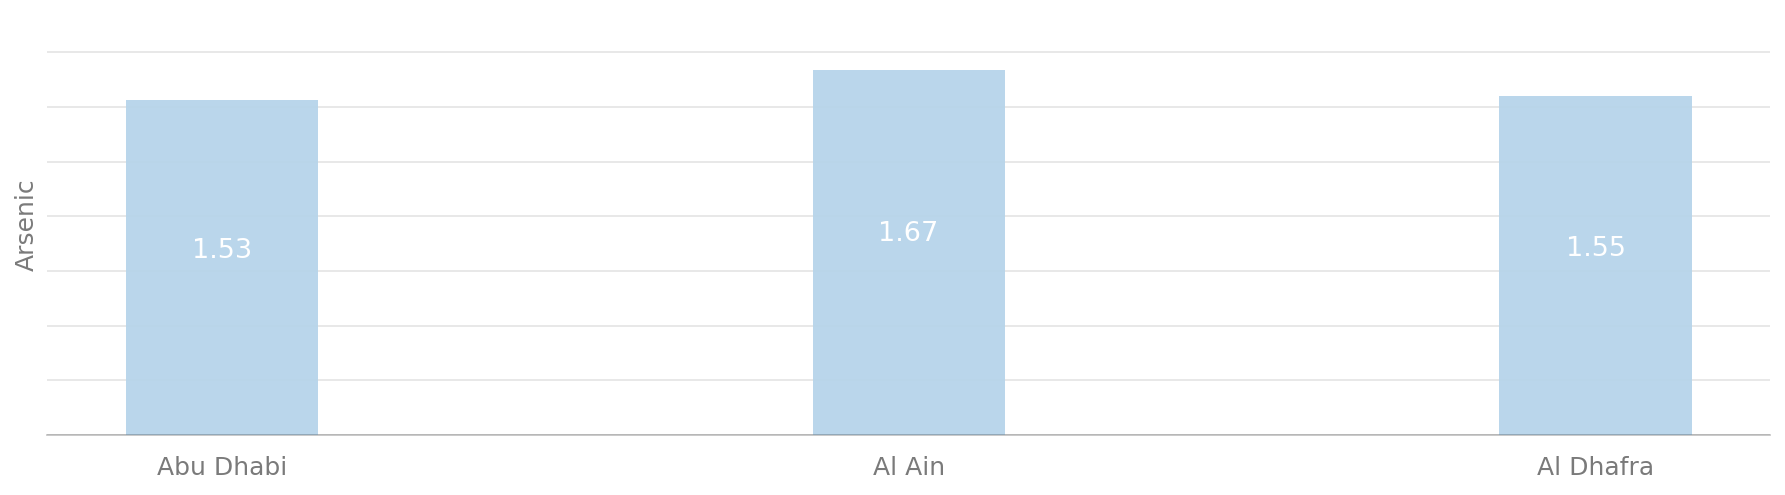

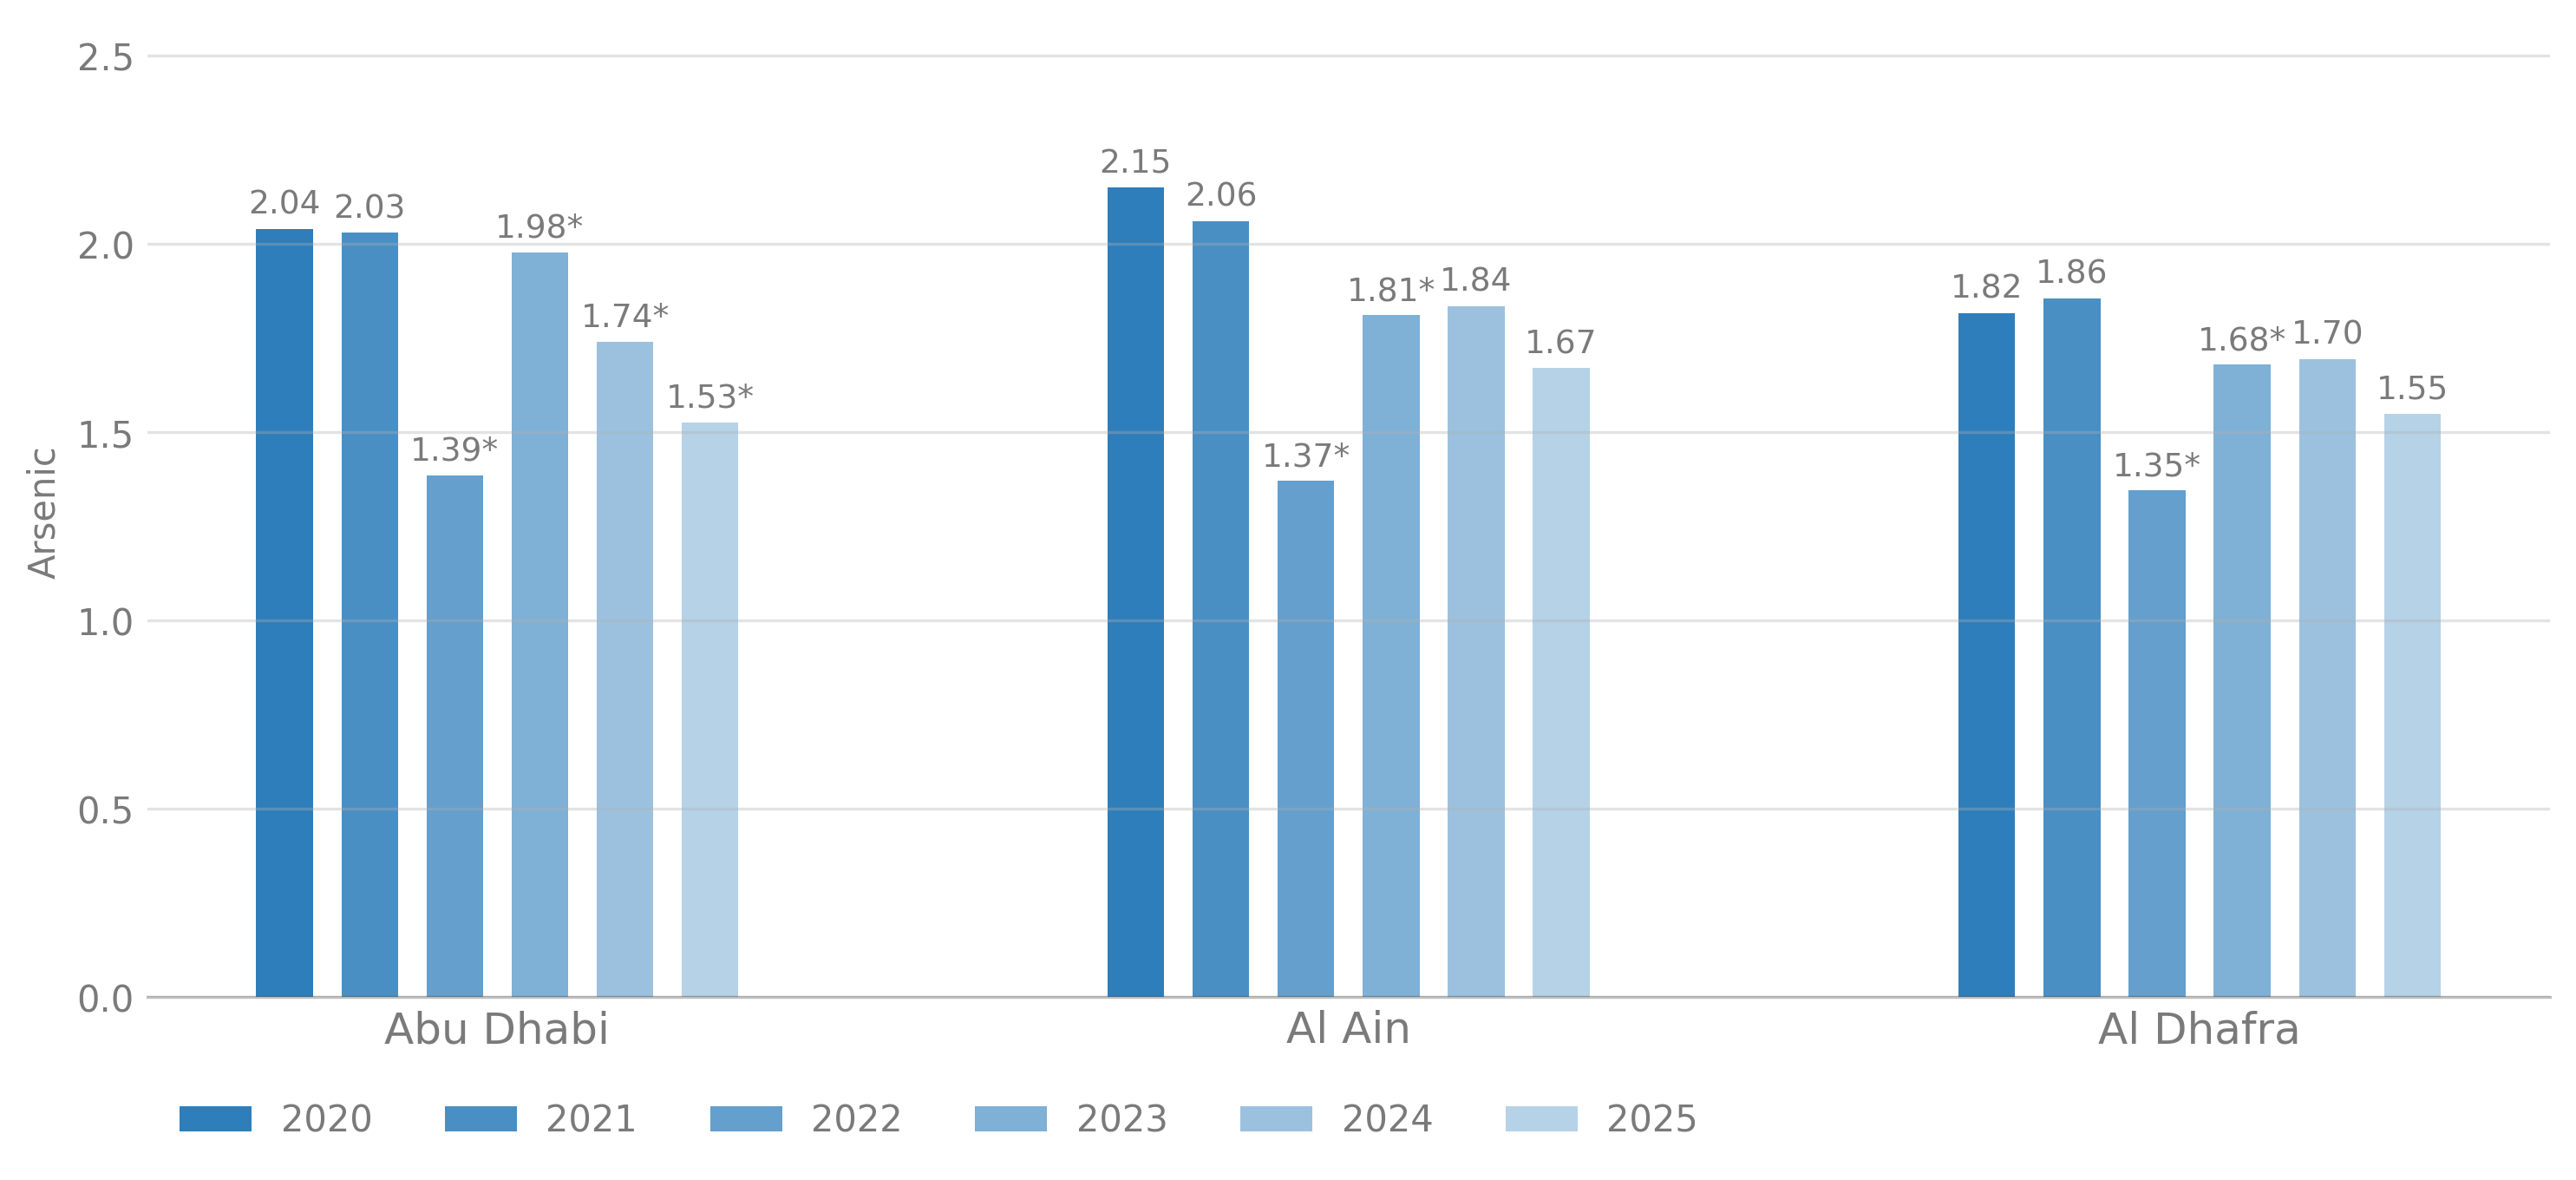

Cadmium


Mean ± se  Median   Min   Max   n
LandUse     Region                                          
Residential Abu Dhabi  0.12 ± 0.01 a    0.10  0.05  0.39  95
            Al Ain     0.10 ± 0.01 b    0.09  0.06  0.22  32
            Al Dhafra  0.08 ± 0.00 c    0.07  0.05  0.12  21

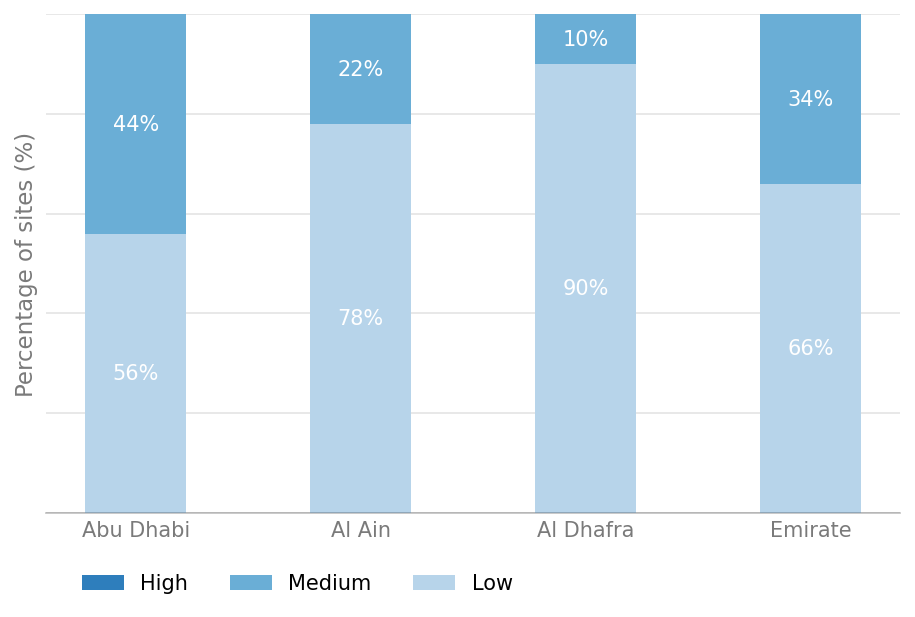

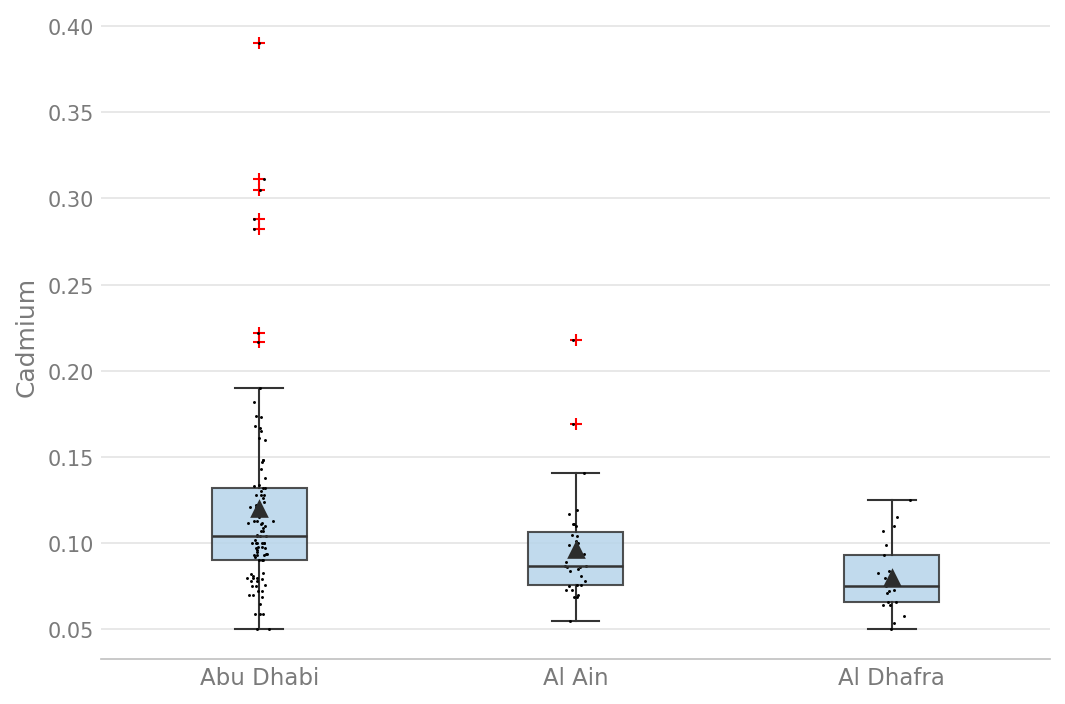

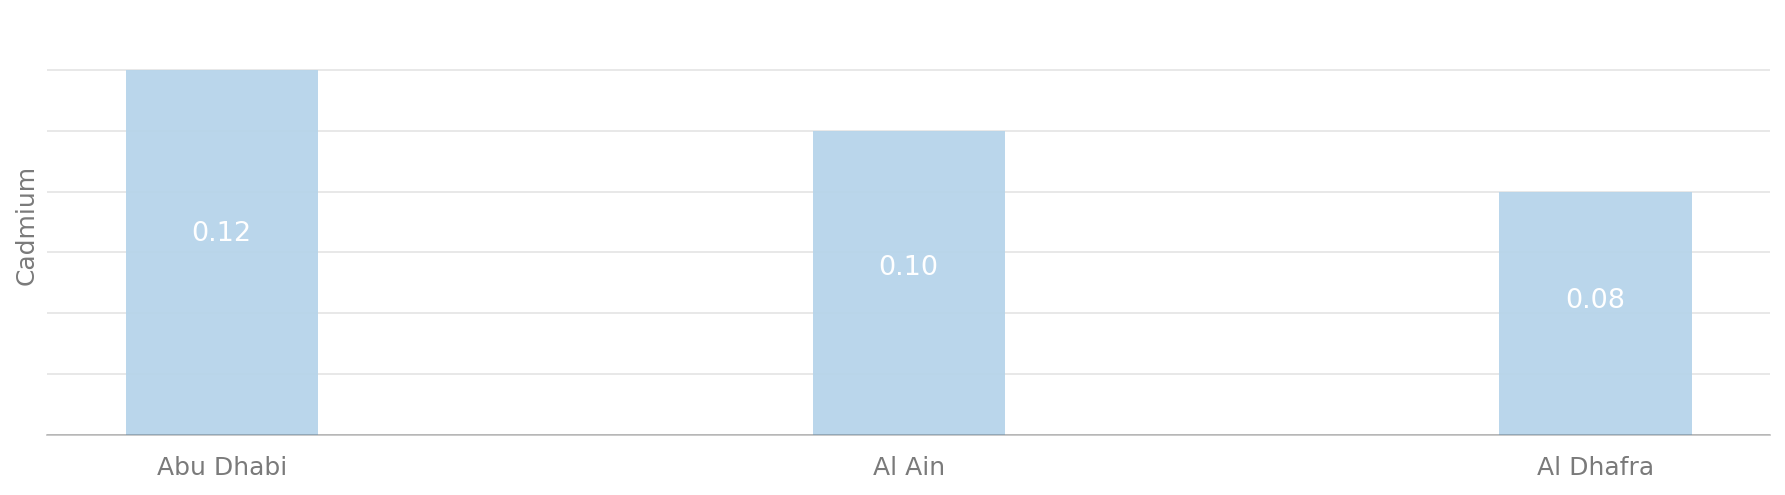

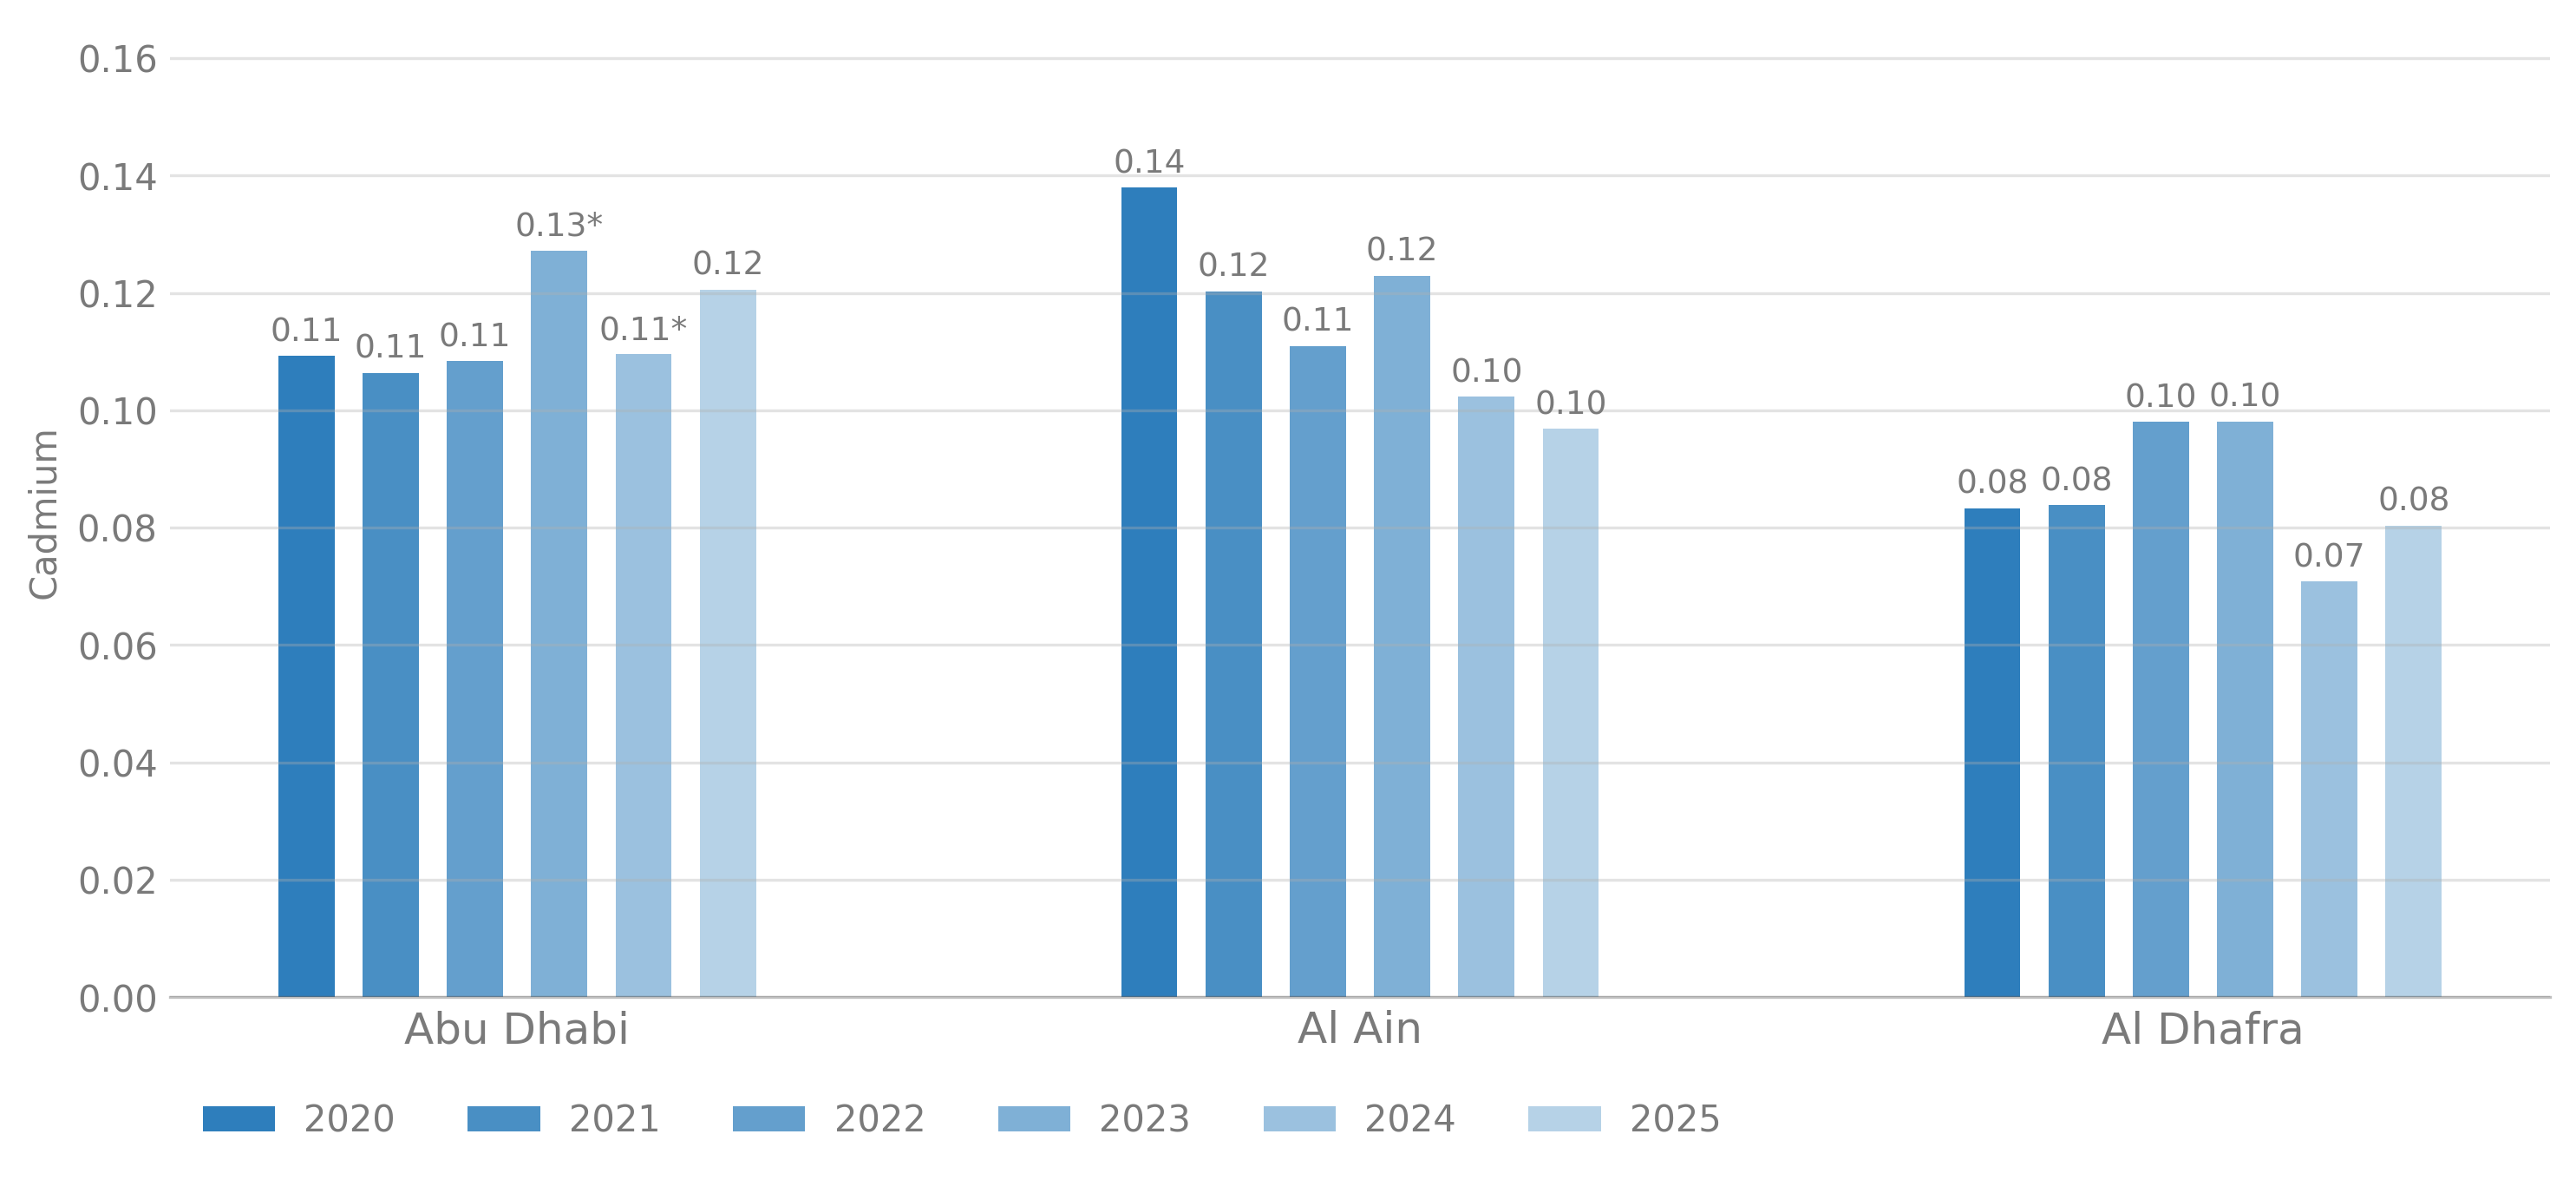

Cobalt


Mean ± se  Median   Min    Max   n
LandUse     Region                                           
Residential Abu Dhabi  4.16 ± 0.27 b    3.20  1.74  16.59  97
            Al Ain     5.32 ± 0.61 a    3.88  2.50  15.34  30
            Al Dhafra  3.23 ± 0.52 c    2.57  1.69  12.65  21

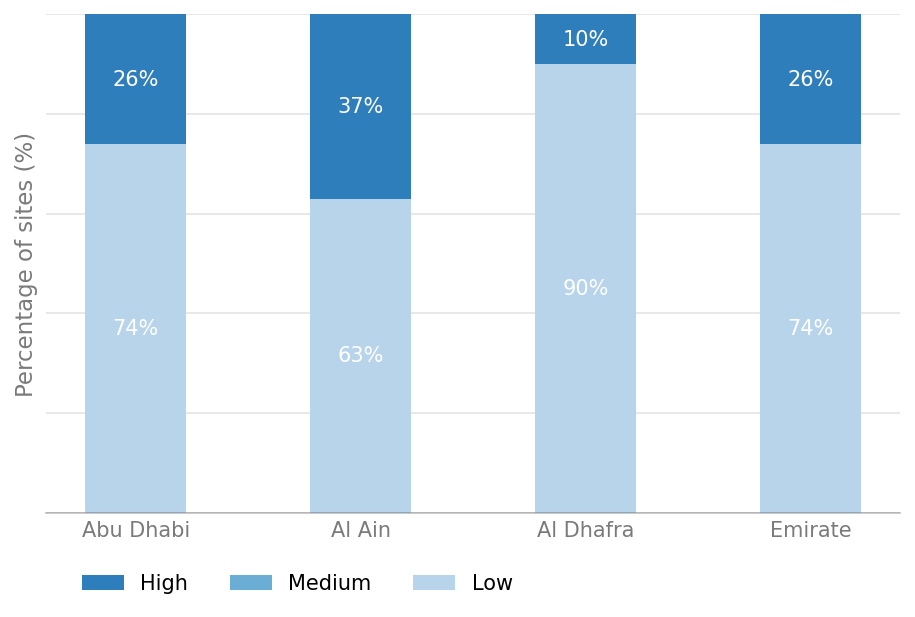

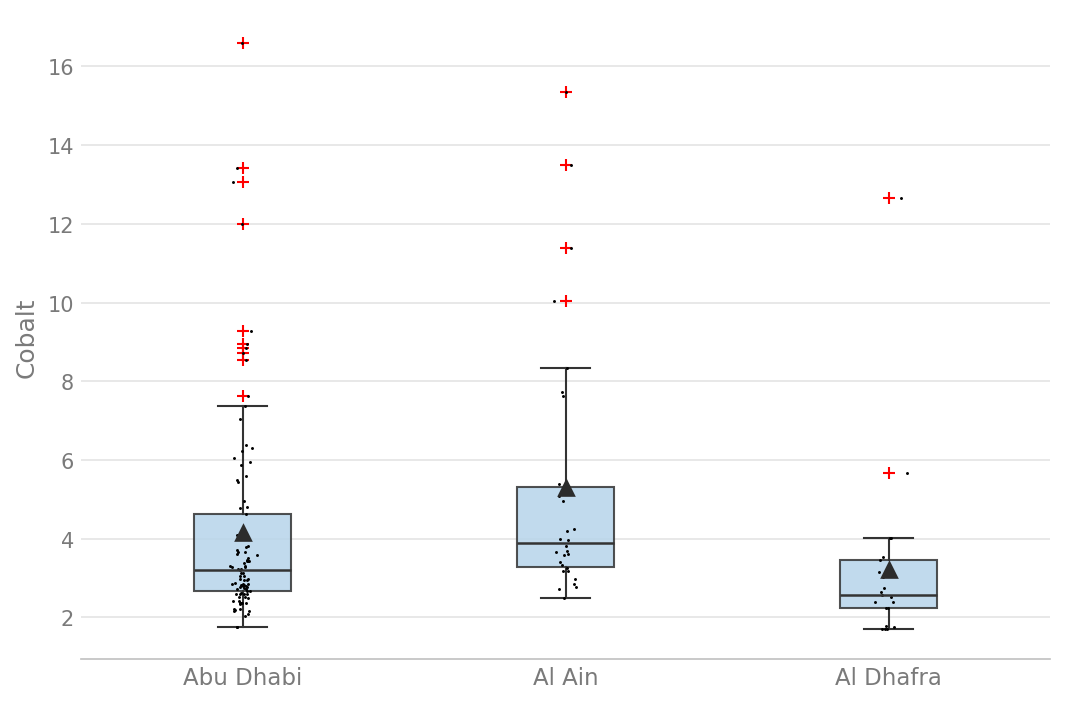

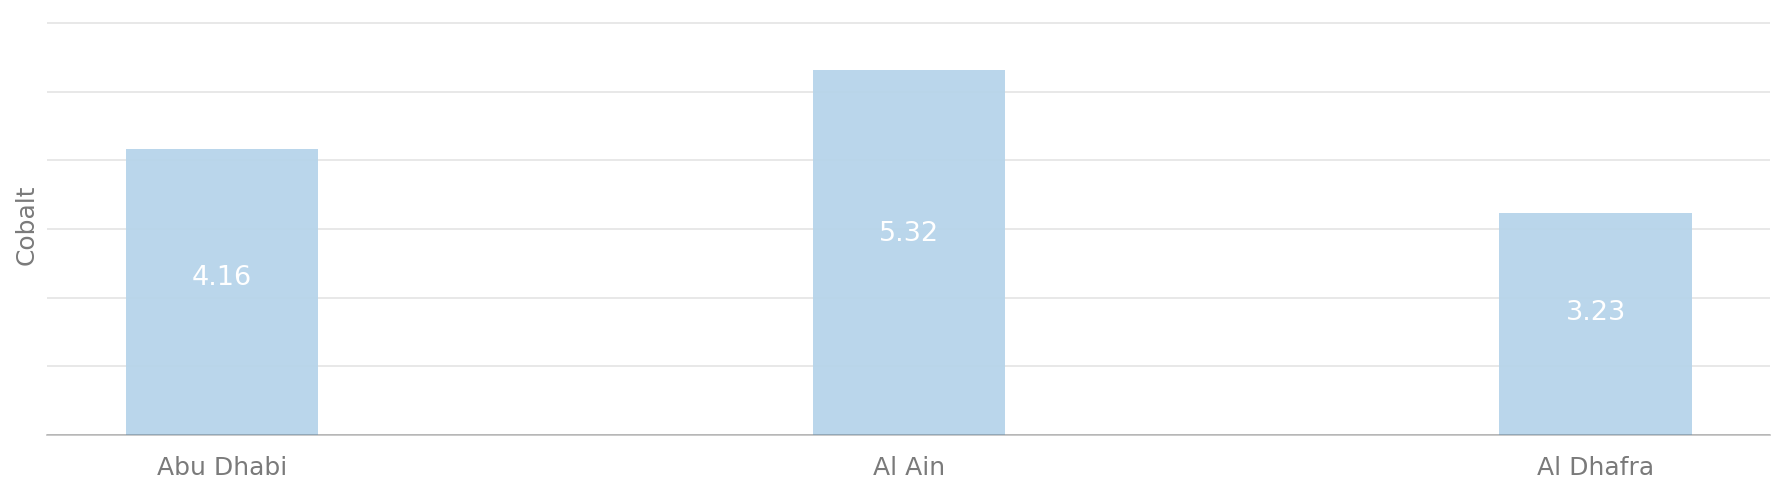

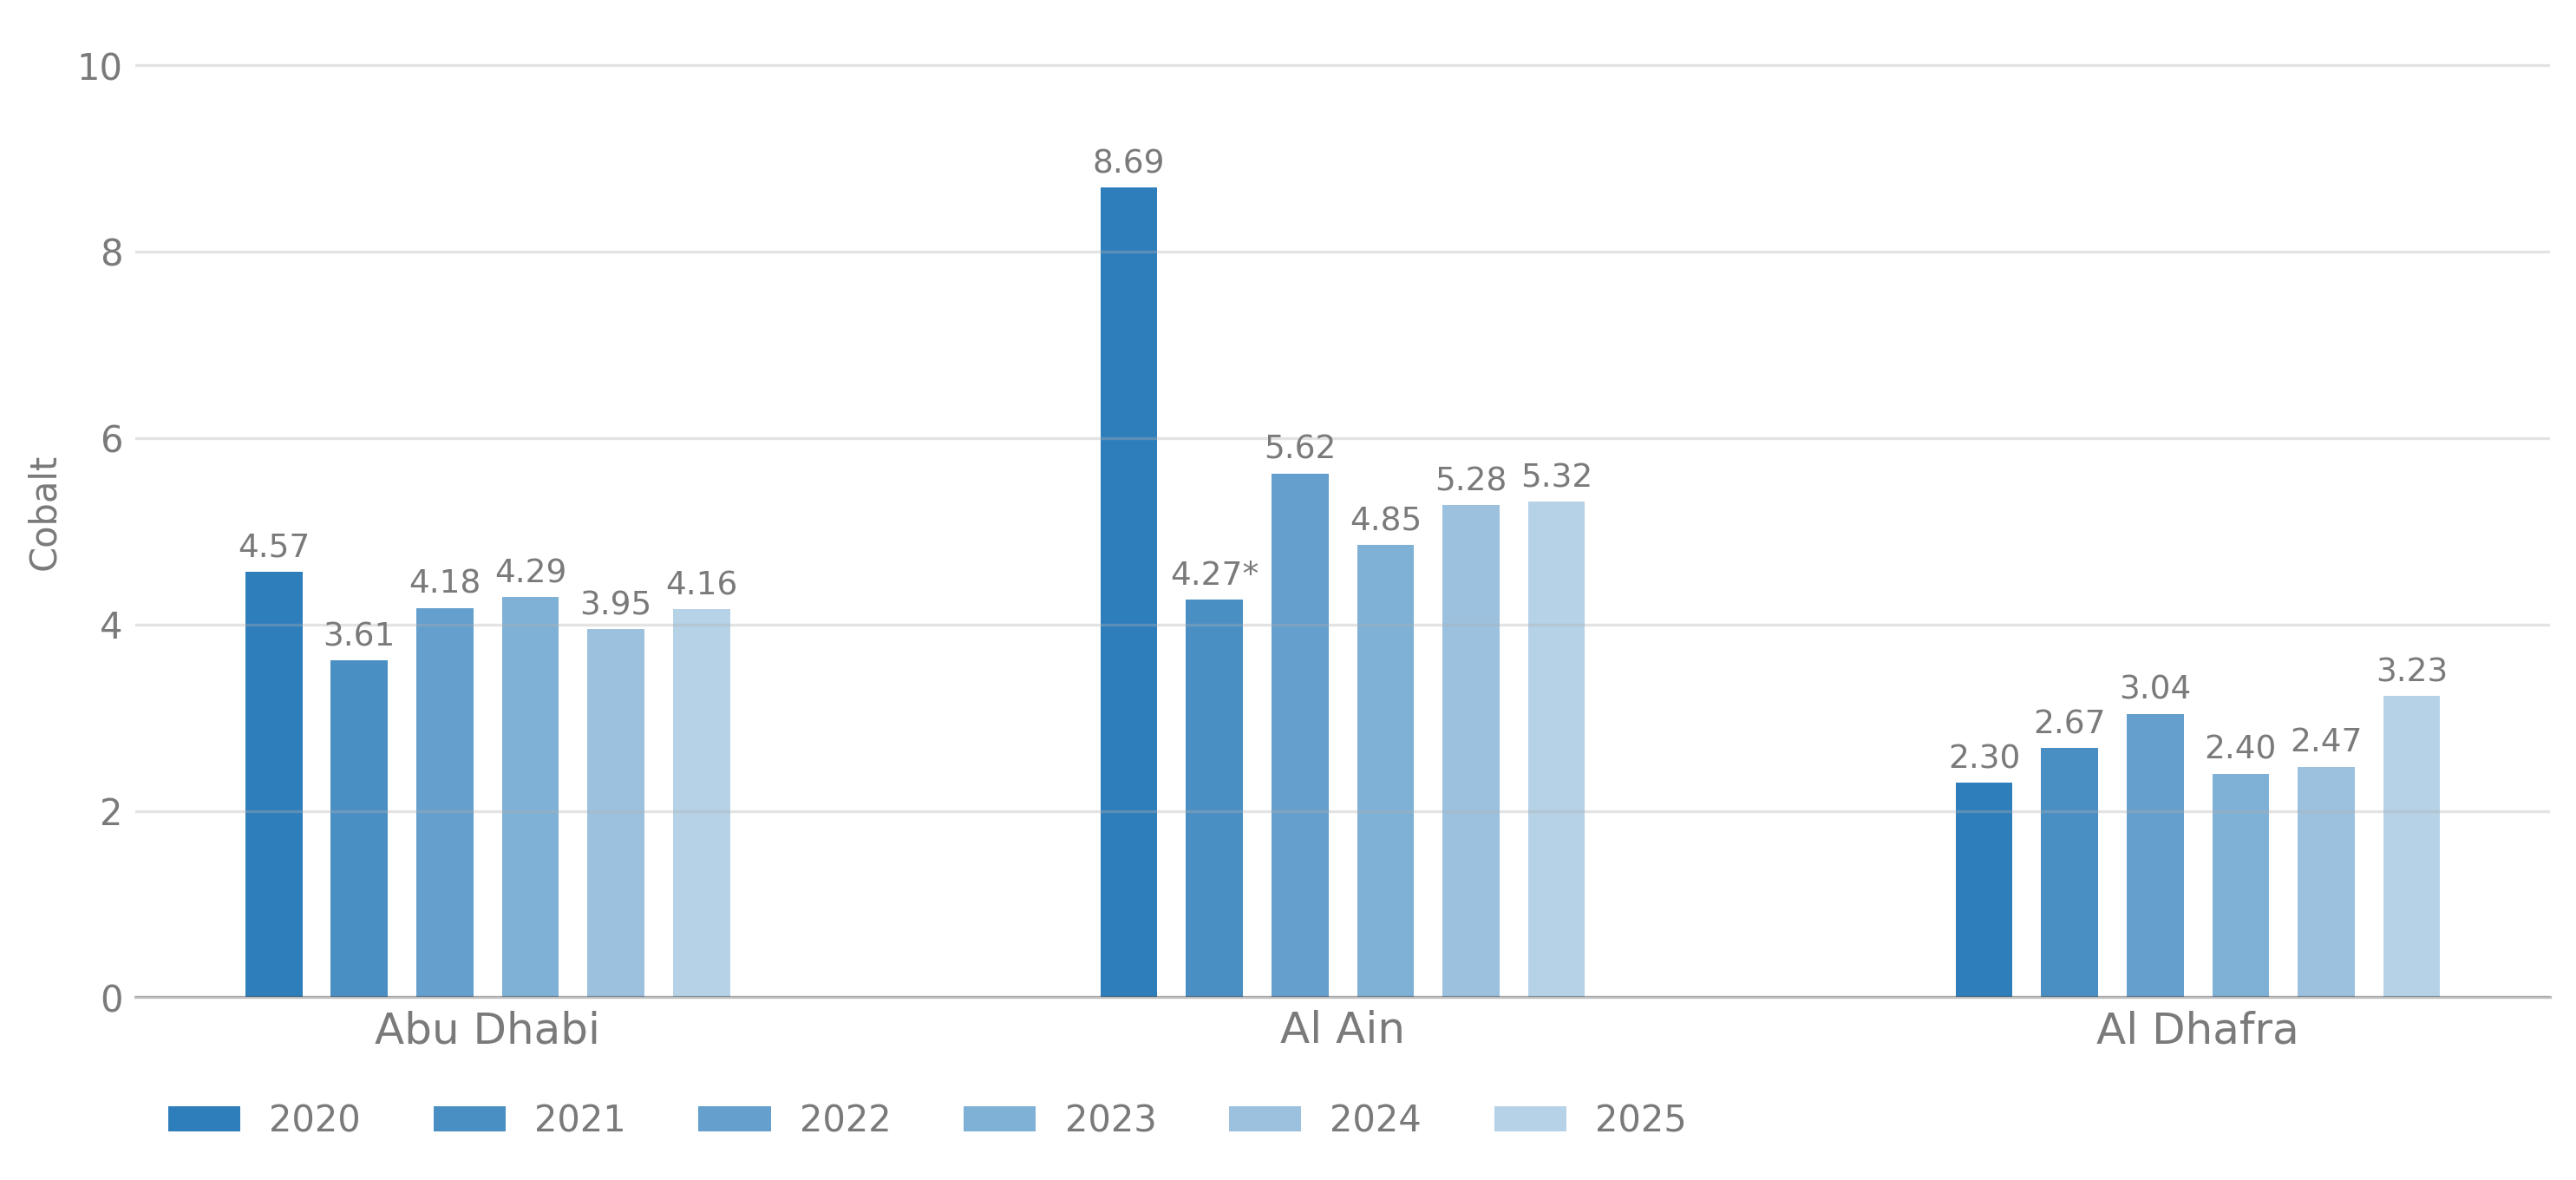

Copper


Mean ± se  Median   Min    Max   n
LandUse     Region                                           
Residential Abu Dhabi  8.69 ± 0.51 a    7.53  3.44  38.81  97
            Al Ain     6.03 ± 0.65 b    5.20  2.80  23.69  32
            Al Dhafra  5.51 ± 0.67 b    4.55  2.65  15.49  21

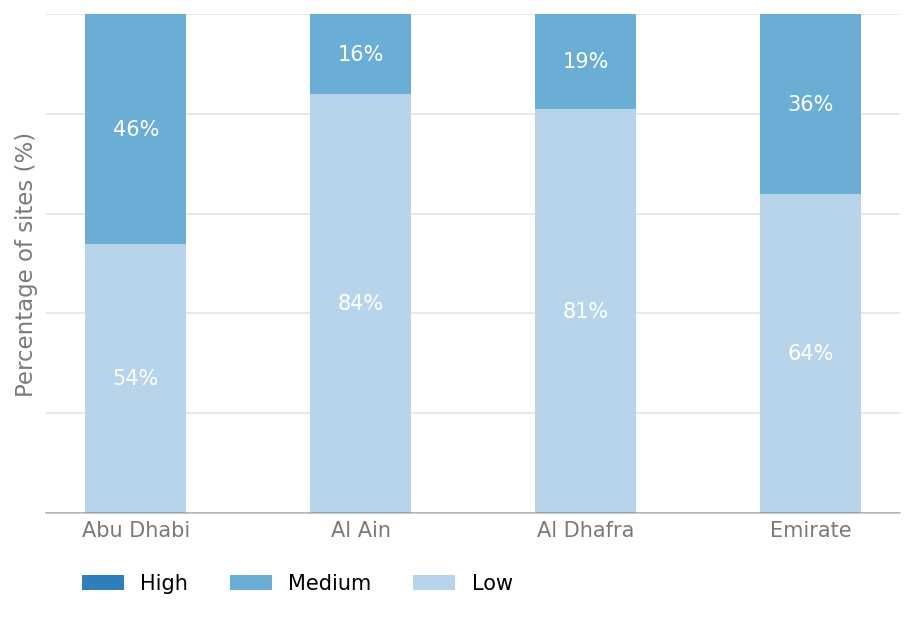

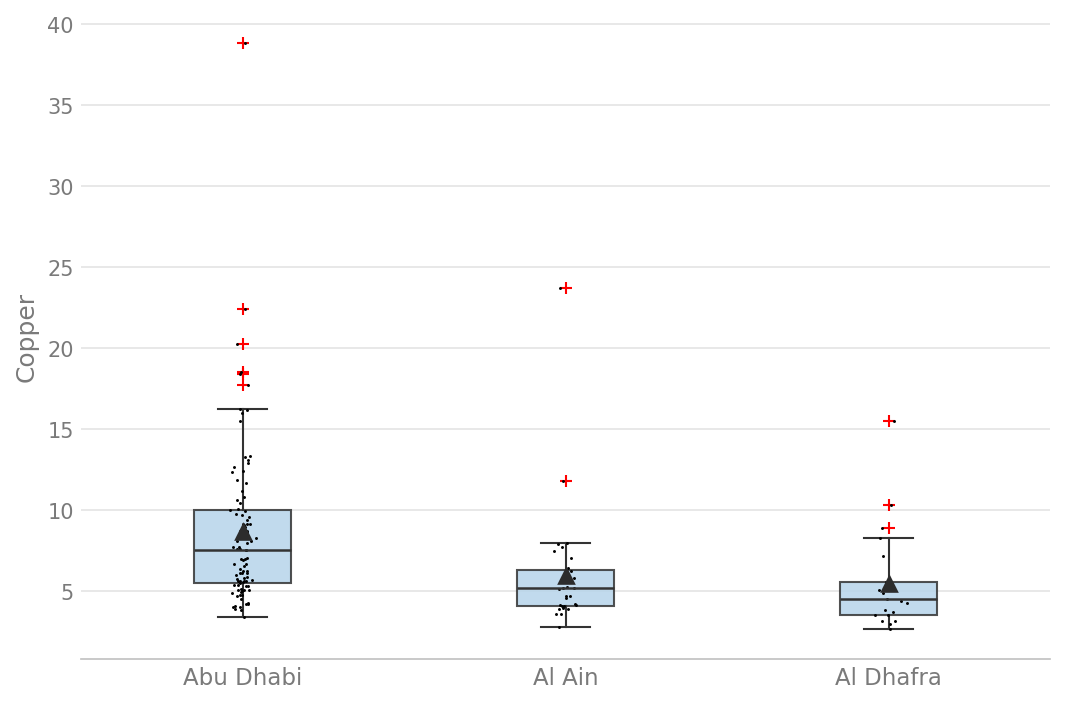

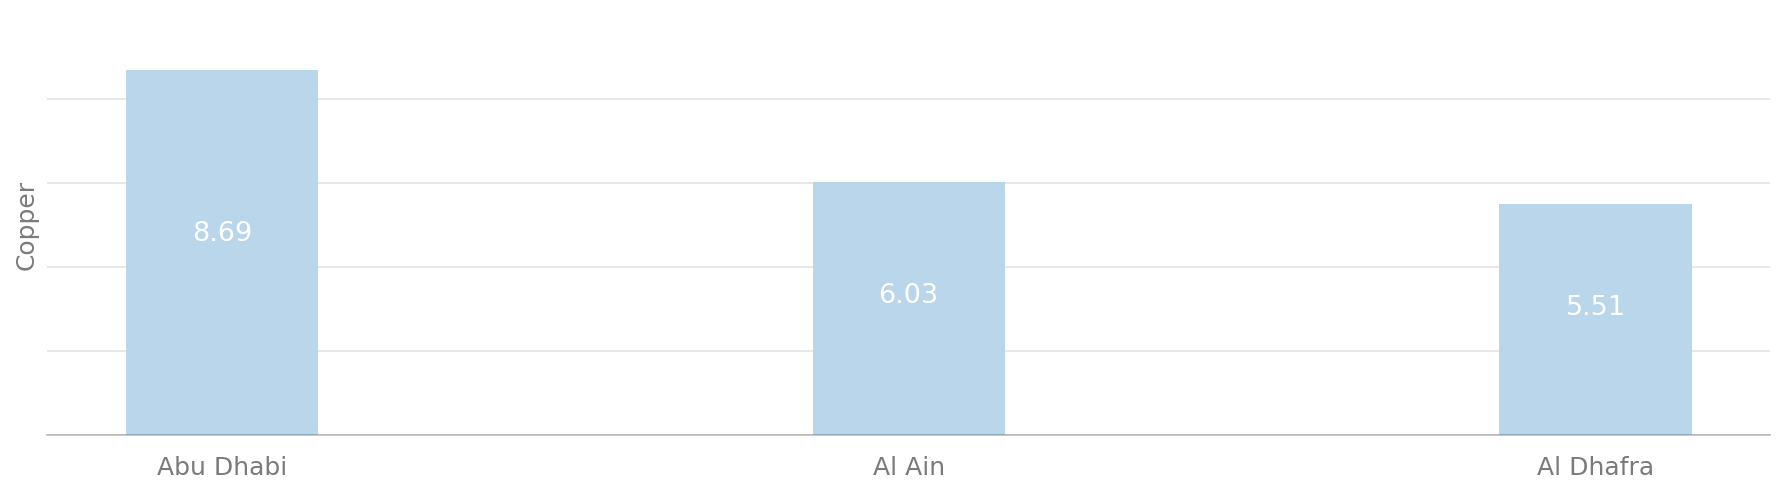

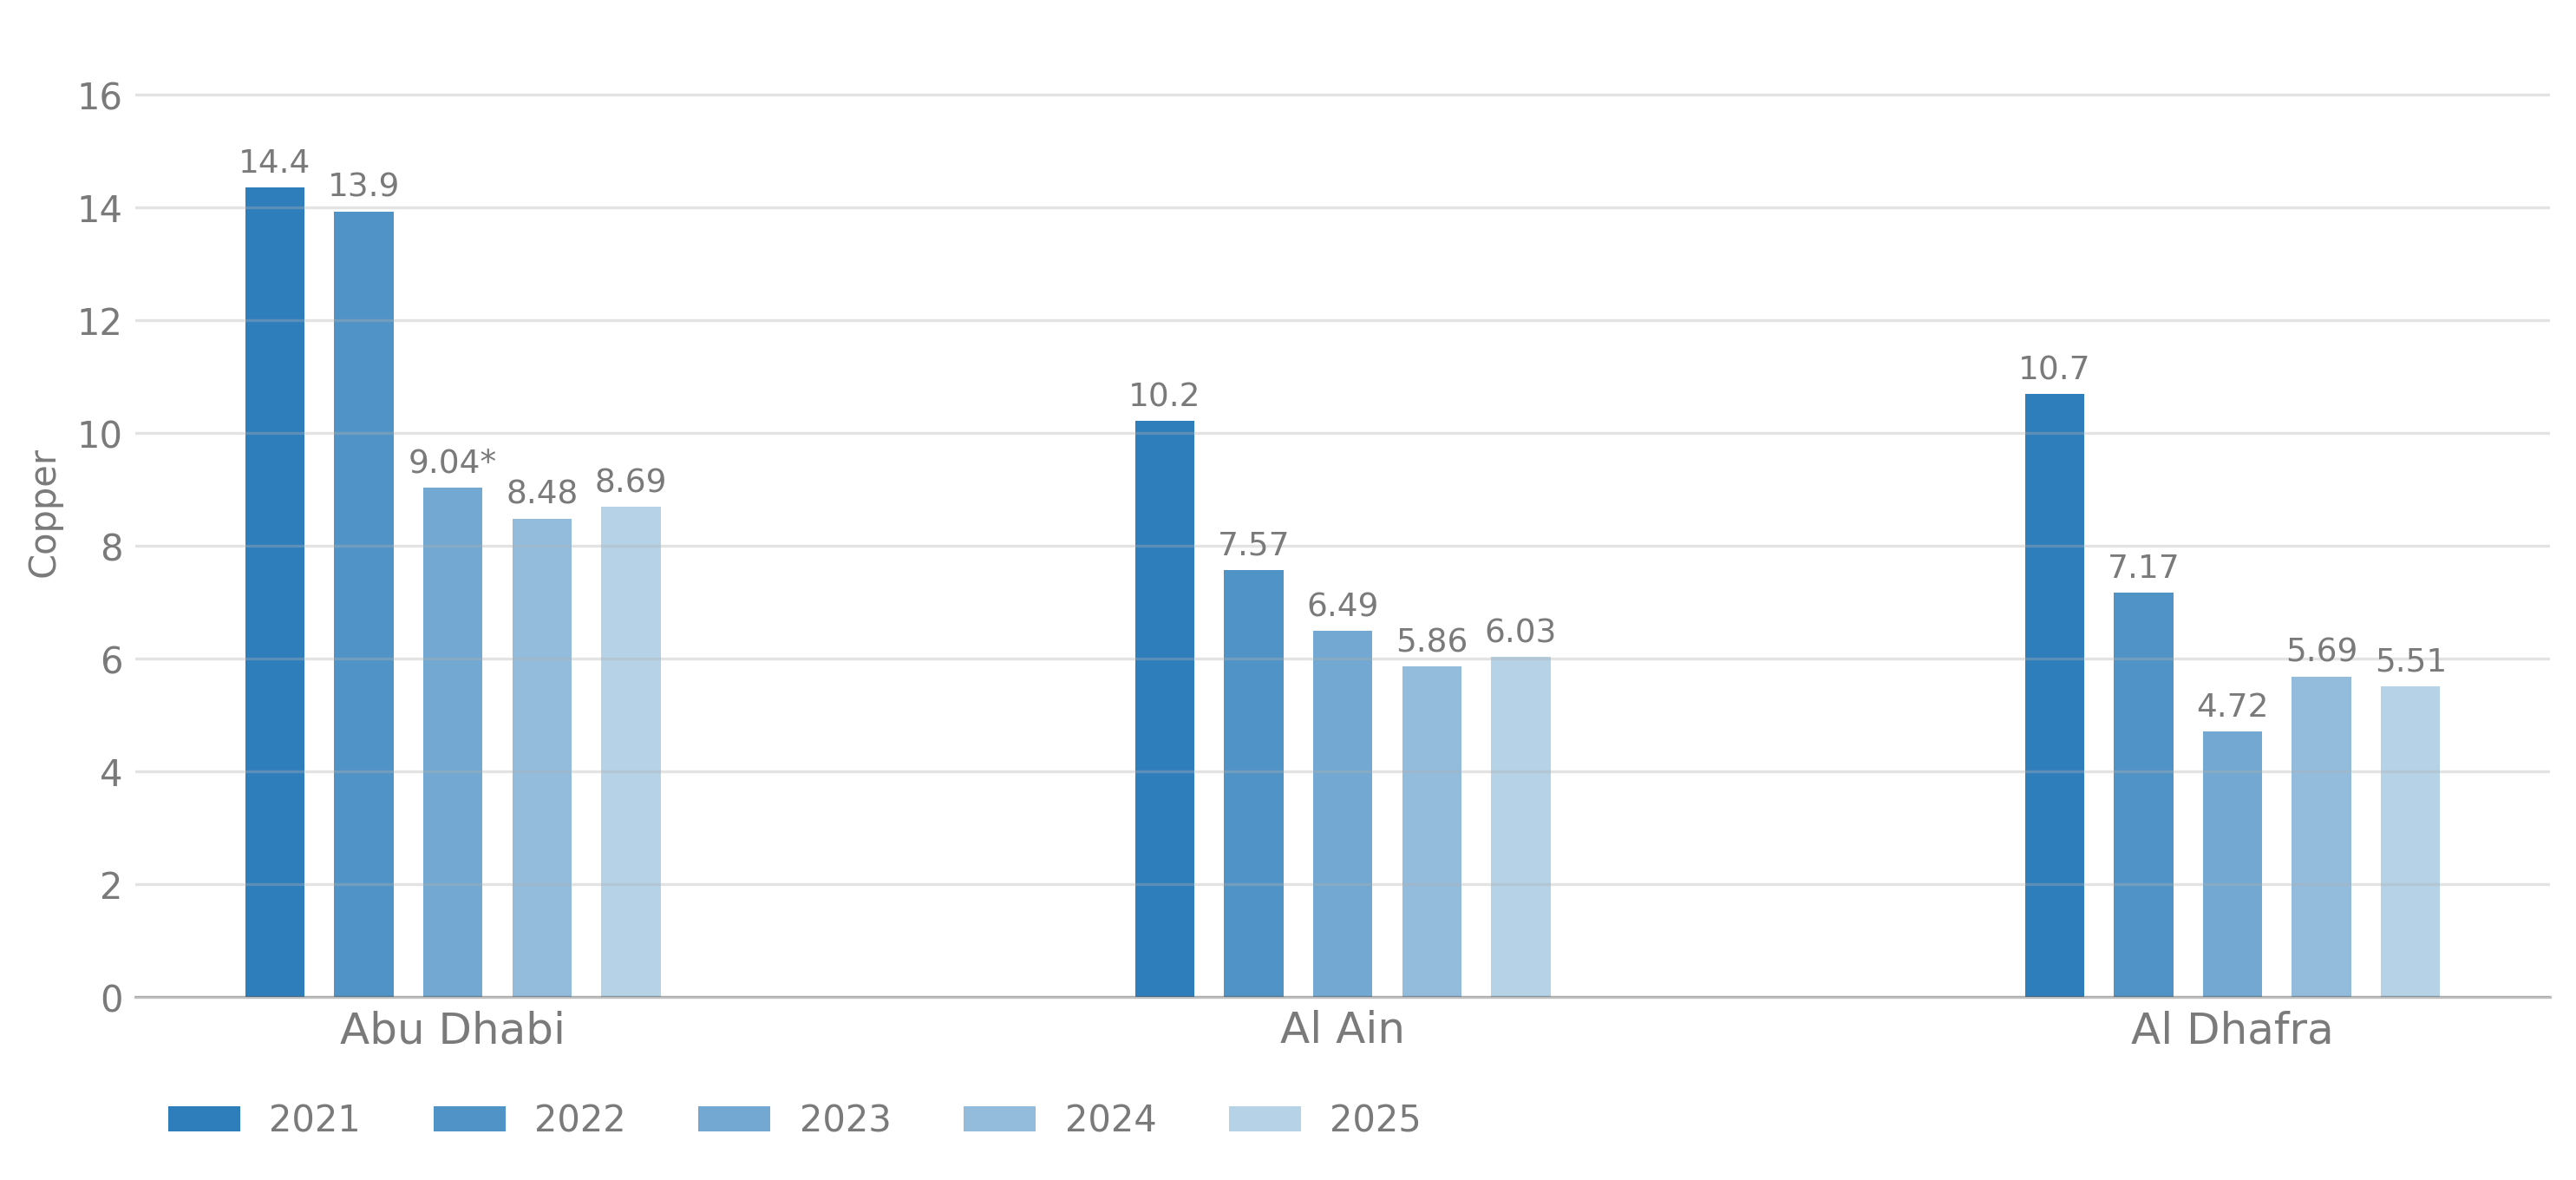

Lead


Mean ± se  Median   Min    Max   n
LandUse     Region                                           
Residential Abu Dhabi  3.88 ± 0.39 a    2.64  1.48  25.27  96
            Al Ain     3.45 ± 0.45 a    2.58  1.56  13.25  32
            Al Dhafra  2.85 ± 0.61 b    1.86  1.28  13.59  21

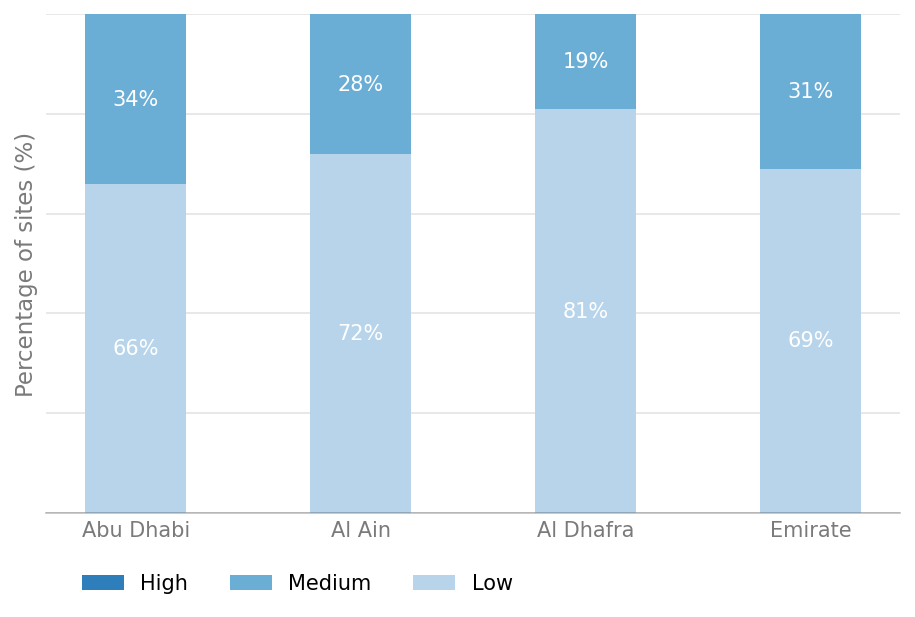

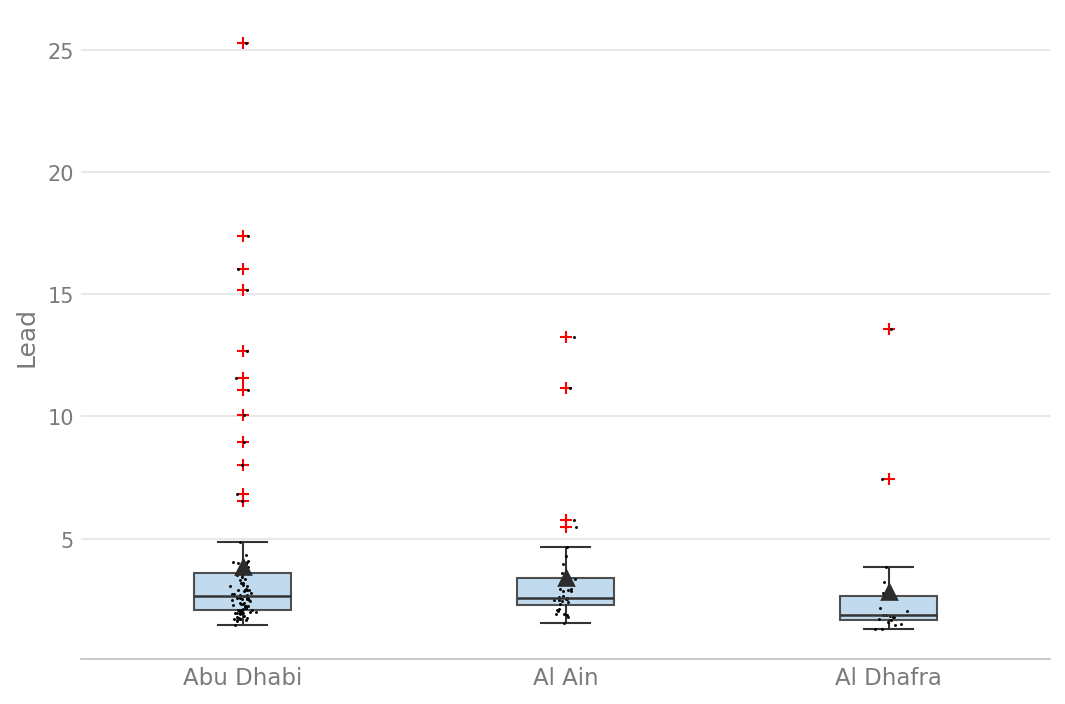

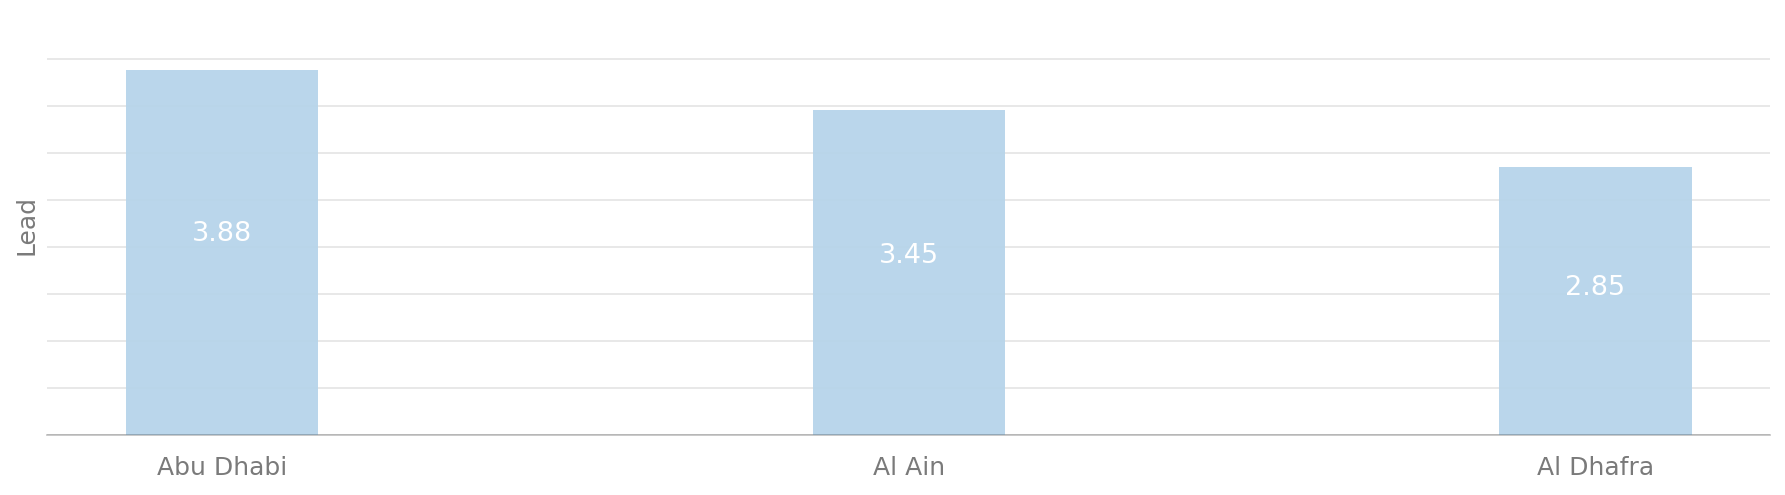

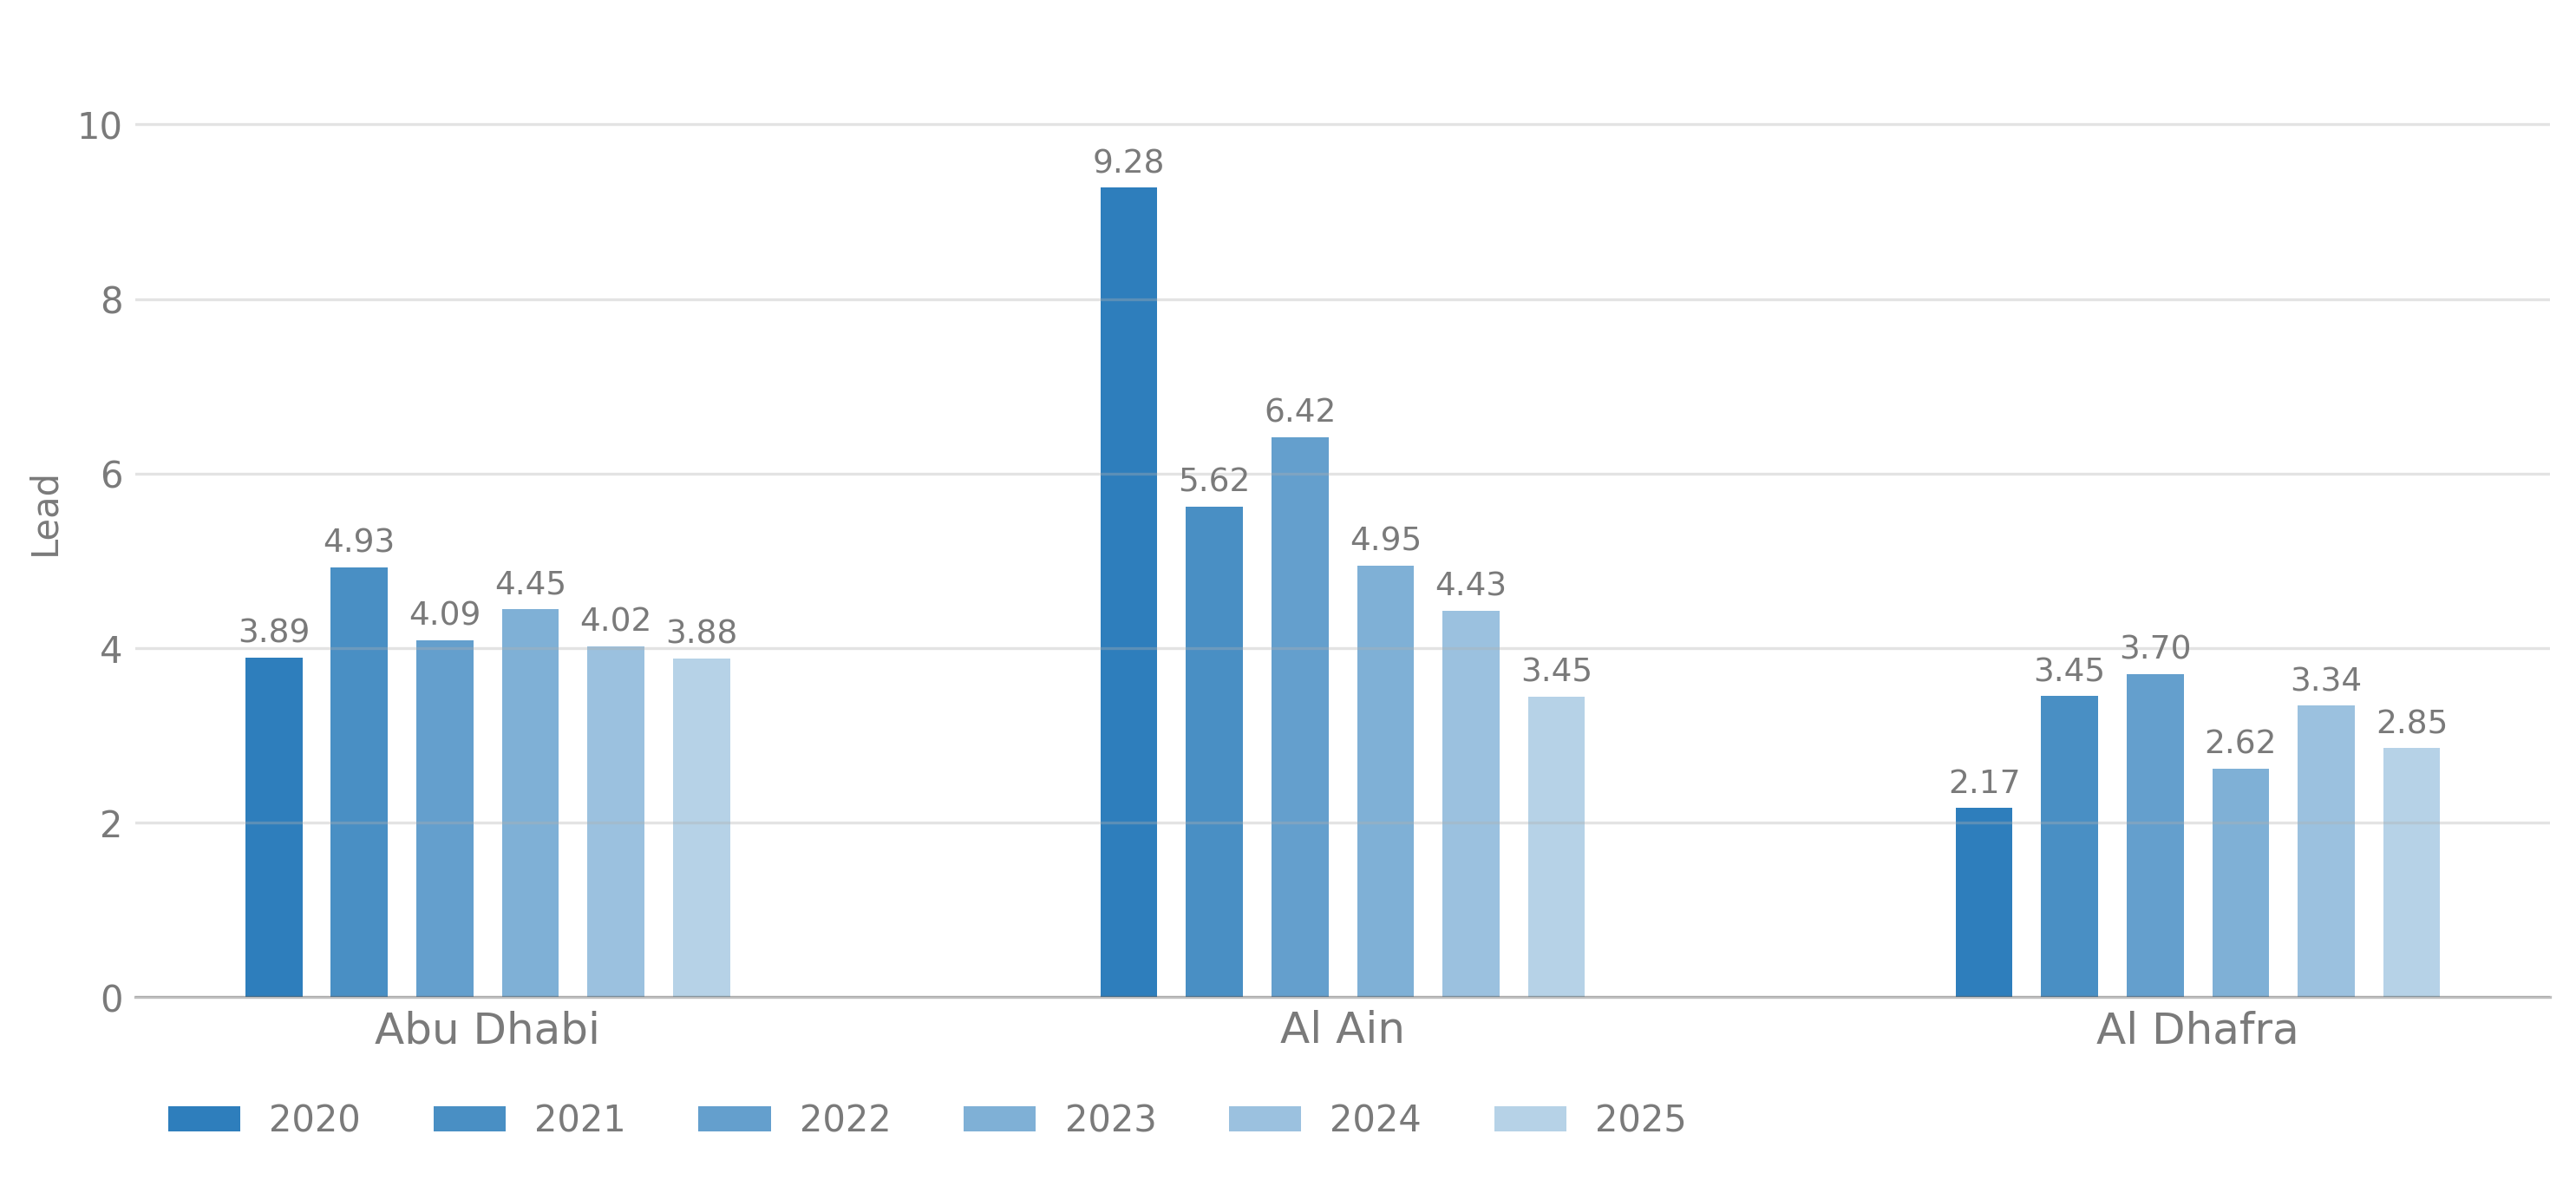

Manganese


Mean ± se  Median    Min     Max   n
LandUse     Region                                               
Residential Abu Dhabi  140.63 ± 3.41 a  135.89  79.55  240.54  97
            Al Ain     141.10 ± 9.21 a  120.23  81.04  302.92  32
            Al Dhafra  122.61 ± 6.58 b  113.34  69.55  194.56  21

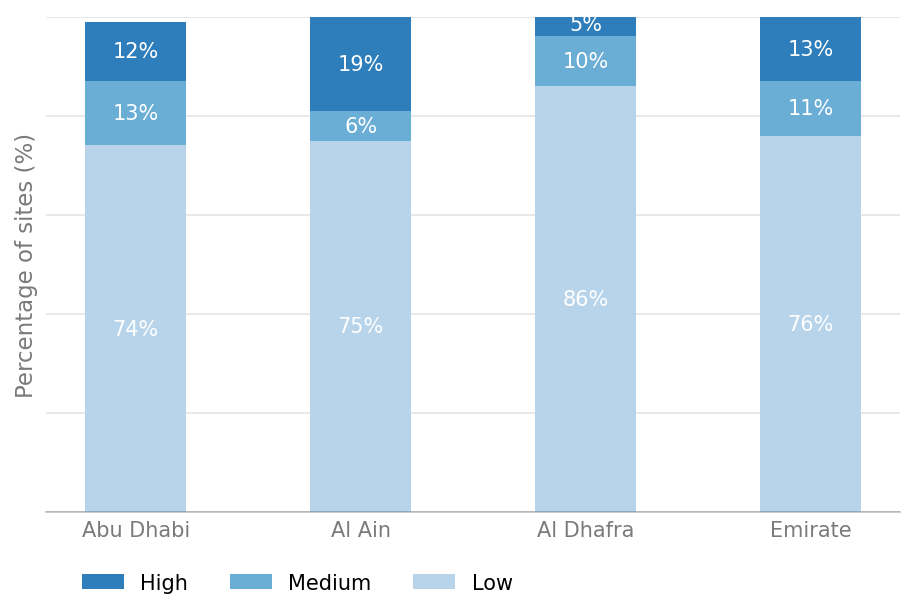

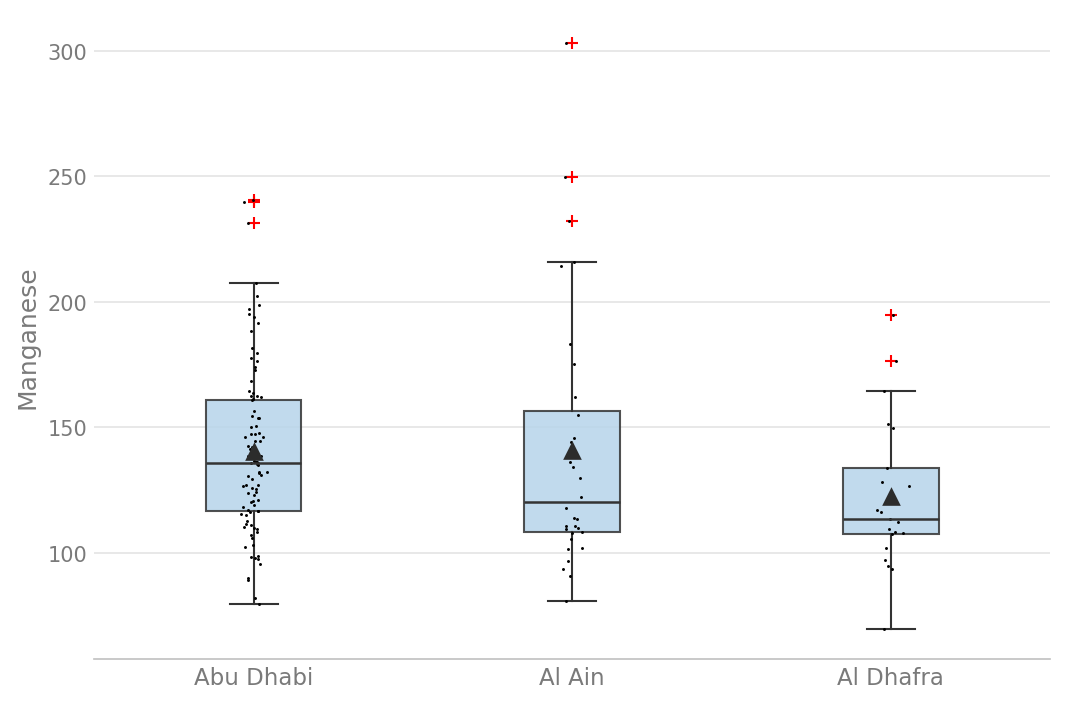

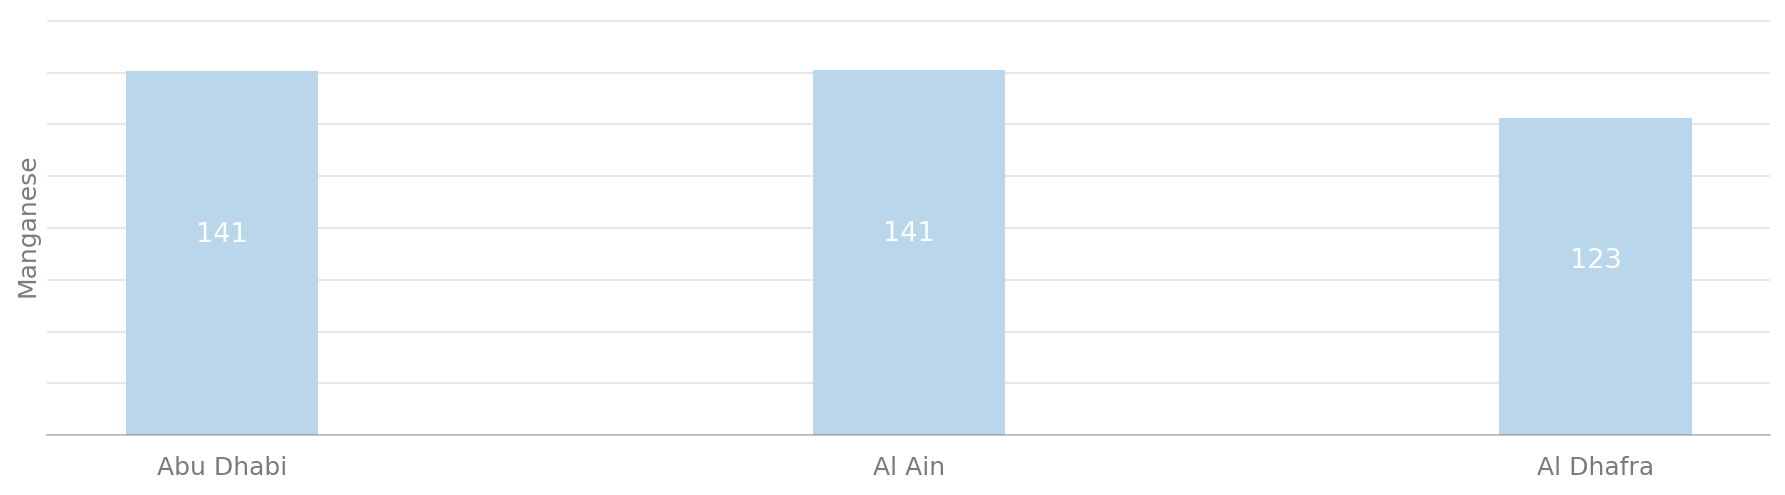

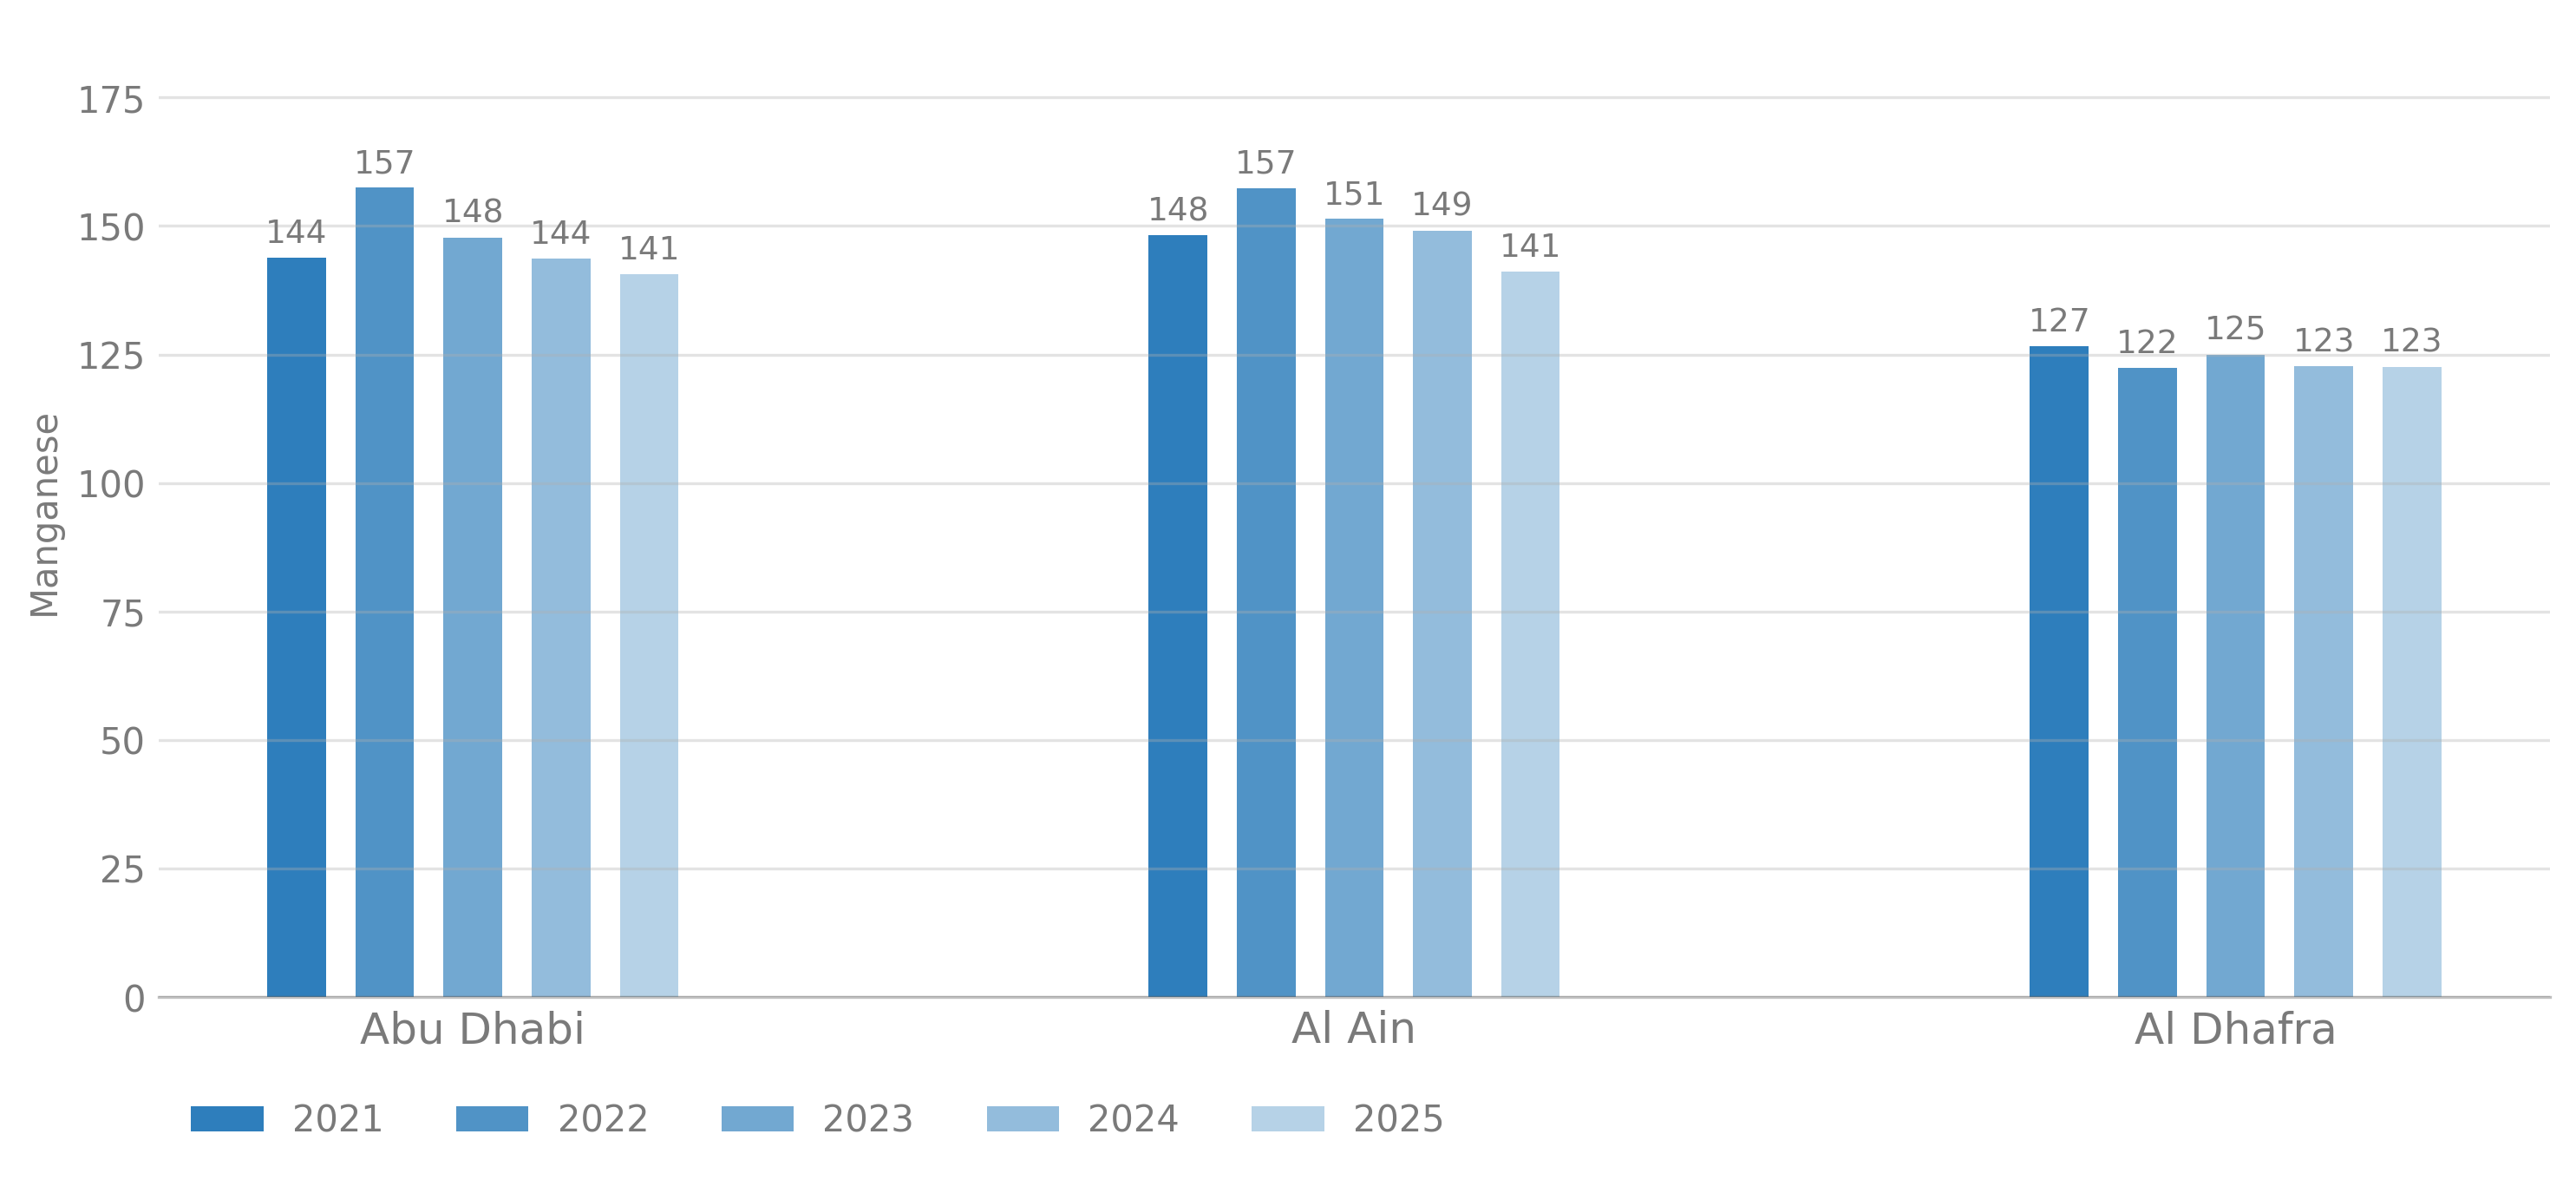

Molybdenum


Mean ± se  Median   Min   Max   n
LandUse     Region                                          
Residential Abu Dhabi  0.54 ± 0.06 a    0.37  0.18  4.92  97
            Al Ain     0.30 ± 0.02 b    0.28  0.15  0.58  32
            Al Dhafra  0.39 ± 0.04 a    0.35  0.19  0.89  21

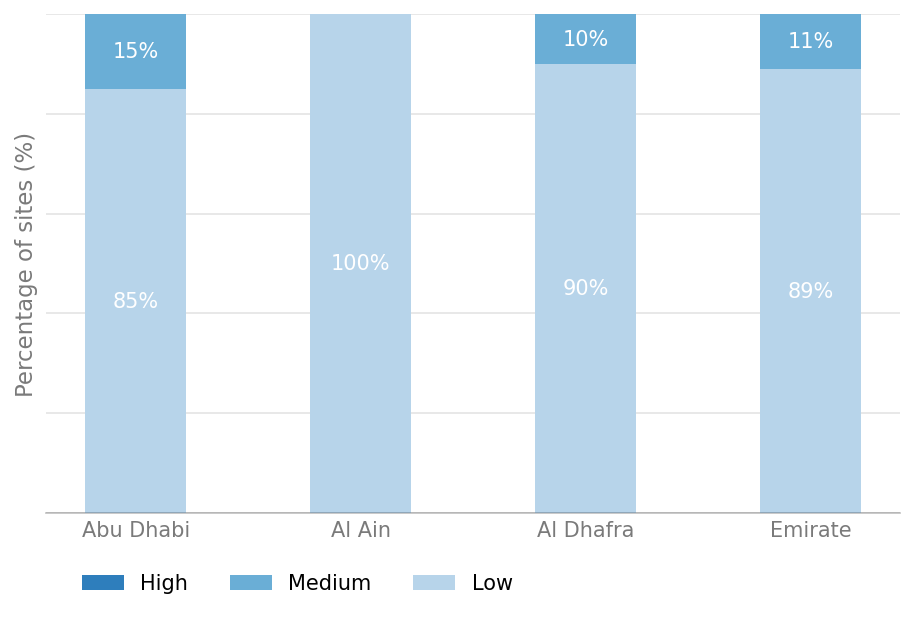

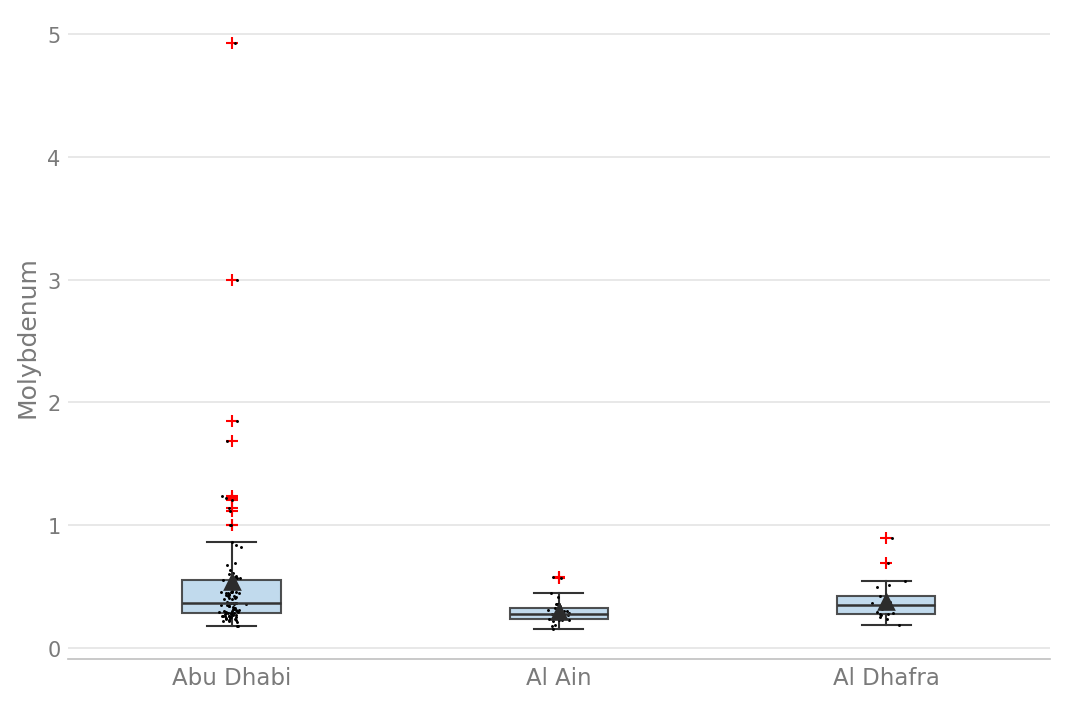

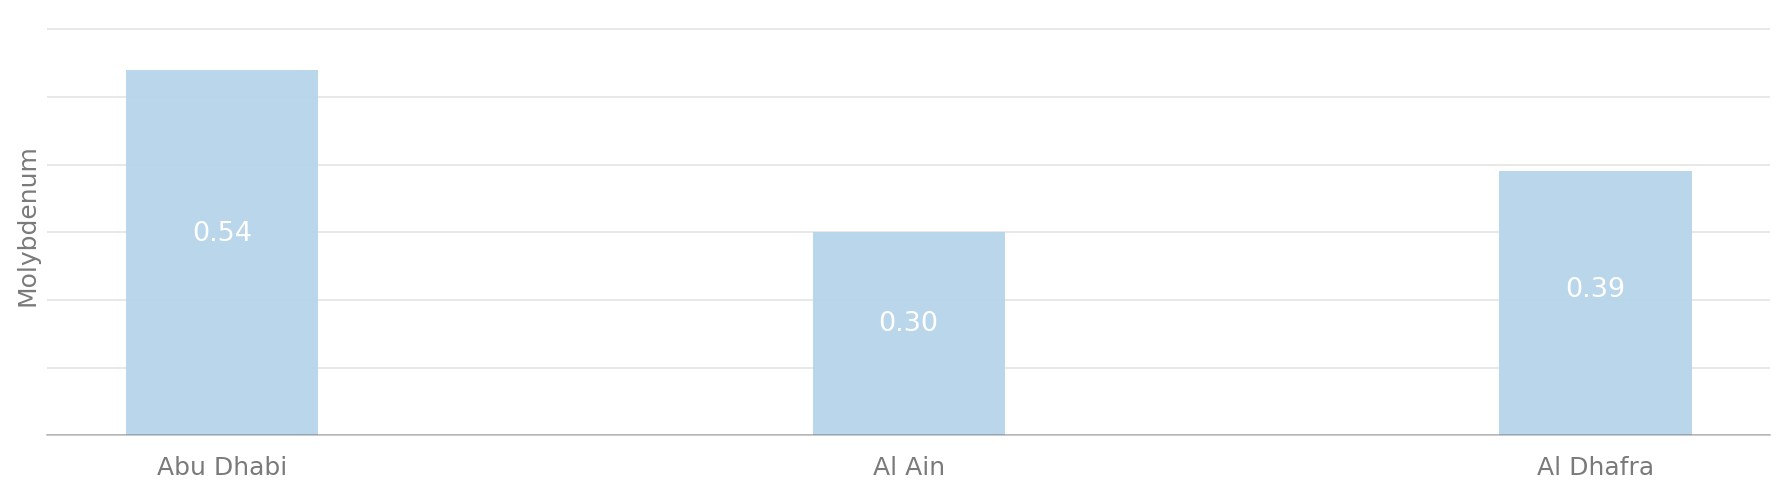

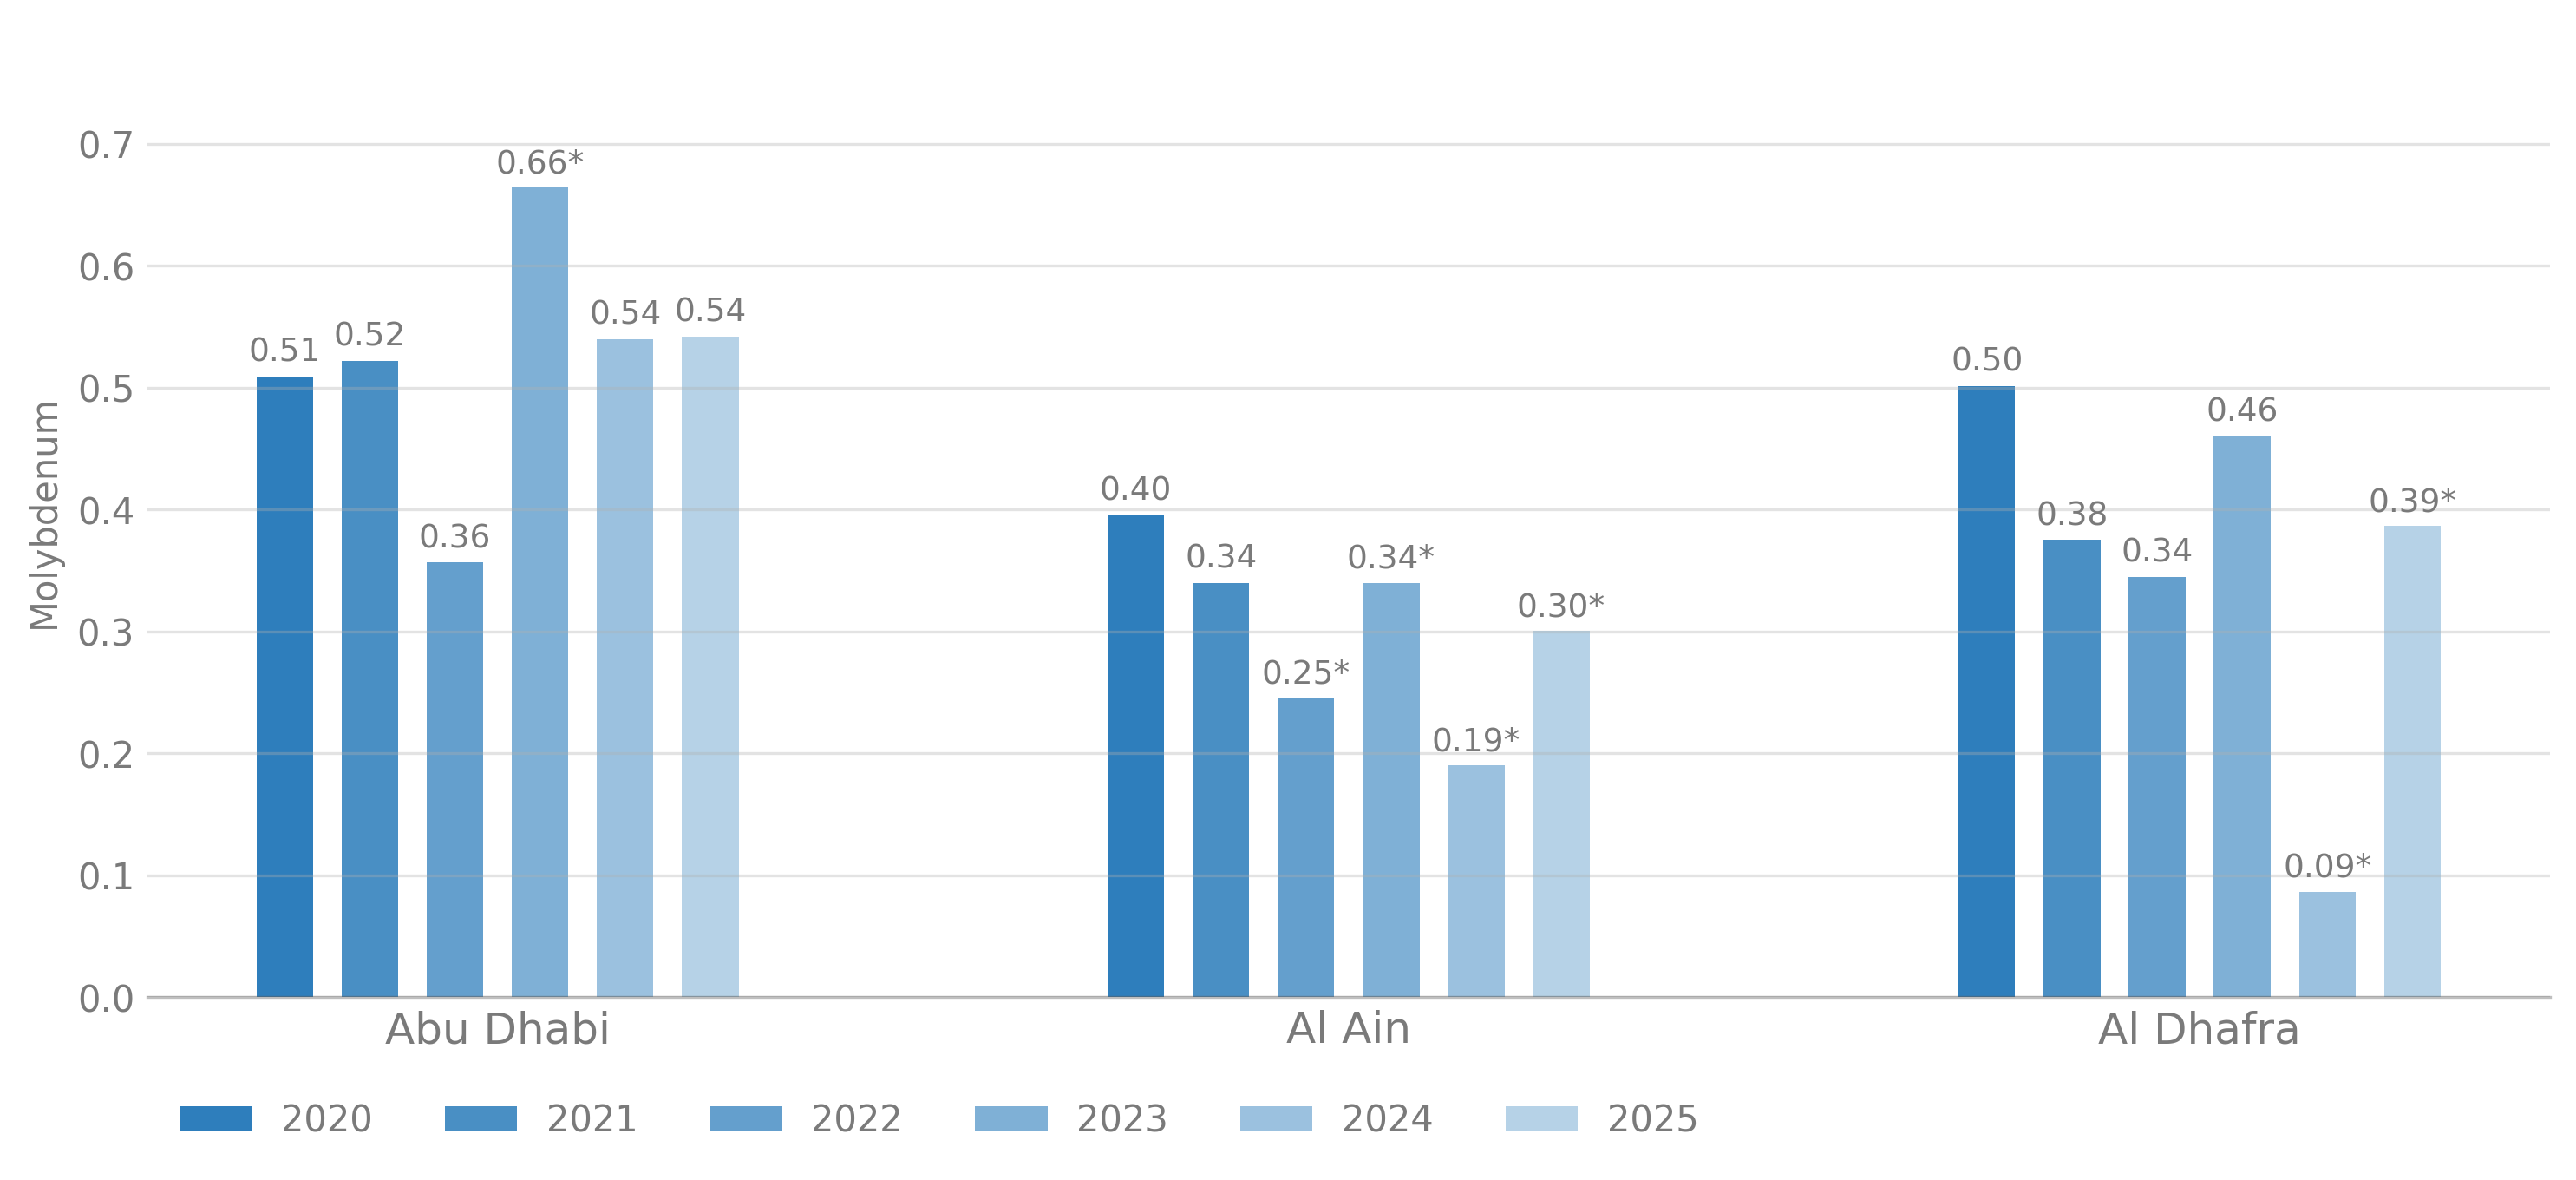

Nickel


Mean ± se  Median    Min     Max   n
LandUse     Region                                               
Residential Abu Dhabi   55.86 ± 4.91 b   40.50  15.00  303.09  97
            Al Ain     96.51 ± 12.76 a   66.66  33.12  293.41  30
            Al Dhafra   38.74 ± 9.69 c   28.95  10.47  216.85  21

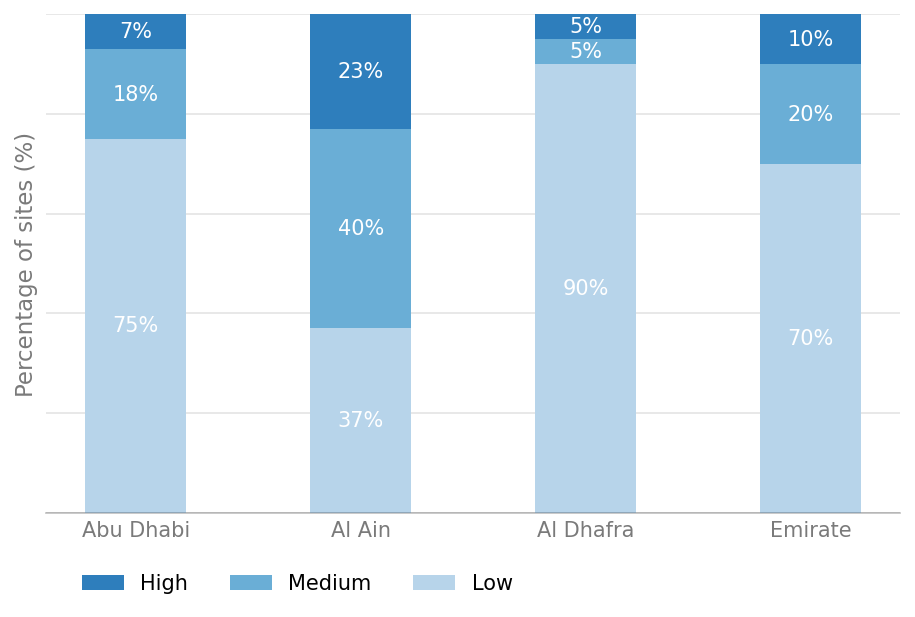

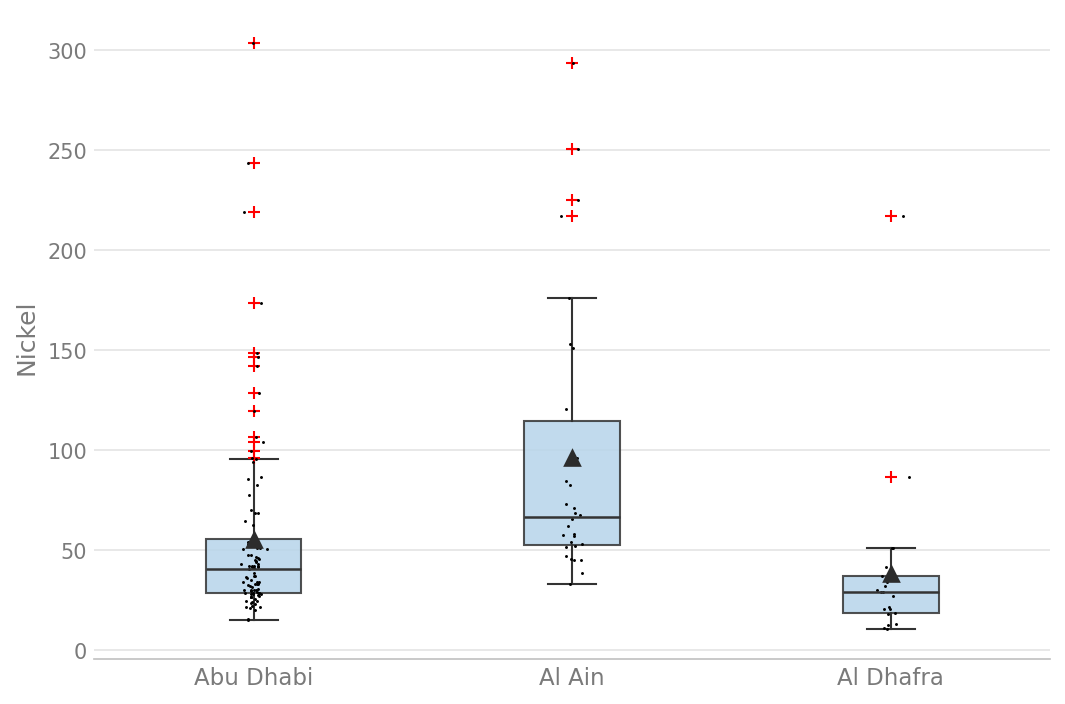

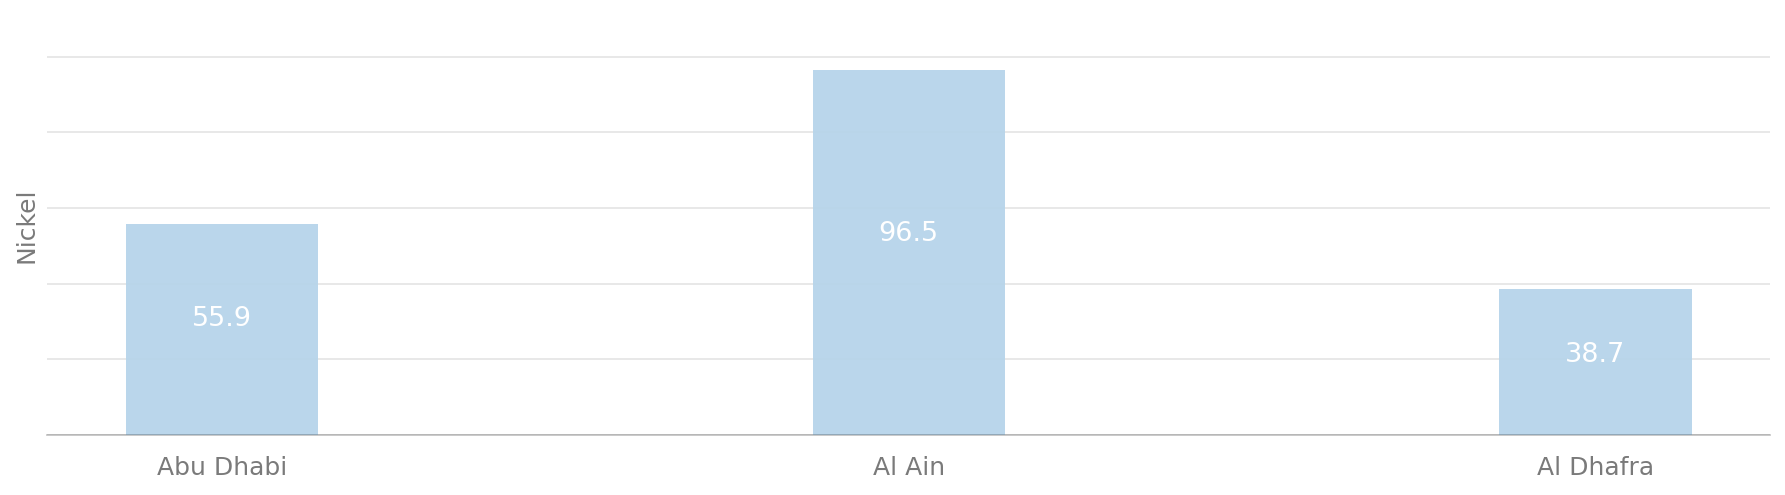

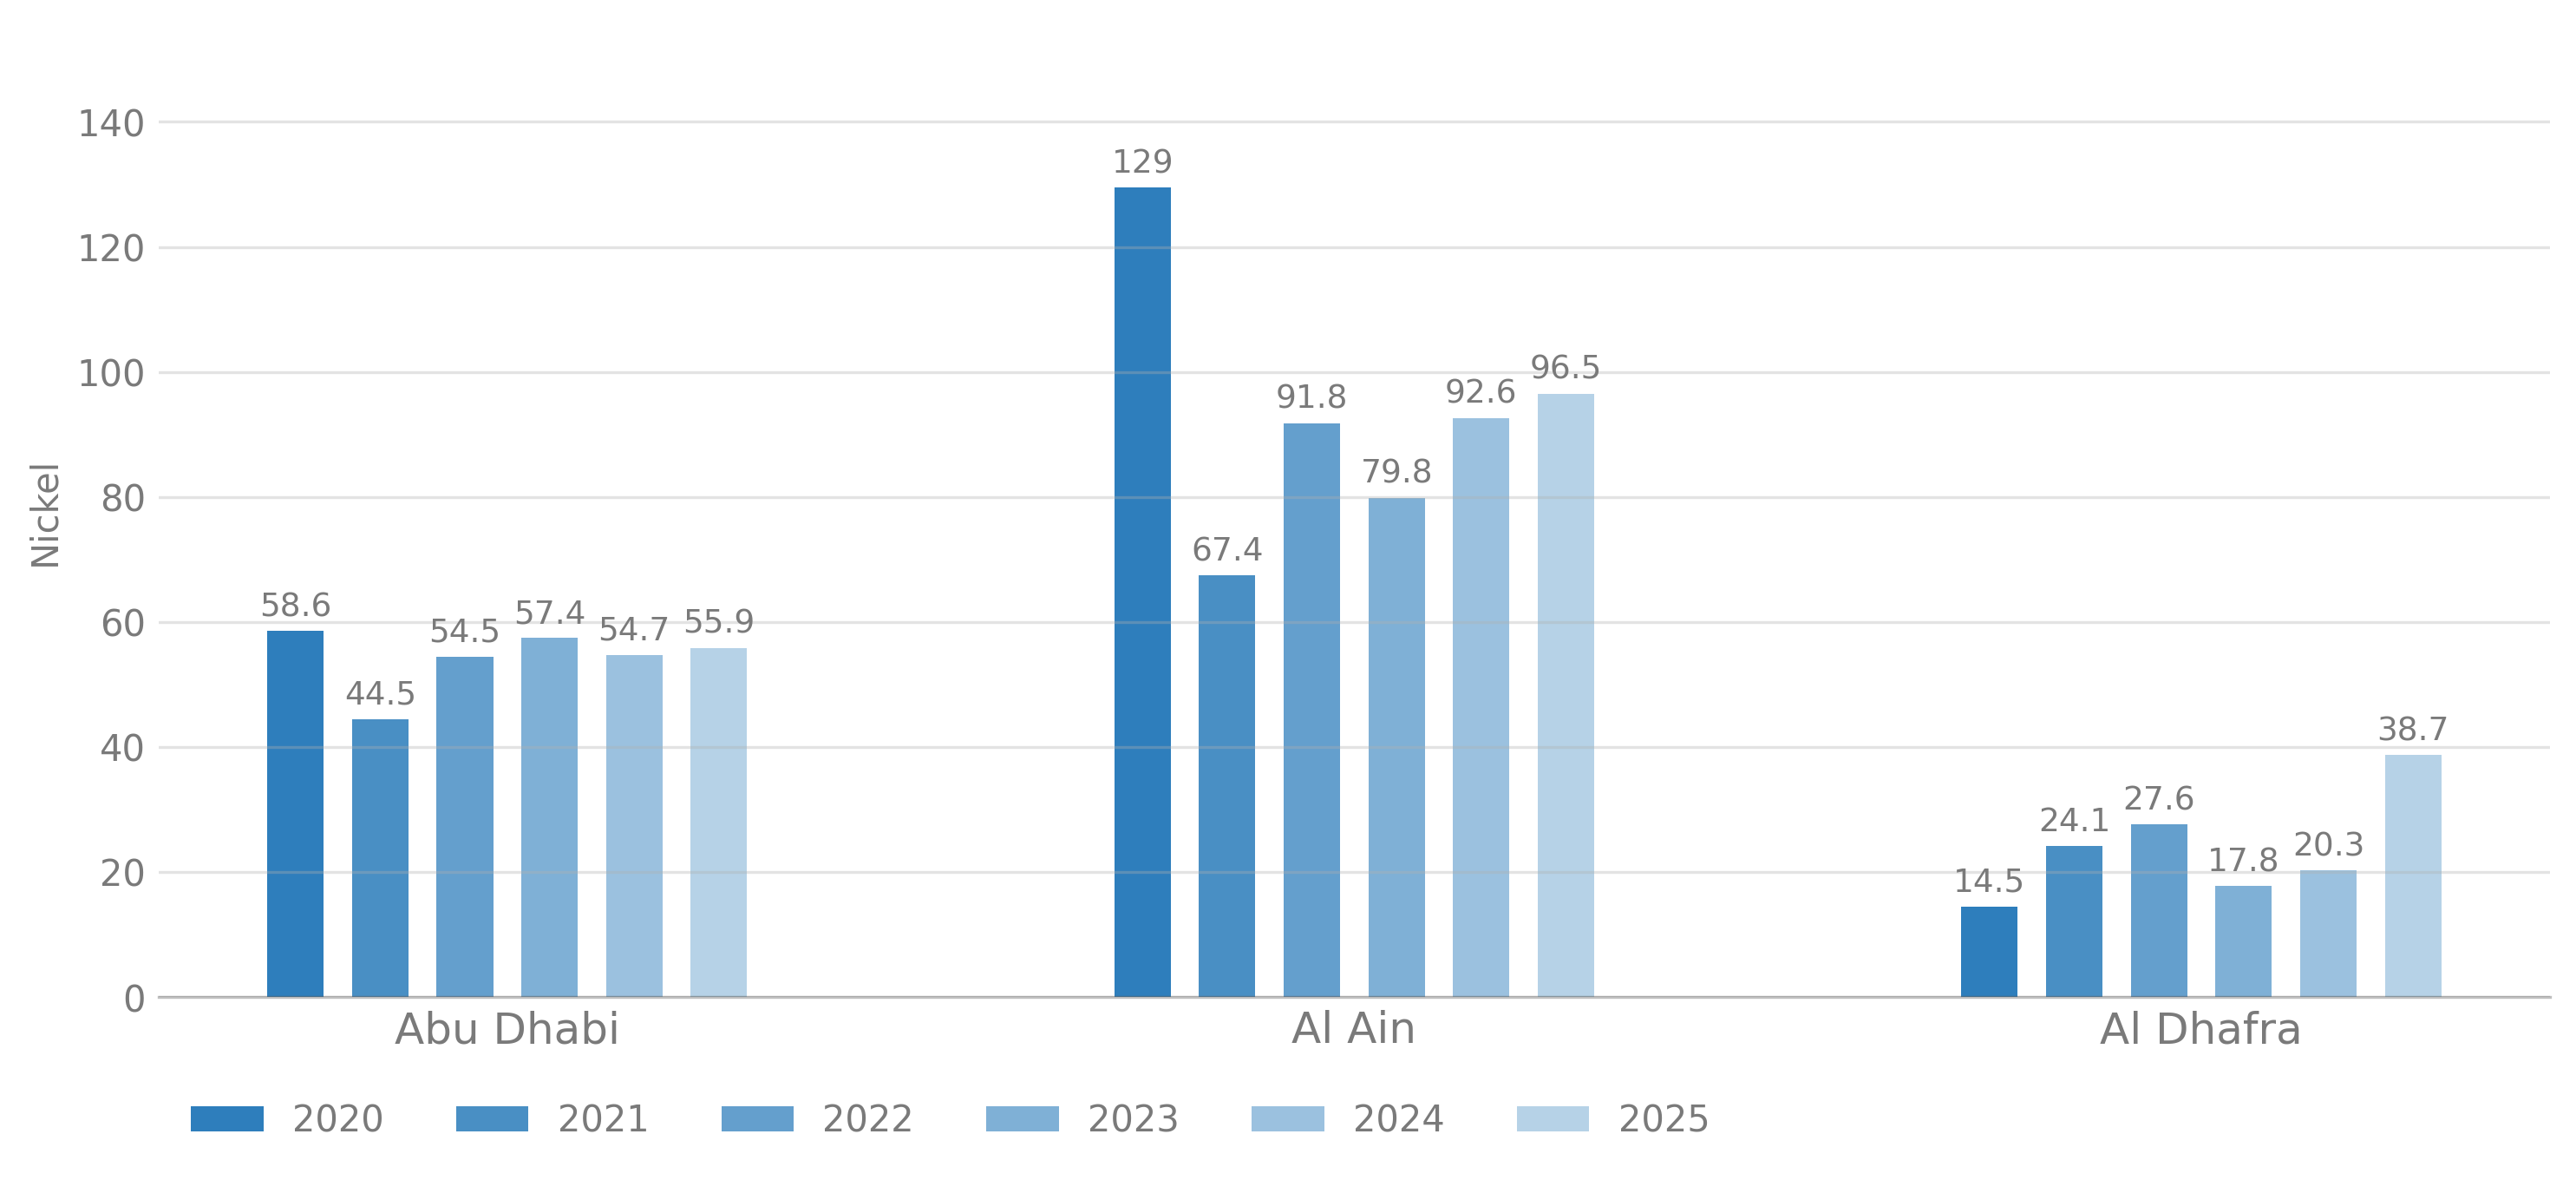

Selenium


Mean ± se  Median   Min   Max   n
LandUse     Region                                          
Residential Abu Dhabi  0.12 ± 0.01 a    0.11  0.00  0.37  97
            Al Ain     0.15 ± 0.02 a    0.14  0.03  0.41  32
            Al Dhafra  0.16 ± 0.02 a    0.15  0.02  0.30  21

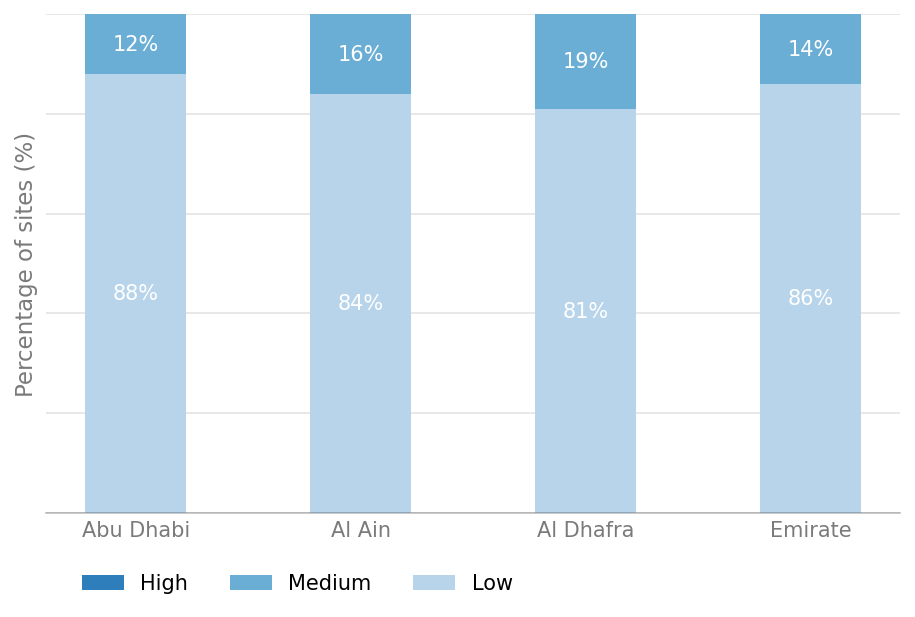

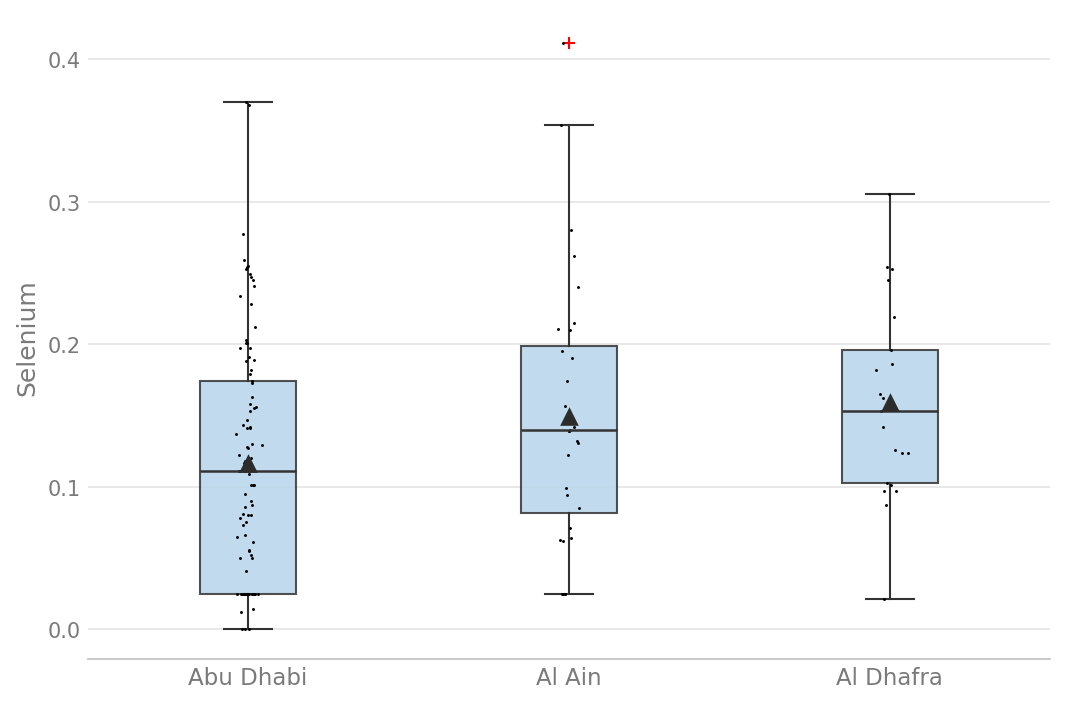

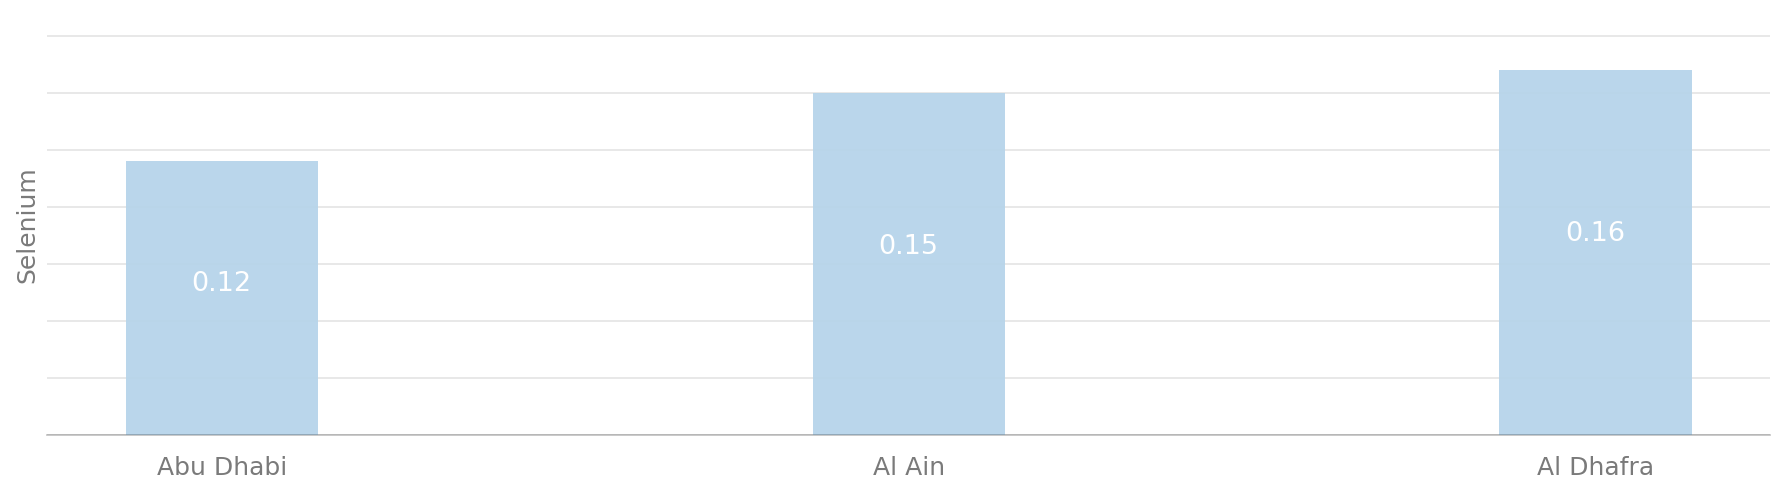

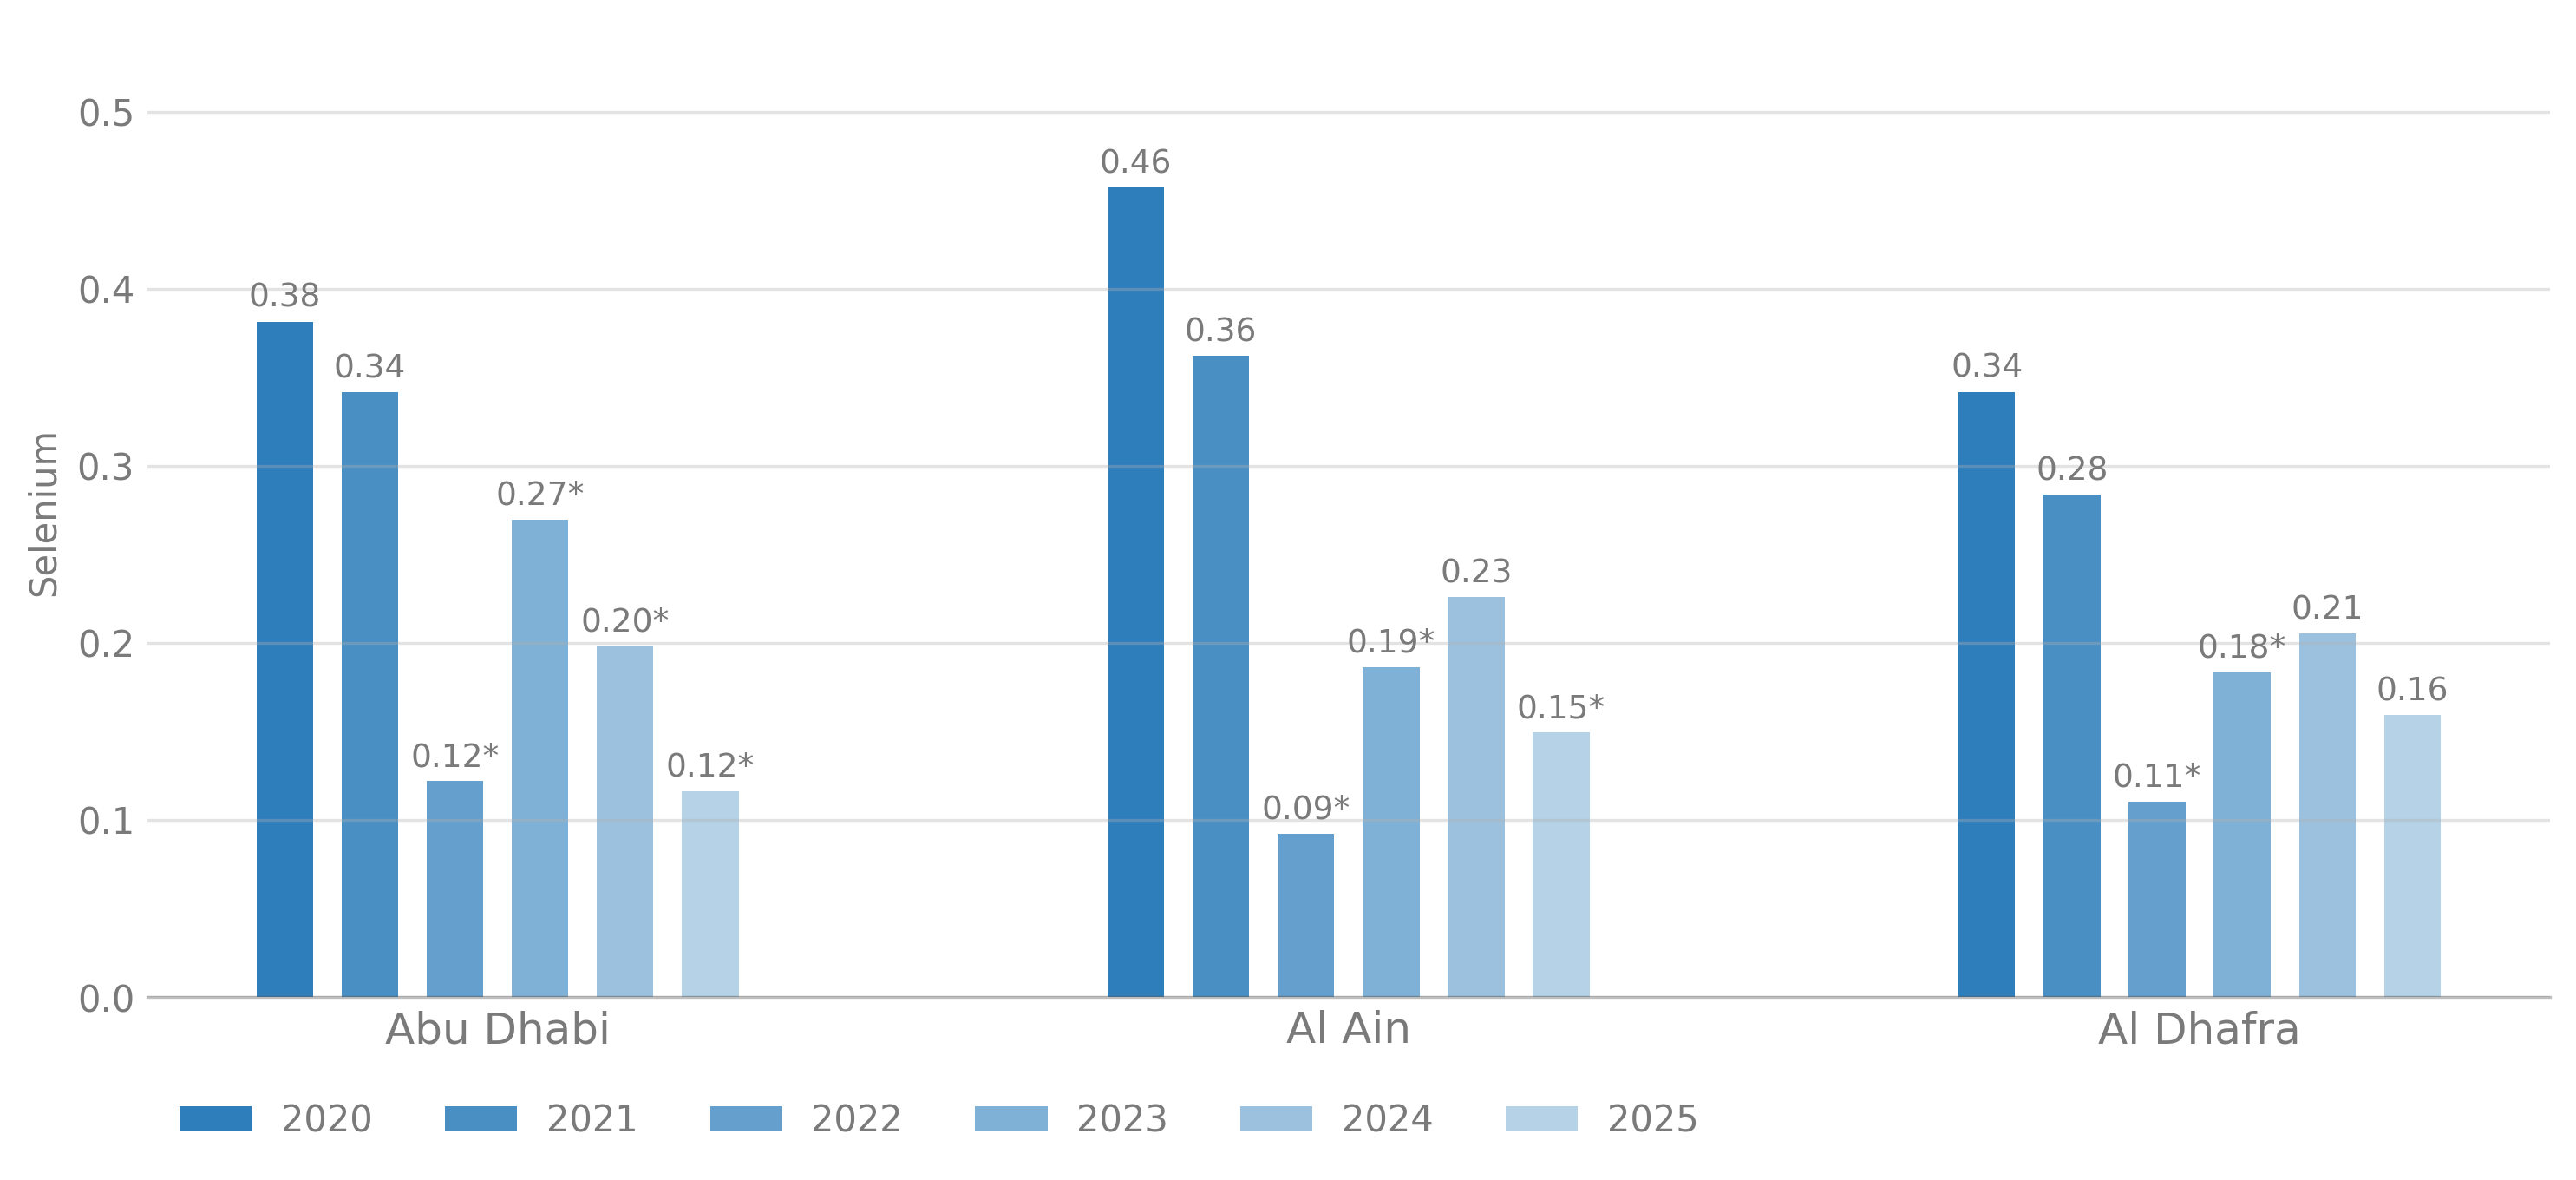

Zinc


Mean ± se  Median   Min     Max   n
LandUse     Region                                             
Residential Abu Dhabi  38.35 ± 3.24 a   27.96  8.59  177.83  96
            Al Ain     20.34 ± 2.69 b   15.76  7.39   74.87  32
            Al Dhafra  24.84 ± 5.10 b   15.63  6.56   95.98  21

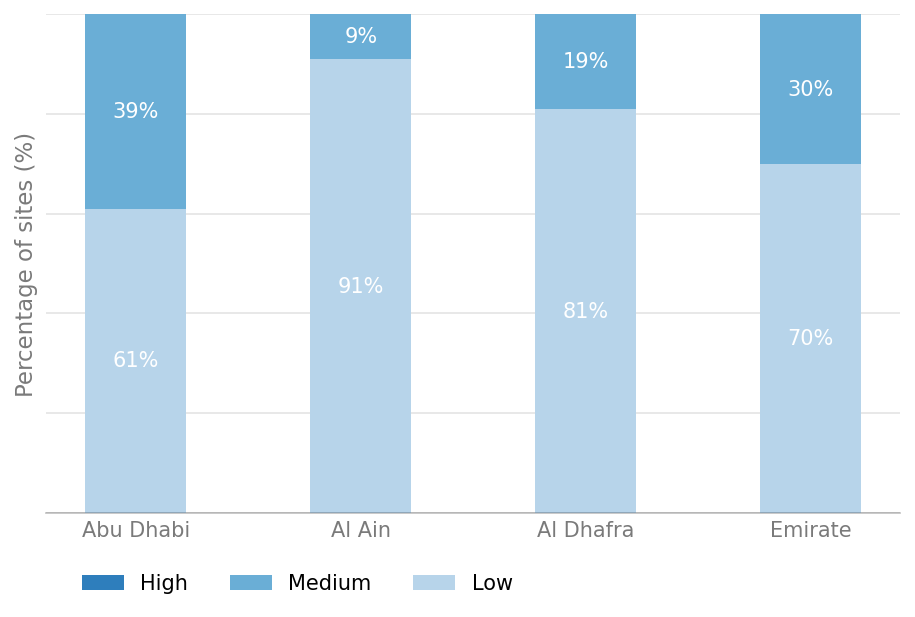

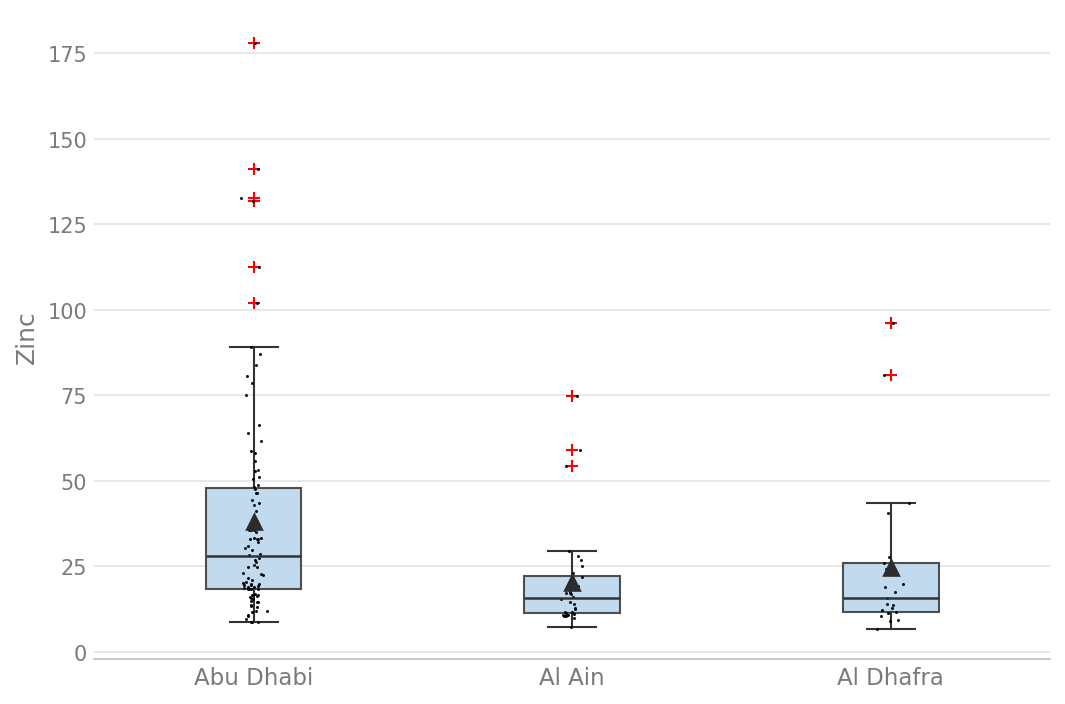

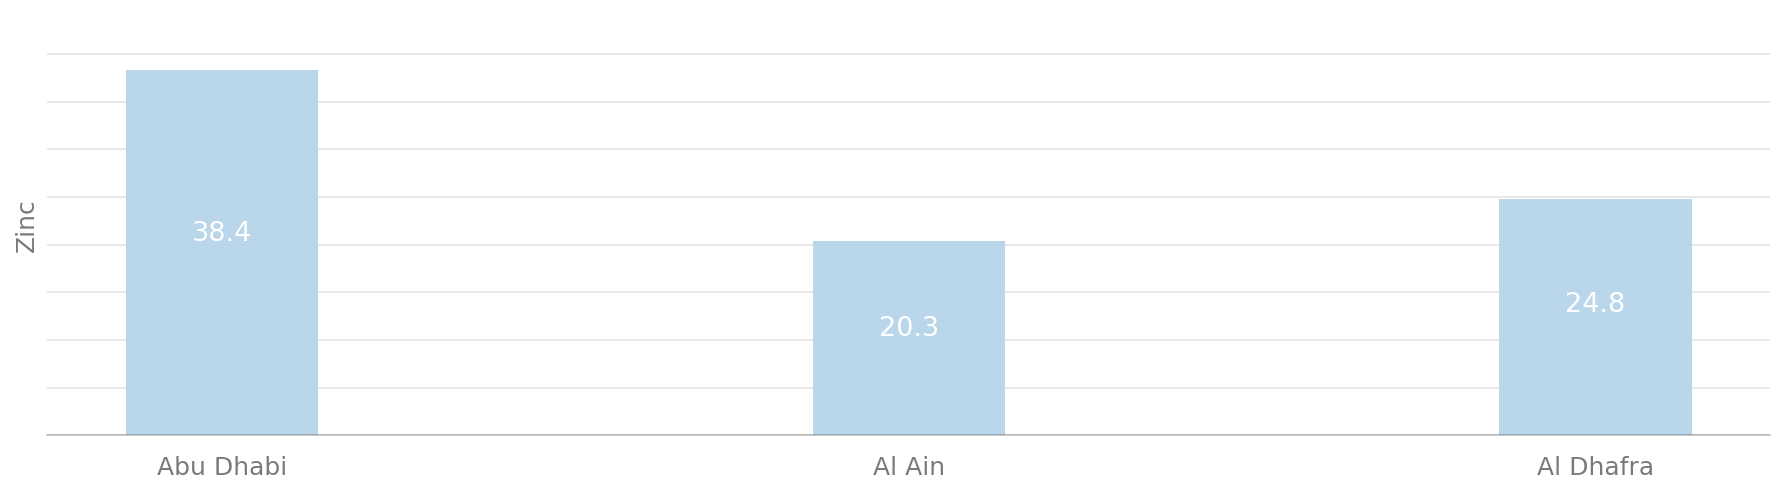

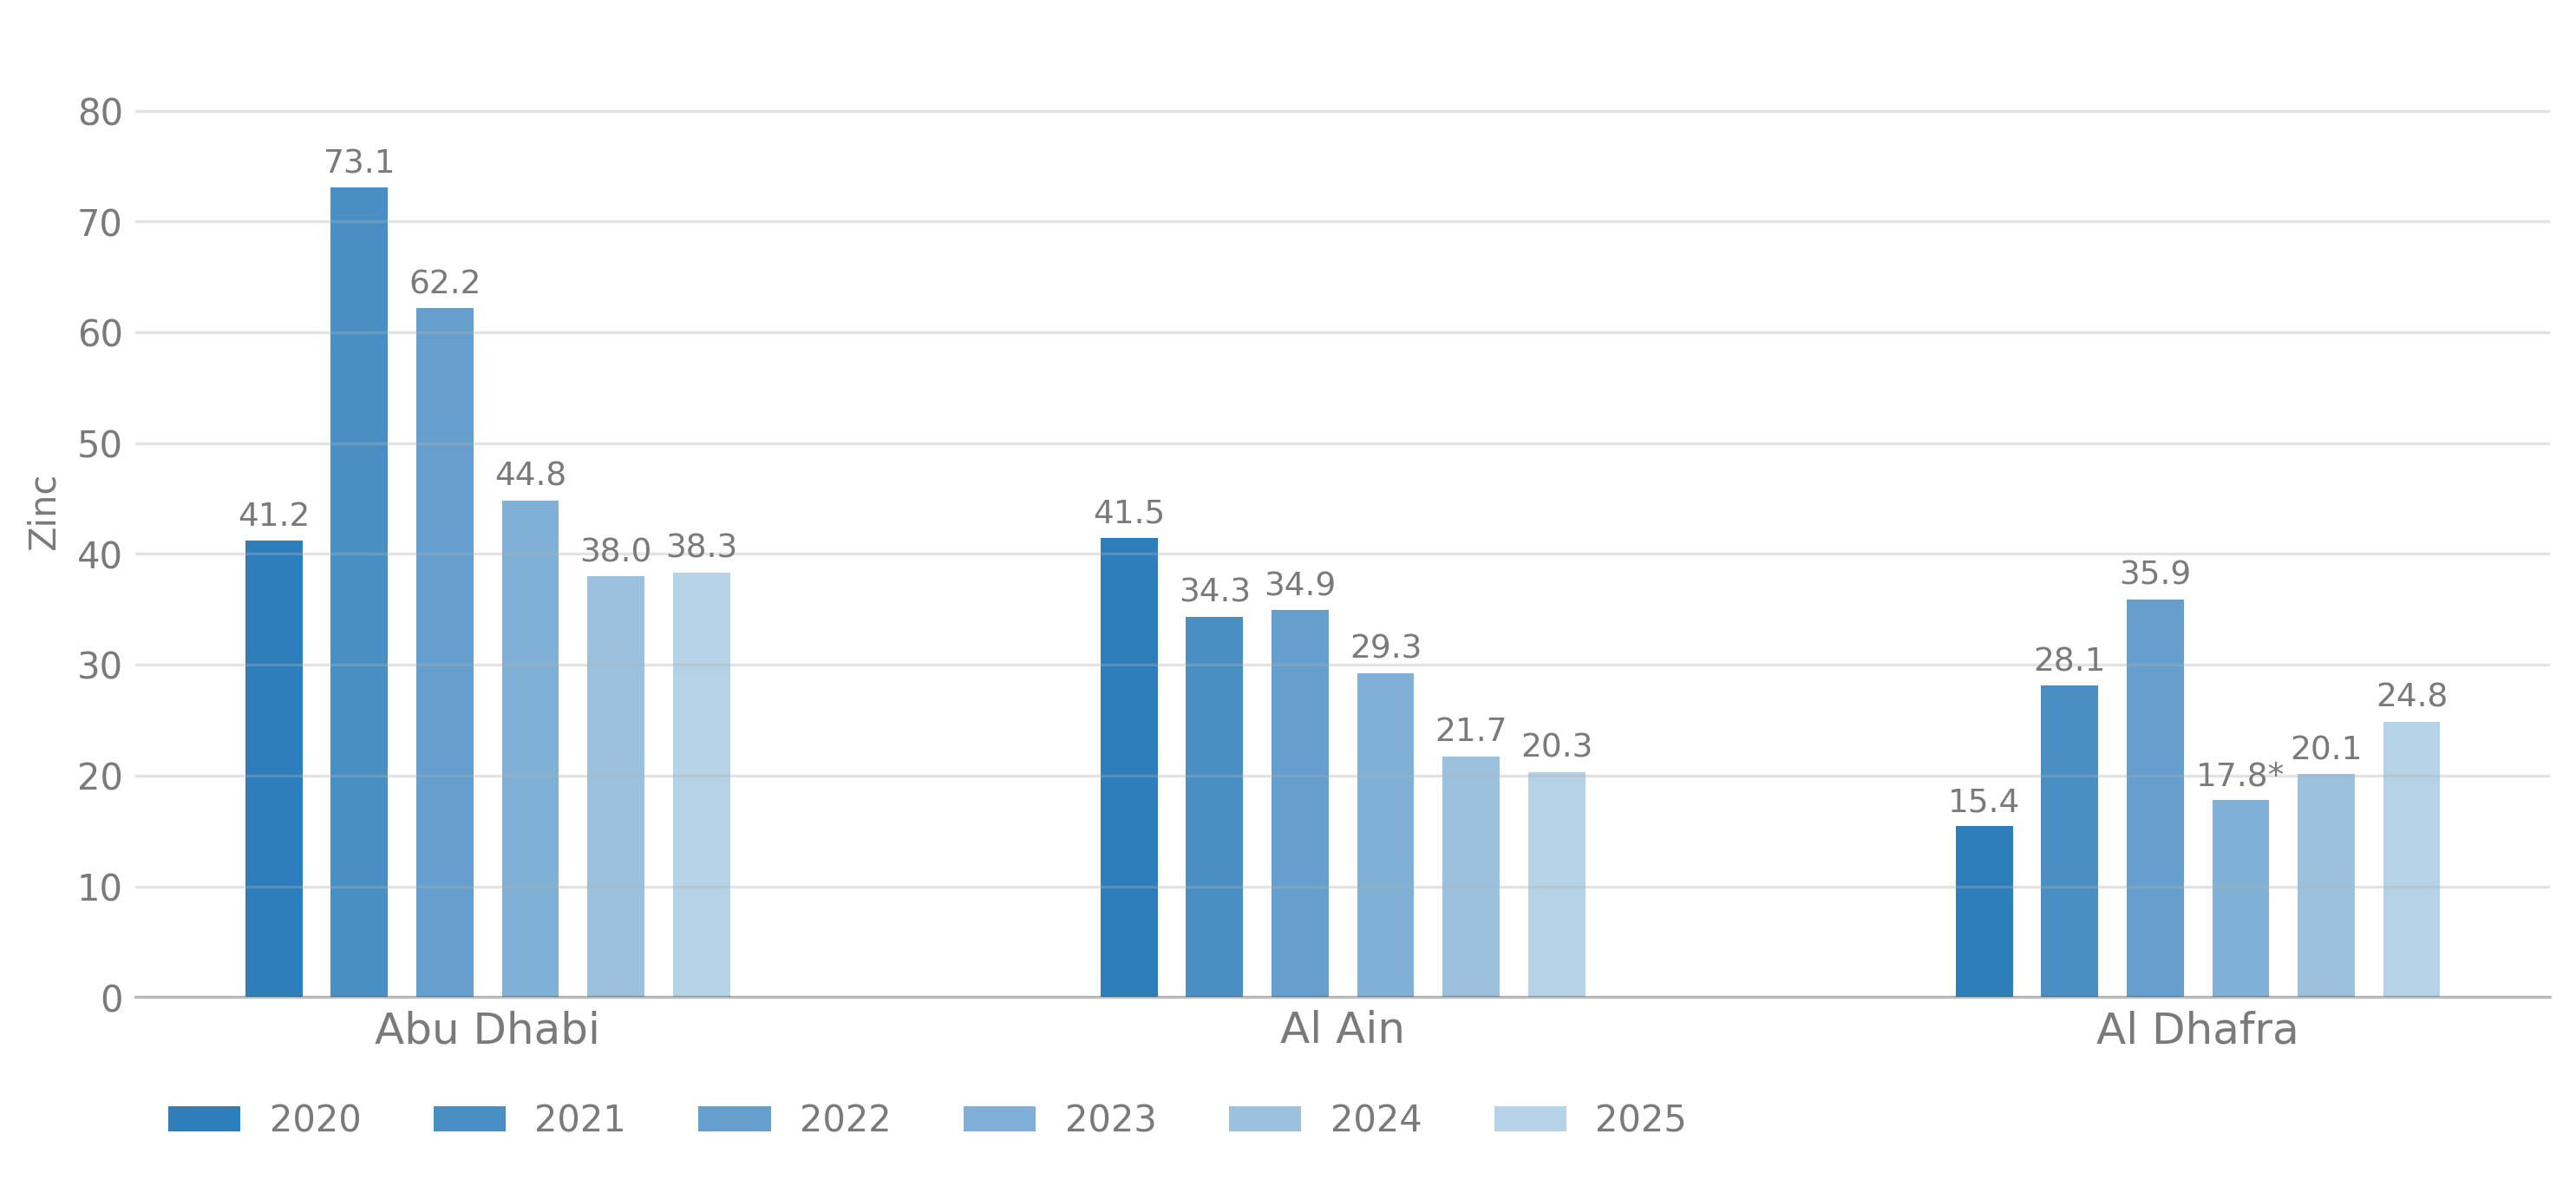

Mercury


Mean ± se  Median   Min   Max   n
LandUse     Region                                          
Residential Abu Dhabi  0.01 ± 0.00 a    0.01  0.01  0.05  96
            Al Ain     0.01 ± 0.00 a    0.01  0.01  0.05  32
            Al Dhafra  0.01 ± 0.00 a    0.01  0.01  0.02  21

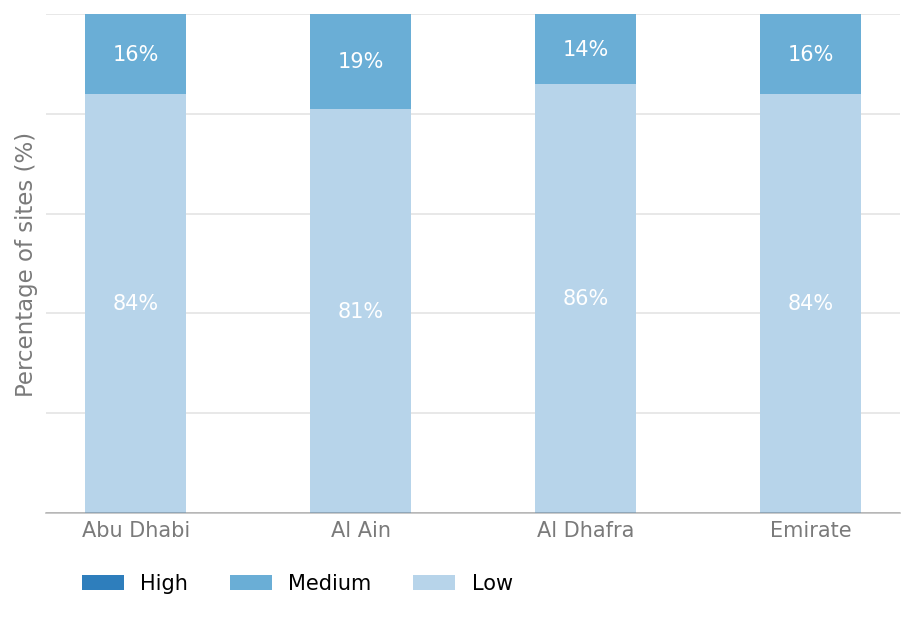

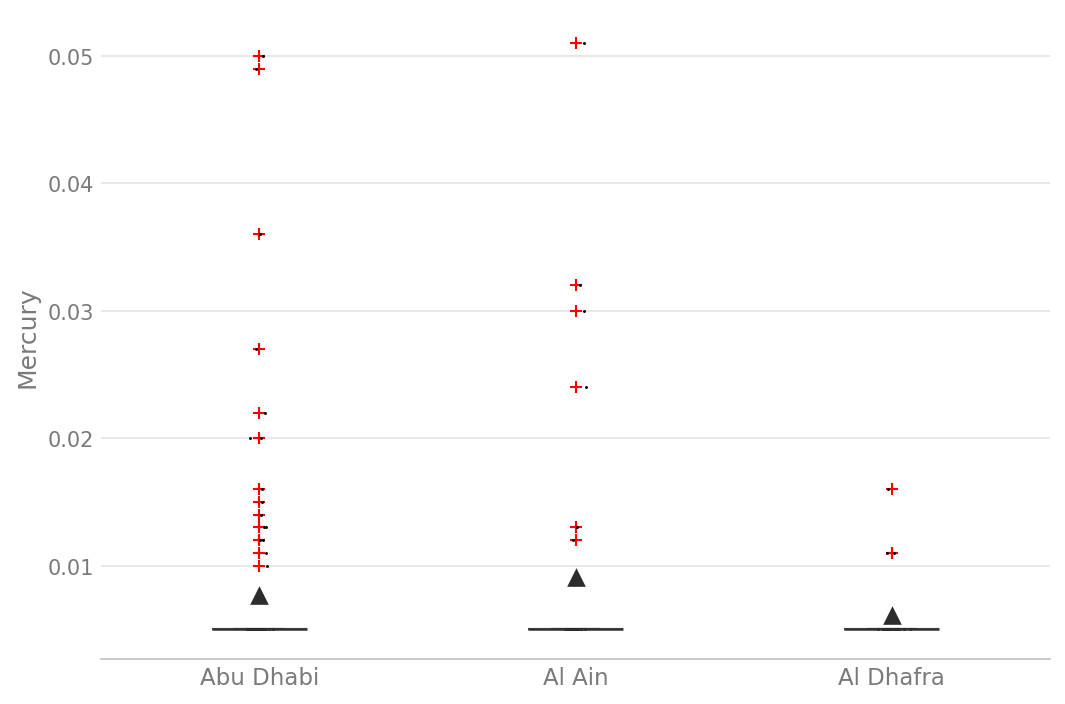

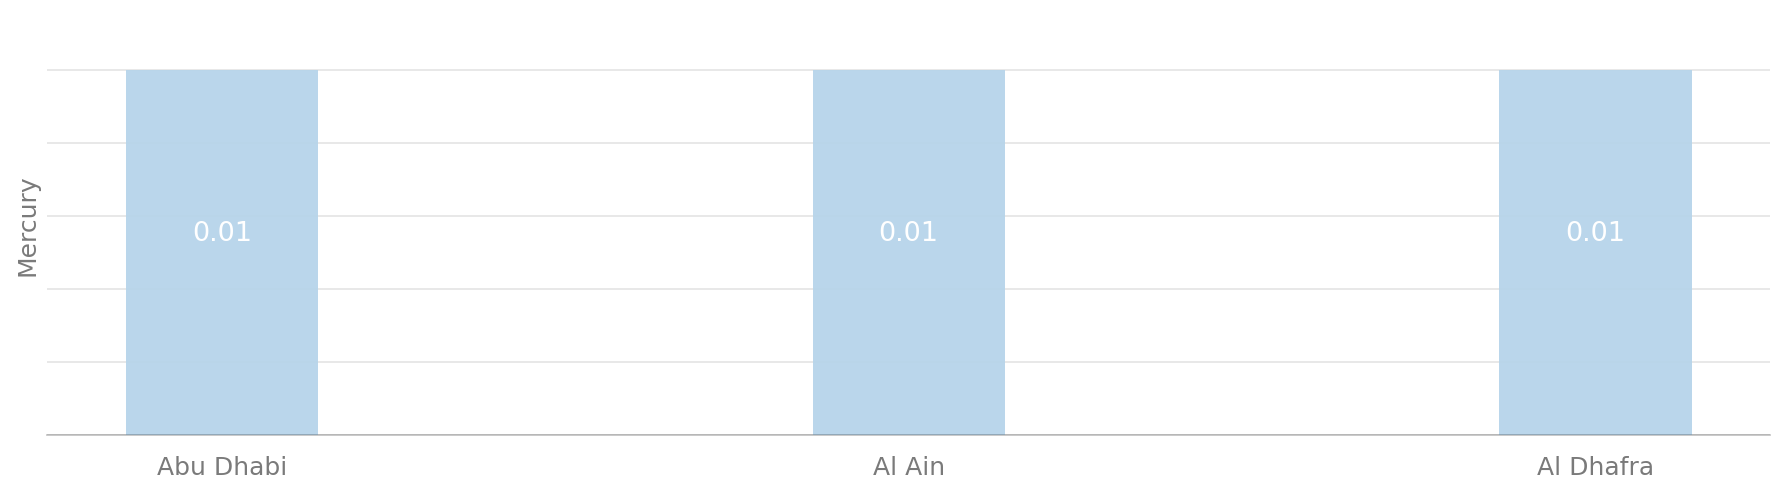

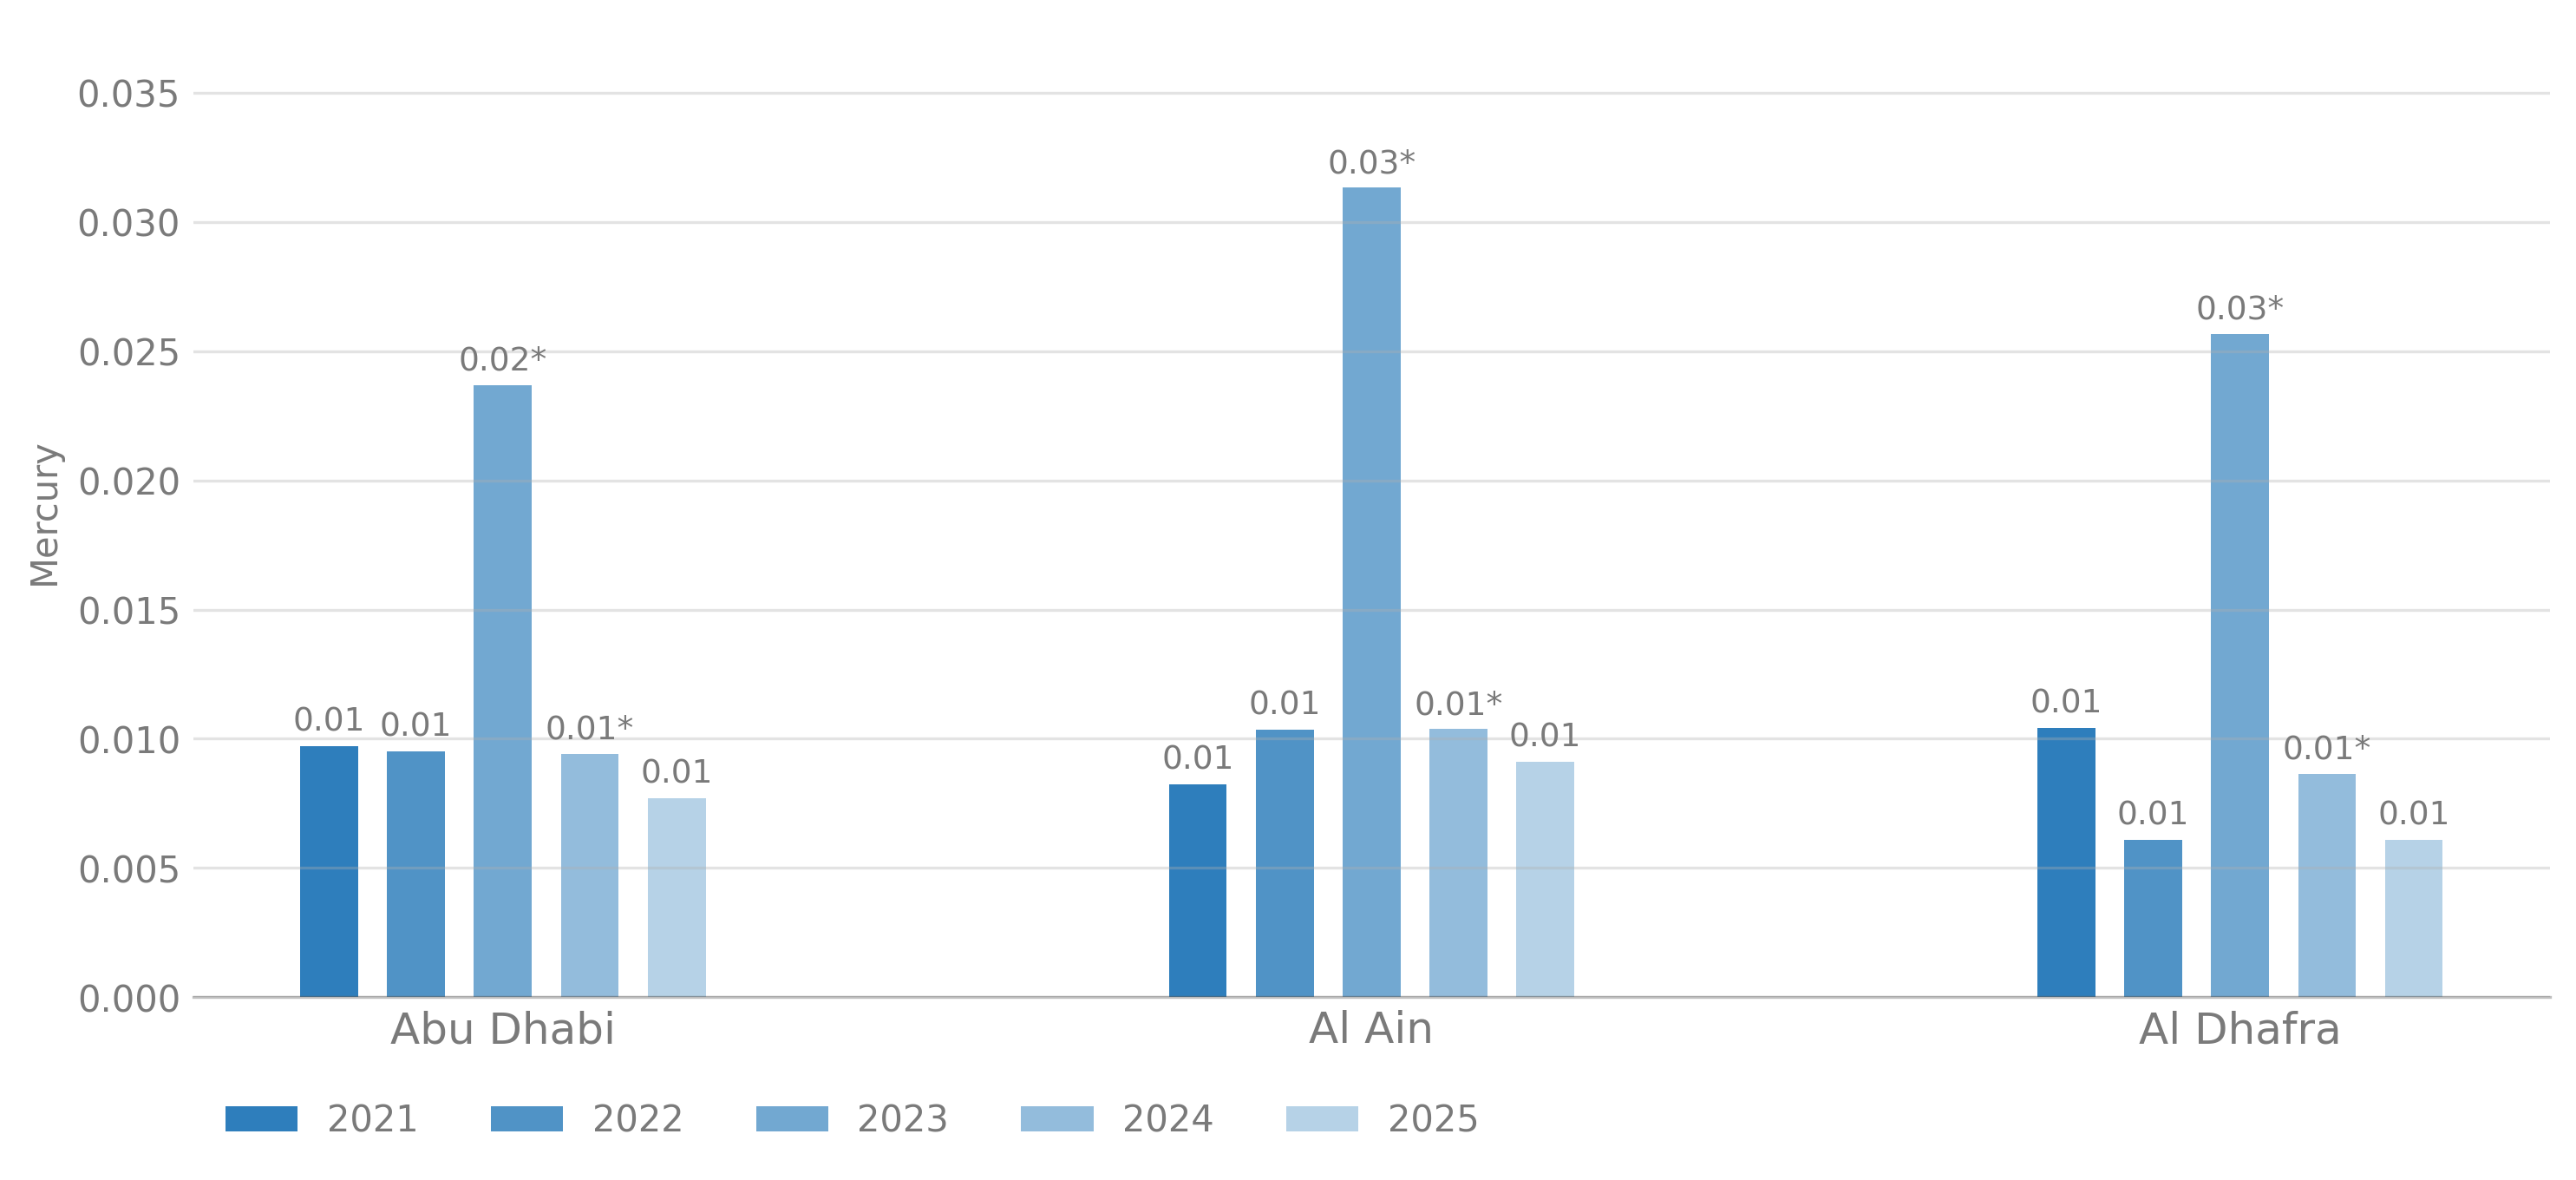

In [23]:
df = pd.read_excel('../Result_hmq/Soil quality data QC/Soil quality data QC 2025.xlsx', sheet_name='Processed_Data')
df = df[(df["PHUID"] == 1) & (df["PHSampleUID"] == 1)]
df = filter_surface_landuse_region(df, survey_id=land_use_id, regions=regions)

name_dict = {
    "Arsenic": "Arsenic",
    "Cadmium": "Cadmium",
    "Cobalt": "Cobalt",
    "Copper": "Copper",
    "Lead": "Lead_aqua",
    "Manganese": "Manganese",
    "Molybdenum": "Molybdenum",
    "Nickel": "Nickel_aqua",
    "Selenium": "Selenium_aqua",
    "Zinc": "Zinc",
    "Mercury": "InorganicMercury",
}
abl_dict = {
    "Arsenic": 1.79,
    "Antimony": 0.16,
    "Barium": 28.6,
    "Beryllium": 0.11,
    "Cadmium": 0.11,
    "Cobalt": 4.24,
    "Copper": 7.65,
    "Lead": 3.11,
    "Lithium": 8.25,
    "Manganese": 157,
    "Molybdenum": 0.68,
    "Nickel": 57,
    "Selenium": 0.23,
    "Strontium": 890,
    "Vanadium": 13.8,
    "Zinc": 33.8,
    "Mercury": 0.01,
}
ssl_dict = {
    "Arsenic": 0.68,
    "Cadmium": 0.71,
    "Cobalt": 2.3,
    "Copper": 310,
    "Lead": 200,
    "Manganese": 180,
    "Molybdenum": 39,
    "Nickel": 140,
    "Selenium": 39,
    "Zinc": 2300,
    "Mercury": 0.71,
}
for element_name in name_dict.keys():
    col_name = name_dict[element_name]
    abl = abl_dict[element_name]
    ssl = ssl_dict[element_name]
    # ===== 极值点坐标
    print(element_name)
    extreme_ph = get_extreme_point(
        df,
        value_col=col_name,
        mode="max",  # pH 取最小
    )
    extreme_ph
    # ===== 描述性统计
    df_surface = summary_by_region(df, value_col=col_name, regions=regions, landuse_name=land_use_name)
    # ===== 显著性检验
    samples = regional_samples(df, value_col=col_name, regions=regions)
    df_post, sig_dict, all_normal = posthoc_tests(samples, regions)

    letters = assign_letters_from_sig(df_surface.reset_index(), sig_dict, landuse_name=land_use_name, regions=regions)
    df_ph_surface_labeled = append_letters_to_summary(df_surface, letters, landuse_name=land_use_name, regions=regions)
    display(df_ph_surface_labeled)
    # ===== 分级对比
    pct_df = threshold_class_pct_by_region(
        df,
        value_col=col_name,
        abl=abl,
        ssl=ssl,
        regions=regions,
        region_col="Location",
        site_id_col="SiteUID",   # 关键：按站点口径
        include_emirate=True,
        round_digits=0
    )

    STACK_PALETTE = {
        "Low": hex_colors[0],
        "Medium": hex_colors[1],
        "High": hex_colors[2],
        "text": "white",
        "grid_alpha": 0.35,
    }

    fig, ax = plot_threshold_stack_pct(
        pct_df,
        order=["Abu Dhabi", "Al Ain", "Al Dhafra", "Emirate"],
        palette=STACK_PALETTE,
        ylabel="Percentage of sites (%)",
        label_min=1.0
    )
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_threshold_stack_pct.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_threshold_stack_pct.svg"), bbox_inches="tight", pad_inches=0.1)
    # ===== 箱线图 + 散点 + 均值
    fig,ax=plot_box_jitter_mean(
        df, value_col=col_name,
        regions_order=regions,
        ylabel=element_name,
        exclude_below=None,
        facecolor=hex_colors[0]
    )
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_box_jitter_mean.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_box_jitter_mean.svg"), bbox_inches="tight", pad_inches=0.1)
    # ===== 单年均值柱形图
    PH_PALETTE = {
        "base": hex_colors[0],
        "edge": "#C79A78",
        "mean": "#2C2C2C",
        "scatter": "#000000",
        "value_text": "white",
    }

    fig,ax=plot_mean_bar_single_year(
        df_surface,                       # 你前面算出来的 summary 表
        regions=regions,
        landuse_name=land_use_name,
        palette=PH_PALETTE,
        ylabel=element_name,
        legend=False,
    )
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_mean_bar_single_year.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_mean_bar_single_year.svg"), bbox_inches="tight", pad_inches=0.1)
    # ===== 年度趋势
    qc_dir = "../Result_hmq/Soil quality data QC"
    years = list(range(2020, 2026))

    elem_long = build_long_year_region_from_qc(
        qc_dir=qc_dir,
        years=years,
        value_col=col_name,
        survey_id=land_use_id,
        regions=regions,
    )

    elem_long.head()

    anova_by_region, posthoc_by_region = year_anova_posthoc_by_region(elem_long)
    adj_star = adjacent_sig_years_from_posthoc(elem_long, posthoc_by_region)

    mean_by_region_year = (
        elem_long.groupby(["Region", "YearNum"], as_index=False)["Value"]
               .mean()
               .rename(columns={"Value": "MeanValue"})
    )

    fig,ax=plot_grouped_bars_years(
        mean_by_region_year,
        regions_order=regions,
        star_years=adj_star,
        ylabel=element_name,
        base_color=hex_colors[-1]
    )
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_grouped_bars_years.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch08_{element_name}_grouped_bars_years.svg"), bbox_inches="tight", pad_inches=0.1)